# Introduction

The new local betting firm in Lithuania decided to hire a data scientist to analyze data from various football leagues in Europe, matches and players, and to give suggestions what features of the football teams are really important to be observed. What statistics of football matches should be registered and what conclusion can be made from them, if you want to indicate teams potential to be the winner of the national league or to score larger number of goals. Also they want to form the data frame, used to predict the outcome of tha match and the number of the goals scored.
So, first of all I'll pick two national football leagues to investigate further, find similarities and differences in them, in the leader teams, goals scored and so on. And I hope to find some patterns in those national leagues, to suggest, how to make our national football league better.

## 1.1. Data set up

In [1]:
import sqlite3
import numpy as np
from numpy import int64
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
# import string 
# import spacy
# import squarify
import statsmodels.stats.api as sms
import scipy.stats.distributions as dist
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from math import ceil
import matplotlib as mpl
from IPython.display import Image
from warnings import filterwarnings
filterwarnings(action='ignore')
%matplotlib inline   
%load_ext blackcellmagic

In [2]:
football_sql = sqlite3.connect("database.sqlite")

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("float_format", "{:.2f}".format)

## 1.2. Structure and revision of the football_sql tables

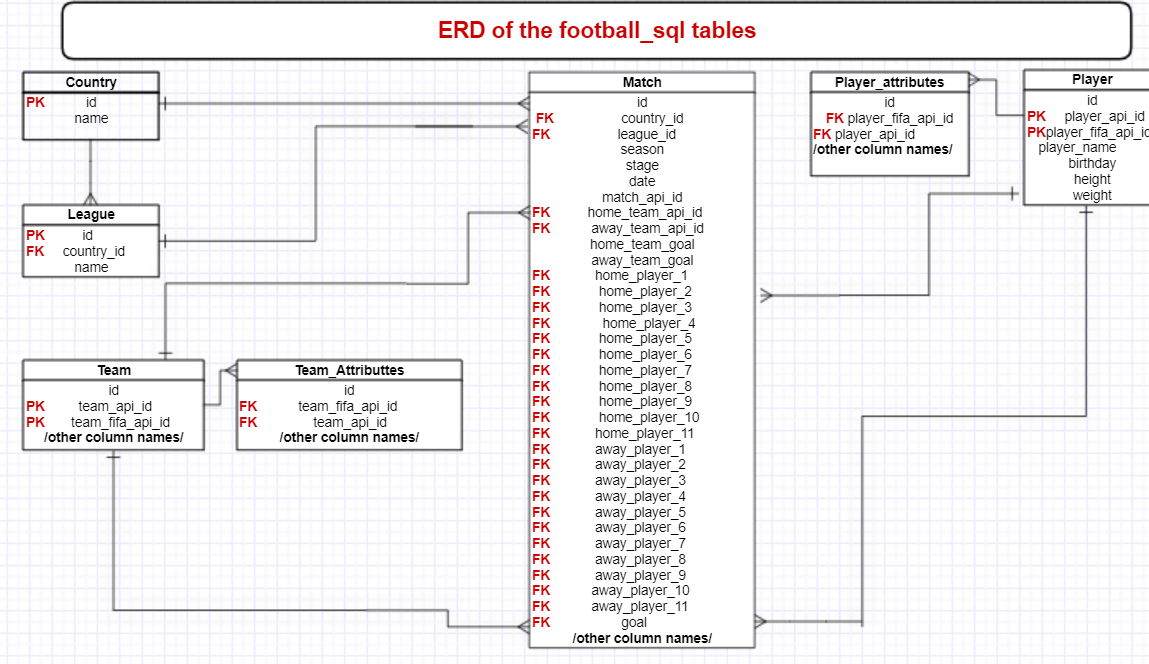

In [4]:
# Made with gliffy tools from: https://go.gliffy.com/go/html5/13643006
Image(filename="png_folder\ERD.png")

In [174]:
tables = pd.read_sql(
    """SELECT type, name
        FROM sqlite_master 
        WHERE type = 'table'; 
    """,
    football_sql,
)
tables

* table 'sqlite_sequence'

In [6]:
sqlite_sequence_table = pd.read_sql(
    """SELECT *
       FROM sqlite_sequence; 
    """,
    football_sql,
)
sqlite_sequence_table

name     seq
0               Team  103916
1            Country   51958
2             League   51958
3              Match   51958
4             Player   11075
5  Player_Attributes  183978
6    Team_Attributes    1458

This table contains of information about records in all other tables.

* table 'Country'

In [7]:
country_table = pd.read_sql(
    """SELECT *
       FROM country; 
    """,
    football_sql,
)
country_table

id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland

This table contains the id and the names of the 11 Europian country names.

* table 'League'

In [8]:
league_table = pd.read_sql(
    """SELECT *
       FROM League; 
    """,
    football_sql,
)
league_table

id  country_id                      name
0       1           1    Belgium Jupiler League
1    1729        1729    England Premier League
2    4769        4769            France Ligue 1
3    7809        7809     Germany 1. Bundesliga
4   10257       10257             Italy Serie A
5   13274       13274    Netherlands Eredivisie
6   15722       15722        Poland Ekstraklasa
7   17642       17642  Portugal Liga ZON Sagres
8   19694       19694   Scotland Premier League
9   21518       21518           Spain LIGA BBVA
10  24558       24558  Switzerland Super League

There are the names of the national football leagues by each country. Primary key (id) and foreign key (country id) are the same.

* table 'Team'

In [9]:
team_table = pd.read_sql(
    """SELECT *
       FROM Team; 
    """,
    football_sql,
)
team_table.head()

id  team_api_id  team_fifa_api_id     team_long_name team_short_name
0   1         9987            673.00           KRC Genk             GEN
1   2         9993            675.00       Beerschot AC             BAC
2   3        10000          15005.00   SV Zulte-Waregem             ZUL
3   4         9994           2007.00   Sporting Lokeren             LOK
4   5         9984           1750.00  KSV Cercle Brugge             CEB

In [10]:
len(team_table)

299

In [11]:
team_table.duplicated().sum()

0

In [175]:
unique_teams = pd.read_sql(
    """SELECT COUNT(DISTINCT team_api_id) unique_team_id
FROM Team;""",
    football_sql,
)
unique_teams

In [176]:
unique_teams_names = pd.read_sql(
    """SELECT COUNT(DISTINCT team_long_name) unique_team_names
FROM Team;""",
    football_sql,
)
unique_teams

SO there ate 299 unique teams observed, no duplicates. Let's check for any NULL values.

In [177]:
null_sum_team = pd.read_sql(
    """SELECT COUNT(*)-COUNT(id) As id_null, COUNT(*)-COUNT(team_api_id) As team_api_id_null, 
COUNT(*)-COUNT(team_fifa_api_id) As team_fifa_api_id_null, COUNT(*)-COUNT(team_long_name) As team_long_name_null, 
COUNT(*)-COUNT(team_short_name) As team_short_name_null
FROM Team;""",
    football_sql,
)
null_sum_team

So we have null values in team_fifa_api_id column, but all values are in thea team_api_id column, so having that in mind i will use the team_api_id column.

* table 'Team_Attributes'

In [178]:
team_attr_table = pd.read_sql(
    """SELECT *
       FROM Team_Attributes; 
    """,
    football_sql,
)
team_attr_table.head(2)

Let's check for NULL values in this table.

In [179]:
team_attr_table_null = pd.read_sql(
    """
       SELECT COUNT(*)-COUNT(id) id_null, 
       COUNT(*)-COUNT(team_fifa_api_id) team_fifa_api_id_null, 
       COUNT(*)-COUNT(team_api_id) team_api_id_null, 
       COUNT(*)-COUNT(date) date_null, 
       COUNT(*)-COUNT(buildUpPlaySpeed) buildUpPlaySpeed_null,
       COUNT(*)-COUNT(buildUpPlaySpeedClass) buildUpPlaySpeedClass_null, 
       COUNT(*)-COUNT(buildUpPlayDribbling) buildUpPlayDribbling_null,
       COUNT(*)-COUNT(buildUpPlayDribblingClass) buildUpPlayDribblingClass_null, 
       COUNT(*)-COUNT(buildUpPlayPassing) buildUpPlayPassing_null,
       COUNT(*)-COUNT(buildUpPlayPassingClass) buildUpPlayPassingClass_null, 
       COUNT(*)-COUNT(buildUpPlayPositioningClass) buildUpPlayPositioningClass_null,
       COUNT(*)-COUNT(chanceCreationPassing) chanceCreationPassing_null, 
       COUNT(*)-COUNT(chanceCreationPassingClass) chanceCreationPassingClass_null,
       COUNT(*)-COUNT(chanceCreationCrossing) chanceCreationCrossing_null, 
       COUNT(*)-COUNT(chanceCreationCrossingClass) chanceCreationCrossingClass_null,
       COUNT(*)-COUNT(chanceCreationShooting) chanceCreationShooting_null, 
       COUNT(*)-COUNT(chanceCreationShootingClass) chanceCreationShootingClass_null,
       COUNT(*)-COUNT(chanceCreationPositioningClass) chanceCreationPositioningClass_null, 
       COUNT(*)-COUNT(defencePressure) defencePressure_null,
       COUNT(*)-COUNT(defencePressureClass) defencePressureClass_null, 
       COUNT(*)-COUNT(defenceAggression) defenceAggression_null, 
       COUNT(*)-COUNT(defenceAggressionClass) defenceAggressionClass_null,
       COUNT(*)-COUNT(defenceTeamWidth) defenceTeamWidth_null, 
       COUNT(*)-COUNT(defenceTeamWidthClass) defenceTeamWidthClass_null,
       COUNT(*)-COUNT(defenceDefenderLineClass) defenceDefenderLineClass_null
FROM Team_Attributes;""",
    football_sql,
)
team_attr_table_null

There are 969 NULL values in the column 'buildUpPlayDribbling_null'. All other columns are clean, without NULL values.

* table 'Match'

In [17]:
match_table = pd.read_sql(
    """SELECT *
       FROM Match; 
    """,
    football_sql,
)
match_table.head(2)

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0        492473              9987              9993               1   
1        492474             10000              9994               0   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             NaN             NaN             NaN   
1               0             NaN             NaN             NaN   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             NaN             NaN              NaN              NaN   
1             NaN             NaN              NaN              NaN   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             NaN              NaN              NaN             NaN   
1             NaN              NaN              NaN             NaN   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   

   home_player_Y10  home_player_Y11  away_player_Y1  away_player_Y2  \
0              NaN              NaN             NaN             NaN   
1              NaN              NaN             NaN             NaN   

   away_player_Y3  away_player_Y4  away_player_Y5  away_player_Y6  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   

   away_player_Y7  away_player_Y8  away_player_Y9  away_player_Y10  \
0             NaN             NaN             NaN              NaN   
1             NaN             NaN             NaN              NaN   

   away_player_Y11  home_player_1  home_player_2  home_player_3  \
0              NaN            NaN            NaN            NaN   
1              NaN            NaN            NaN            NaN   

   home_player_4  home_player_5  home_player_6  home_player_7  home_player_8  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   

   home_player_9  home_player_10  home_player_11  away_player_1  \
0            NaN             NaN             NaN            NaN   
1            NaN             NaN             NaN            NaN   

   away_player_2  away_player_3  away_player_4  away_player_5  away_player_6  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   

   away_player_7  away_player_8  away_player_9  away_player_10  \
0            NaN            NaN            NaN             NaN   
1            NaN            NaN            NaN             NaN   

   away_player_11  goal shoton shotoff foulcommit  card cross corner  \
0             NaN  None   None    None       None  None  None   None   
1             NaN  None   None    Non

In [18]:
len(match_table)

25979

In [19]:
match_table.duplicated().sum()

0

In [ ]:
match_table.isnull().sum()

There are lots of NULL values in the Match table, only the first 11 columns have no NULL values. ALL other do have, so having this in mind I'll count later for needed column.

While investigating 'Match' table, I found out, that it had lots of missing values in the columns 'goal', 'shoton', 'shotoff', 'possession', especially in SPAIN league, season 2013/2014. That's why I didn't use information from these columns about SPAIN LIGA BBVA. Below you can see how many missing values were in Spain's tables.

In [2]:
all_missing_spain = pd.read_sql(
    """WITH t1 AS(SELECT season, COUNT(shoton) shoton_missing
FROM Match 
WHERE league_id = 21518 AND shoton='<shoton />'  OR shoton IS NULL
GROUP BY season),

t2 AS(SELECT season, COUNT(shotoff) shotoff_missing
FROM Match 
WHERE league_id = 21518 AND shotoff='<shotoff />'  OR shotoff IS NULL
GROUP BY season),

t3 AS(SELECT season, COUNT(possession) possession_missing
FROM Match 
WHERE league_id = 21518 AND possession ='<possession />'  OR possession IS NULL
GROUP BY season),

t4 AS(SELECT season, COUNT(card) card_missing
FROM Match 
WHERE league_id = 21518 AND card ='<card />'  OR card IS  NULL
GROUP BY season),

t5 AS(SELECT season, COUNT(goal) goal_missing
FROM Match 
WHERE league_id = 21518 AND goal ='<goal />'  OR goal IS NULL
GROUP BY season)

SELECT t1.*, t2.shotoff_missing, t3.possession_missing, t4.card_missing, t5.goal_missing
FROM t1
LEFT JOIN t2
ON t1.season=t2.season
LEFT JOIN t3
ON t1.season = t3.season
LEFT JOIN t4
ON t1.season=t4.season
LEFT JOIN t5
ON t1.season=t5.season;
""",
    football_sql,
)
all_missing_spain

And in England Premier League we have:

In [183]:
all_missing_england = pd.read_sql(
    """WITH t1 AS(SELECT season, COUNT(shoton) shoton_missing
FROM Match 
WHERE league_id = 1729 AND shoton='<shoton />' OR shoton IS NULL
GROUP BY season),

t2 AS(SELECT season, COUNT(shotoff) shotoff_missing
FROM Match 
WHERE league_id = 1729 AND shotoff='<shotoff />'   OR shotoff IS NULL
GROUP BY season),

t3 AS(SELECT season, COUNT(possession) possession_missing
FROM Match 
WHERE league_id = 1729 AND possession ='<possession />'  OR possession IS NULL
GROUP BY season),

t4 AS(SELECT season, COUNT(card) card_missing
FROM Match 
WHERE league_id = 1729 AND card ='<card />'  OR card IS NULL
GROUP BY season),

t5 AS(SELECT season, COUNT(goal) goal_missing
FROM Match 
WHERE league_id = 1729 AND goal ='<goal />'  OR goal IS NULL
GROUP BY season)

SELECT t1.*, t2.shotoff_missing, t3.possession_missing, t4.card_missing, t5.goal_missing
FROM t1
LEFT JOIN t2
ON t1.season=t2.season
LEFT JOIN t3
ON t1.season = t3.season
LEFT JOIN t4
ON t1.season=t4.season
LEFT JOIN t5
ON t1.season=t5.season;
""",
    football_sql,
)
all_missing_england

season  shoton_missing  shotoff_missing  possession_missing  \
0  2008/2009               0                0                   4   
1  2009/2010               0                0                   1   
2  2010/2011               0                0                   0   
3  2011/2012               0                0                   0   
4  2012/2013               0                0                   0   
5  2013/2014               0                0                   0   
6  2014/2015               0                0                   0   
7  2015/2016               0                0                   0   

   card_missing  goal_missing  
0            17            31  
1            24            25  
2            25            24  
3            26            24  
4            22            29  
5            20            26  
6            11            24  
7            22            30

So I can definitely use 'shoton' and 'shotoff' about England Premier League.

* table 'Player'

In [23]:
player_table = pd.read_sql(
    """SELECT *
       FROM Player; 
    """,
    football_sql,
)
player_table.head(2)

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146

In [24]:
player_table.duplicated().sum()

0

In [25]:
len(player_table)

11060

In [3]:
unique_players = pd.read_sql(
    """SELECT 
    COUNT(DISTINCT player_api_id) unique_player_ids, 
    COUNT(DISTINCT(player_name)) unique_players_names
    FROM Player;""",
    football_sql,
)
unique_players

There are some names, that are the same, but from the players id we see that all player id's are unique, no duplicates.

In [185]:
player_table_null = pd.read_sql(
    """SELECT COUNT(*)-COUNT(id) id_null, 
    COUNT(*)-COUNT(player_api_id) player_api_id_null, 
    COUNT(*)-COUNT(player_name) player_name_null, 
    COUNT(*)-COUNT(player_fifa_api_id) player_fifa_api_id_null, 
    COUNT(*)-COUNT(birthday) birthday_null,
    COUNT(*)-COUNT(height) height_null, 
    COUNT(*)-COUNT(weight) weight_null
    FROM Player;""",
    football_sql,
)
player_table_null

There are no NULL values in the 'Player' table.

* table 'Player_Attributes'

In [28]:
player_attr_table = pd.read_sql(
    """SELECT *
       FROM Player_Attributes; 
    """,
    football_sql,
)
player_attr_table.head(2)

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00           67.00   
1   2              218353         505942  2015-11-19 00:00:00           67.00   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0      71.00          right              medium              medium     49.00   
1      71.00          right              medium              medium     49.00   

   finishing  heading_accuracy  short_passing  volleys  dribbling  curve  \
0      44.00             71.00          61.00    44.00      51.00  45.00   
1      44.00             71.00          61.00    44.00      51.00  45.00   

   free_kick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0               39.00         64.00         49.00         60.00         64.00   
1               39.00         64.00         49.00         60.00         64.00   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0    59.00      47.00    65.00       55.00    58.00    54.00     76.00   
1    59.00      47.00    65.00       55.00    58.00    54.00     76.00   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0       35.00       71.00          70.00        45.00   54.00      48.00   
1       35.00       71.00          70.00        45.00   54.00      48.00   

   marking  standing_tackle  sliding_tackle  gk_diving  gk_handling  \
0    65.00            69.00           69.00       6.00        11.00   
1    65.00            69.00           69.00       6.00        11.00   

   gk_kicking  gk_positioning  gk_reflexes  
0       10.00            8.00         8.00  
1       10.00            8.00         8.00

In [29]:
len(player_attr_table)

183978

In [30]:
player_attr_table.duplicated().sum()

0

In [186]:
unique_player_attr = pd.read_sql(
    """SELECT COUNT(DISTINCT player_api_id) unique_players_observed
    FROM Player_Attributes;""",
    football_sql,
)
unique_player_attr

There are all 11060 players from Player table observed, but that is done for several times per player, as we have in total 183978 observations in this table. So, it seems that players attributes are given in different times fot the same player.

In [188]:
player_attr_table_null = pd.read_sql(
    """
       SELECT COUNT(*)-COUNT(id) id_null, 
       COUNT(*)-COUNT(player_fifa_api_id) player_fifa_api_id_null, 
       COUNT(*)-COUNT(player_api_id) player_api_id_null, 
       COUNT(*)-COUNT(date) date_null, 
       COUNT(*)-COUNT(overall_rating) overall_rating_null,
       COUNT(*)-COUNT(potential) potential_null, 
       COUNT(*)-COUNT(preferred_foot) preferred_foot_null, 
       COUNT(*)-COUNT(attacking_work_rate) attacking_work_rate_null,
       COUNT(*)-COUNT(defensive_work_rate) defensive_work_rate_null, 
       COUNT(*)-COUNT(crossing) crossing_null, 
       COUNT(*)-COUNT(finishing) finishing_null, 
       COUNT(*)-COUNT(heading_accuracy) heading_accuracy_null,
       COUNT(*)-COUNT(short_passing) short_passing_null, 
       COUNT(*)-COUNT(volleys) volleys_null, 
       COUNT(*)-COUNT(dribbling) dribbling_null, 
       COUNT(*)-COUNT(curve) curve_null, 
       COUNT(*)-COUNT(free_kick_accuracy) free_kick_accuracy_null,
       COUNT(*)-COUNT(long_passing) long_passing_null, 
       COUNT(*)-COUNT(ball_control) ball_control_null, 
       COUNT(*)-COUNT(acceleration) acceleration_null, 
       COUNT(*)-COUNT(sprint_speed) sprint_speed_null,
       COUNT(*)-COUNT(agility) agility_null, 
       COUNT(*)-COUNT(reactions) reactions_null, 
       COUNT(*)-COUNT(balance) balance_null, 
       COUNT(*)-COUNT(shot_power) shot_power_null, 
       COUNT(*)-COUNT(jumping) jumping_null, 
       COUNT(*)-COUNT(stamina) stamina_null,
       COUNT(*)-COUNT(strength) strength_null, 
       COUNT(*)-COUNT(long_shots) long_shots_null, 
       COUNT(*)-COUNT(aggression) aggression_null, 
       COUNT(*)-COUNT(interceptions) interceptions_null, 
       COUNT(*)-COUNT(positioning) positioning_null,
       COUNT(*)-COUNT(vision) vision_null, 
       COUNT(*)-COUNT(penalties) penalties_null, 
       COUNT(*)-COUNT(marking) marking_null, 
       COUNT(*)-COUNT(standing_tackle) standing_tackle_null, 
       COUNT(*)-COUNT(sliding_tackle) sliding_tackle_null,
       COUNT(*)-COUNT(gk_diving) gk_diving_null, 
       COUNT(*)-COUNT(gk_handling) gk_handling_null, 
       COUNT(*)-COUNT(gk_kicking) gk_kicking_null, 
       COUNT(*)-COUNT(gk_positioning) gk_positioning_null,
       COUNT(*)-COUNT(gk_reflexes) gk_reflexes_null
FROM Player_Attributes;""",
    football_sql,
)
player_attr_table_null

id_null  player_fifa_api_id_null  player_api_id_null  date_null  \
0        0                        0                   0          0   

   overall_rating_null  potential_null  preferred_foot_null  \
0                  836             836                  836   

   attacking_work_rate_null  defensive_work_rate_null  crossing_null  \
0                      3230                       836            836   

   finishing_null  heading_accuracy_null  short_passing_null  volleys_null  \
0             836                    836                 836          2713   

   dribbling_null  curve_null  free_kick_accuracy_null  long_passing_null  \
0             836        2713                      836                836   

   ball_control_null  acceleration_null  sprint_speed_null  agility_null  \
0                836                836                836          2713   

   reactions_null  balance_null  shot_power_null  jumping_null  stamina_null  \
0             836          2713              836          2713           836   

   strength_null  long_shots_null  aggression_null  interceptions_null  \
0            836              836              836                 836   

   positioning_null  vision_null  penalties_null  marking_null  \
0               836         2713             836           836   

   standing_tackle_null  sliding_tackle_null  gk_diving_null  \
0                   836                 2713             836   

   gk_handling_null  gk_kicking_null  gk_positioning_null  gk_reflexes_null  
0               836              836                  836               836

There are lots og NULL values, so I'll have that in mind.

## 1.3. Creating subsets of data (working data frames in pandas)

* All observed European football leagues table.

In [190]:
leagues_table = pd.read_sql(
    """SELECT c.name country_name, 
c.id country_id, l.name league_title, 
l.id league_id, COUNT(DISTINCT m.home_team_api_id) number_of_teams, 
COUNT(DISTINCT m.season) number_of_season,
MIN(m.season) from_season, MAX(m.season) to_season
FROM "Country" c
INNER JOIN "League" l
ON c.id = l.country_id
INNER JOIN Match m
ON l.id = m.league_id
GROUP BY league_title
ORder by number_of_teams DESC
; """,
    football_sql,
)
leagues_table.head()

country_name  country_id            league_title  league_id  \
0       France        4769          France Ligue 1       4769   
1      England        1729  England Premier League       1729   
2        Spain       21518         Spain LIGA BBVA      21518   
3        Italy       10257           Italy Serie A      10257   
4      Germany        7809   Germany 1. Bundesliga       7809   

   number_of_teams  number_of_season from_season  to_season  
0               35                 8   2008/2009  2015/2016  
1               34                 8   2008/2009  2015/2016  
2               33                 8   2008/2009  2015/2016  
3               32                 8   2008/2009  2015/2016  
4               30                 8   2008/2009  2015/2016

* Data only about England Premier League and Spain LIGA BBVA, from 'Match' table.

In [192]:
england_spain_match_table = pd.read_sql(
    """SELECT m.country_id, 
m.season as season, 
l.name league_name, 
m.match_api_id,
m.home_team_api_id, 
m.away_team_api_id,
m.home_team_goal, 
m.away_team_goal,
CASE WHEN home_team_goal >  away_team_goal THEN 3
WHEN  home_team_goal = away_team_goal THEN 1
ELSE 0 END AS home_team_points,
CASE WHEN  home_team_goal < away_team_goal THEN 3
WHEN  home_team_goal = away_team_goal THEN 1
ELSE 0 END AS away_team_points
FROM Match m
INNER JOIN League l
ON l.country_id = m.country_id AND (league_id = 21518 OR league_id = 1729);""",
    football_sql,
)
england_spain_match_table.head()

country_id     season             league_name  match_api_id  \
0        1729  2008/2009  England Premier League        489042   
1        1729  2008/2009  England Premier League        489043   
2        1729  2008/2009  England Premier League        489044   
3        1729  2008/2009  England Premier League        489045   
4        1729  2008/2009  England Premier League        489046   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
0             10260             10261               1               1   
1              9825              8659               1               0   
2              8472              8650               0               1   
3              8654              8528               2               1   
4             10252              8456               4               2   

   home_team_points  away_team_points  
0                 1                 1  
1                 3                 0  
2                 0                 3  
3                 3                 0  
4                 3                 0

* Listed only teams, that played in SPAIN LIGA BBVA through these observed 8 season.

In [194]:
list_of_all_spain_teams = pd.read_sql(
    """WITH all_spain AS(SELECT *
FROM  MATCH
WHERE country_id = 21518),

spain_teams_by_season AS(SELECT DISTINCT season, home_team_api_id team_api_id
FROM all_spain),

spain_total_teams AS(SELECT DISTINCT team_api_id
FROM spain_teams_by_season)

SELECT s.team_api_id, t.team_long_name
FROM spain_total_teams s
INNER JOIN Team t
ON t.team_api_id = s.team_api_id;""",
    football_sql,
)
list_of_all_spain_teams.head()

team_api_id             team_long_name
0        10267                Valencia CF
1         8371                 CA Osasuna
2         9783  RC Deportivo de La Coruña
3         8388                CD Numancia
4         8696           Racing Santander

In [196]:
spain_teams_with_attributes = pd.read_sql(
    """WITH all_spain AS(SELECT *
FROM  MATCH
WHERE country_id = 21518),

spain_teams_by_season AS(SELECT DISTINCT season, home_team_api_id team_api_id
FROM all_spain),

spain_total_teams AS(SELECT DISTINCT team_api_id
FROM spain_teams_by_season),

spain_teams AS (SELECT s.team_api_id, t.team_long_name
FROM spain_total_teams s
INNER JOIN Team t
ON t.team_api_id = s.team_api_id),
final AS(Select ta.team_api_id, ta. date, ta.chanceCreationPassing, ta.chanceCreationCrossing, ta.chanceCreationShooting, ta.defencePressure, ta.defenceAggression, ta.defenceTeamWidth
FROM "Team_Attributes" ta
Where team_api_id IN (Select team_api_id From spain_teams))

Select s.team_long_name, f.*
FROM spain_teams s 
JOIN final f 
ON s.team_api_id=f.team_api_id;""",
    football_sql,
)
spain_teams_with_attributes.head()

team_long_name  team_api_id                 date  chanceCreationPassing  \
0     UD Almería         9865  2010-02-22 00:00:00                     45   
1     UD Almería         9865  2011-02-22 00:00:00                     57   
2     UD Almería         9865  2012-02-22 00:00:00                     57   
3     UD Almería         9865  2013-09-20 00:00:00                     57   
4     UD Almería         9865  2014-09-19 00:00:00                     57   

   chanceCreationCrossing  chanceCreationShooting  defencePressure  \
0                      45                      70               70   
1                      54                      69               58   
2                      54                      40               37   
3                      54                      40               37   
4                      54                      40               37   

   defenceAggression  defenceTeamWidth  
0                 65                30  
1                 68                67  
2                 53                45  
3                 53                45  
4                 53                45

* List of all teams, that played in England Premier League.

In [198]:
list_of_all_england_teams = pd.read_sql(
    """WITH all_spain AS(SELECT *
FROM  MATCH
WHERE country_id = 1729),

spain_teams_by_season AS(SELECT DISTINCT season, home_team_api_id team_api_id
FROM all_spain),

spain_total_teams AS(SELECT DISTINCT team_api_id
FROM spain_teams_by_season)

SELECT s.team_api_id, t.team_long_name
FROM spain_total_teams s
INNER JOIN Team t
ON t.team_api_id = s.team_api_id;""",
    football_sql,
)
list_of_all_england_teams.head()

team_api_id     team_long_name
0        10260  Manchester United
1         9825            Arsenal
2         8472         Sunderland
3         8654    West Ham United
4        10252        Aston Villa

In [199]:
england_teams_with_attributes = pd.read_sql(
    """WITH all_spain AS(SELECT *
FROM  MATCH
WHERE country_id = 1729),

england_teams_by_season AS(SELECT DISTINCT season, home_team_api_id team_api_id
FROM all_spain),

england_total_teams AS(SELECT DISTINCT team_api_id
FROM england_teams_by_season),

england_teams AS (SELECT s.team_api_id, t.team_long_name
FROM england_total_teams s
INNER JOIN Team t
ON t.team_api_id = s.team_api_id),
final AS(Select ta.team_api_id, ta. date, ta.chanceCreationPassing, ta.chanceCreationCrossing, ta.chanceCreationShooting, ta.defencePressure, ta.defenceAggression, ta.defenceTeamWidth
FROM "Team_Attributes" ta
Where team_api_id IN (Select team_api_id From england_teams))

Select s.team_long_name, f.*
FROM england_teams s 
JOIN final f 
ON s.team_api_id=f.team_api_id;""",
    football_sql,
)
england_teams_with_attributes.head()

* Spain LIGA BBVA all players with some attributes.

In [200]:
spain_liga_players_all_seasons = pd.read_sql(
    """WITH table_1 AS(SELECT home_team_api_id, away_team_api_id, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11
FROM MATCH
WHERE league_id = 21518),

table_2 AS(SELECT home_player_1 player_api_id
	FROM table_1
	UNION 
	SELECT home_player_2
	FROM table_1
	UNION
	SELECT home_player_3
	FROM table_1
	UNION
	SELECT home_player_4
	FROM table_1
	UNION 
	SELECT home_player_5
	FROM table_1
	UNION
	SELECT home_player_6
	FROM table_1
	UNION
	SELECT home_player_7
	FROM table_1
	UNION 
	SELECT home_player_8
	FROM table_1
	UNION
	SELECT home_player_9
	FROM table_1
	UNION 
	SELECT home_player_10
	FROM table_1
	UNION
	SELECT home_player_11
	FROM table_1
	UNION
	SELECT away_player_1
	FROM table_1
	UNION
	SELECT away_player_2
	FROM table_1
	UNION
	SELECT away_player_3
	FROM table_1
	UNION
	SELECT away_player_4
	FROM table_1
	UNION
	SELECT away_player_5
	FROM table_1
	UNION 
	SELECT away_player_6
	FROM table_1 
	UNION 
	SELECT away_player_7
	FROM table_1
	UNION
	SELECT away_player_8
	FROM table_1 
	UNION 
	SELECT away_player_9
	FROM table_1 
	UNION
	SELECT away_player_10
	FROM table_1
	UNION 
	SELECT away_player_11
	FROM table_1)


SELECT DISTINCT t.player_api_id, p.player_name, p.height, p.weight, pa.date, pa.overall_rating, pa.potential
FROM table_2 t 
INNER JOIN Player p 
ON t.player_api_id=p.player_api_id
INNER JOIN Player_Attributes pa 
ON t.player_api_id = pa.player_api_id
WHERE t.player_api_id IS NOT NULL AND overall_rating IS NOT NULL AND potential IS NOT NULL
ORDER BY player_name, date ASC;""",
    football_sql,
)
spain_liga_players_all_seasons.head()

As we see, there are multiple qualifications per player, which differ by date, so I decided to drop date and also create a smaller data frame only with the mean of overall_rating and potential for each player. For the future improvement, I would use the dates of games and combine these rating of football players by the date of the game, but in this stage i think the mean of those ratings per player will be enough.

In [201]:
spain_player_with_avg_attr = spain_liga_players_all_seasons.groupby(['player_api_id', 'player_name'])['height',	'weight', 'overall_rating',	'potential'].mean()
spain_player_with_avg_attr.reset_index(inplace=True)
spain_player_with_avg_attr.head()

player_api_id       player_name  height  weight  overall_rating  potential
0           2752       Diego Mainz  187.96  174.00           69.38      70.38
1           2768       Jose Dorado  180.34  154.00           69.29      70.57
2           2770  Ignacio Gonzalez  180.34  161.00           71.13      73.53
3           2790       Alberto Rey  175.26  163.00           70.20      75.80
4           2796    Javier Jimenez  182.88  170.00           64.60      70.53

* England Premier League all players with some attributes.

In [202]:
england_premier_league_players_all_seasons = pd.read_sql(
    """WITH table_1 AS(SELECT home_team_api_id, away_team_api_id, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11
FROM MATCH
WHERE league_id = 1729),

table_2 AS(SELECT home_player_1 player_api_id
	FROM table_1
	UNION 
	SELECT home_player_2
	FROM table_1
	UNION
	SELECT home_player_3
	FROM table_1
	UNION
	SELECT home_player_4
	FROM table_1
	UNION 
	SELECT home_player_5
	FROM table_1
	UNION
	SELECT home_player_6
	FROM table_1
	UNION
	SELECT home_player_7
	FROM table_1
	UNION 
	SELECT home_player_8
	FROM table_1
	UNION
	SELECT home_player_9
	FROM table_1
	UNION 
	SELECT home_player_10
	FROM table_1
	UNION
	SELECT home_player_11
	FROM table_1
	UNION
	SELECT away_player_1
	FROM table_1
	UNION
	SELECT away_player_2
	FROM table_1
	UNION
	SELECT away_player_3
	FROM table_1
	UNION
	SELECT away_player_4
	FROM table_1
	UNION
	SELECT away_player_5
	FROM table_1
	UNION 
	SELECT away_player_6
	FROM table_1 
	UNION 
	SELECT away_player_7
	FROM table_1
	UNION
	SELECT away_player_8
	FROM table_1 
	UNION 
	SELECT away_player_9
	FROM table_1 
	UNION
	SELECT away_player_10
	FROM table_1
	UNION 
	SELECT away_player_11
	FROM table_1)


SELECT DISTINCT t.player_api_id, p.player_name, p.height, p.weight, pa.date, pa.overall_rating, pa.potential
FROM table_2 t 
INNER JOIN Player p 
ON t.player_api_id=p.player_api_id
INNER JOIN Player_Attributes pa 
ON t.player_api_id = pa.player_api_id
WHERE t.player_api_id IS NOT NULL AND overall_rating IS NOT NULL AND potential IS NOT NULL
ORDER BY player_name, date ASC;""",
    football_sql,
)
england_premier_league_players_all_seasons.head()

In [42]:
england_premier_league_player_with_avg_attr = england_premier_league_players_all_seasons.groupby(['player_api_id', 'player_name'])['height',	'weight', 'overall_rating',	'potential'].mean()
england_premier_league_player_with_avg_attr.reset_index(inplace=True)
england_premier_league_player_with_avg_attr.head()

player_api_id      player_name  height  weight  overall_rating  potential
0           2802  Pablo Hernandez  172.72  159.00           76.32      78.86
1           3512    Peter Halmosi  177.80  163.00           69.85      72.62
2           3520  Andrey Arshavin  172.72  154.00           79.68      81.64
3           8922   Nikica Jelavic  187.96  185.00           73.76      75.84
4           8985     Mile Jedinak  187.96  172.00           70.42      73.15

* Table of the Yellow, Yellow2 (second) and Red cards in both Spain LIGA BBVA and England Premier League.

Here I had to extract information from the html file.

In [204]:
cards_from_sql = pd.read_sql(
    """SELECT league_id, season, match_api_id, card
FROM Match 
WHERE card IS NOT NULL AND (league_id = 1729 OR league_id = 21518);""",
    football_sql,
)
cards_from_sql.head()

league_id     season  match_api_id  \
0       1729  2008/2009        489042   
1       1729  2008/2009        489043   
2       1729  2008/2009        489044   
3       1729  2008/2009        489045   
4       1729  2008/2009        489046   

                                                card  
0  <card><value><comment>y</comment><stats><ycard...  
1                                           <card />  
2  <card><value><comment>y</comment><stats><ycard...  
3  <card><value><comment>y</comment><stats><ycard...  
4  <card><value><comment>y</comment><stats><ycard...

In [205]:
# Extracting information from HTML file.
cards = {'league_id' : [], 'season': [], 'match_api_id' : [], 'card_type':[],
'team_api_id': []}
for league_id, season, match_api_id, rows in zip(cards_from_sql['league_id'], 
cards_from_sql['season'],
cards_from_sql['match_api_id'], 
cards_from_sql['card']):
    if not rows:
        continue
    root = ET.fromstring(rows)
    for child in root:
        card = child.find('card_type')
        team = child.find('team')
        if card !=None and team !=None:
            cards['league_id'].append(f'{league_id}')
            cards['season'].append(f'{season}')
            cards['match_api_id'].append(f'{match_api_id}')
            cards['card_type'].append(f'{card.text}')
            cards['team_api_id'].append(f'{team.text}')
cards_df = pd.DataFrame(cards)
cards_df[['league_id', 'match_api_id','team_api_id']] = cards_df[['league_id', 'match_api_id','team_api_id']].astype(int64)
cards_df.head()

league_id     season  match_api_id card_type  team_api_id
0       1729  2008/2009        489042         y        10260
1       1729  2008/2009        489042         y        10260
2       1729  2008/2009        489042         y        10260
3       1729  2008/2009        489044         y         8650
4       1729  2008/2009        489044         y         8650

* Shots on and shots off table.

Extracting info into shot on data frame.

In [207]:
shot_on = pd.read_sql(
    """SELECT league_id, season, match_api_id, shoton
FROM Match 
WHERE shoton IS NOT NULL AND (league_id = 1729 OR league_id = 21518);""",
    football_sql,
)
shot_on.head()

league_id     season  match_api_id  \
0       1729  2008/2009        489042   
1       1729  2008/2009        489043   
2       1729  2008/2009        489044   
3       1729  2008/2009        489045   
4       1729  2008/2009        489046   

                                              shoton  
0  <shoton><value><stats><blocked>1</blocked></st...  
1  <shoton><value><stats><blocked>1</blocked></st...  
2  <shoton><value><stats><blocked>1</blocked></st...  
3  <shoton><value><stats><shoton>1</shoton></stat...  
4  <shoton><value><stats><blocked>1</blocked></st...

In [208]:
# Extracting information from HTML file.
shots = {'league_id' : [], 'season': [], 'match_api_id' : [], 
'team_api_id': []}
for league_id, season, match_api_id, rows in zip(shot_on['league_id'], 
shot_on['season'],
shot_on['match_api_id'], 
shot_on['shoton']):
    if not rows:
        continue
    root = ET.fromstring(rows)
    for child in root:
        team = child.find('team')
        if team !=None:
            shots['league_id'].append(f'{league_id}')
            shots['season'].append(f'{season}')
            shots['match_api_id'].append(f'{match_api_id}')
            shots['team_api_id'].append(f'{team.text}')

In [47]:
shots_on_df = pd.DataFrame(shots)
shots_on_df.head()

league_id     season match_api_id team_api_id
0      1729  2008/2009       489042       10260
1      1729  2008/2009       489042       10260
2      1729  2008/2009       489042       10260
3      1729  2008/2009       489042       10260
4      1729  2008/2009       489042       10260

In [209]:
total_shot_on_df = pd.DataFrame(shots_on_df.groupby(['league_id','season', 'match_api_id'])['team_api_id'].value_counts().reset_index(name='shot_on'))
total_shot_on_df.head()

league_id     season match_api_id team_api_id  shot_on
0      1729  2008/2009       489042       10260       11
1      1729  2008/2009       489042       10261        1
2      1729  2008/2009       489043        9825       12
3      1729  2008/2009       489043        8659        2
4      1729  2008/2009       489044        8650       11

Making shot off df.

In [210]:
shot_off = pd.read_sql("""SELECT league_id, season, match_api_id, shotoff
FROM Match 
WHERE shotoff IS NOT NULL AND (league_id = 1729 OR league_id = 21518);""", football_sql)
shot_off.head(1)

league_id     season  match_api_id  \
0       1729  2008/2009        489042   

                                             shotoff  
0  <shotoff><value><stats><shotoff>1</shotoff></s...

In [215]:
# Extracting information from HTML file.
shots = {"league_id": [], "season": [], "match_api_id": [], "team_api_id": []}
for league_id, season, match_api_id, rows in zip(
    shot_off["league_id"],
    shot_off["season"],
    shot_off["match_api_id"],
    shot_off["shotoff"],
):
    if not rows:
        continue
    root = ET.fromstring(rows)
    for child in root:
        team = child.find("team")
        if team != None:
            shots["league_id"].append(f"{league_id}")
            shots["season"].append(f"{season}")
            shots["match_api_id"].append(f"{match_api_id}")
            shots["team_api_id"].append(f"{team.text}")

In [216]:
shots_off_df = pd.DataFrame(shots)
shots_off_df.head()

league_id     season match_api_id team_api_id
0      1729  2008/2009       489042       10260
1      1729  2008/2009       489042       10261
2      1729  2008/2009       489042       10261
3      1729  2008/2009       489042       10261
4      1729  2008/2009       489042       10260

In [213]:
total_shot_off_df = pd.DataFrame(
    shots_off_df.groupby(["league_id", "season", "match_api_id"])["team_api_id"]
    .value_counts()
    .reset_index(name="shot_off")
)
total_shot_off_df.head()

In [212]:
# Merging into 1 table shot_on_shot_of.
shot_on_shot_off = total_shot_on_df.merge(
    total_shot_off_df, on=["league_id", "season", "match_api_id", "team_api_id"]
)
shot_on_shot_off[
    ["league_id", "match_api_id", "team_api_id", "shot_on", "shot_off"]
] = shot_on_shot_off[
    ["league_id", "match_api_id", "team_api_id", "shot_on", "shot_off"]
].astype(
    int64
)

In [54]:
shot_on_shot_off.head()

league_id     season  match_api_id  team_api_id  shot_on  shot_off
0       1729  2008/2009        489042        10260       11        10
1       1729  2008/2009        489042        10261        1         9
2       1729  2008/2009        489043         9825       12        13
3       1729  2008/2009        489043         8659        2         3
4       1729  2008/2009        489044         8650       11         5

* Table of total scores per teams, earned in all seasons in England Premier league and Spain LIGA BBVA.

In [218]:
scores_spain_england = pd.read_sql(
    """WITH spain_england_table AS(
SELECT m.country_id, 
        m.season as season, 
        l.name league_name, 
        m.home_team_api_id, 
        m.away_team_api_id,
        m.home_team_goal, 
        m.away_team_goal,
        CASE WHEN home_team_goal >  away_team_goal THEN 3
        WHEN  home_team_goal = away_team_goal THEN 1
        ELSE 0 END AS home_team_points,
        CASE WHEN  home_team_goal < away_team_goal THEN 3
        WHEN  home_team_goal = away_team_goal THEN 1
        ELSE 0 END AS away_team_points
FROM Match m
INNER JOIN League l
ON l.country_id = m.country_id AND (league_id = 21518 OR league_id = 1729)),

home_scores AS (SELECT season, league_name, home_team_api_id, SUM(home_team_points) home_scores
FROM spain_england_table
GROUP BY 1, 2, 3),

away_scores AS(SELECT season, league_name, away_team_api_id, SUM(away_team_points) away_scores
FROM spain_england_table
GROUP BY 1, 2, 3),

total_scores AS(SELECT h.season season, h.league_name, h.home_team_api_id team_api_id,  t.team_long_name team_title, t.team_short_name, (h.home_scores+a.away_scores) total_score
FROM home_scores h
LEFT JOIN away_scores a
ON h.season = a.season AND h.league_name = a.league_name AND h.home_team_api_id=a.away_team_api_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1, 2, 3)

SELECT *, rank() over(partition by season, league_name order by total_score DESC) as rank
FROM total_scores""",
    football_sql,
)
scores_spain_england.head()

season             league_name  team_api_id         team_title  \
0  2008/2009  England Premier League        10260  Manchester United   
1  2008/2009  England Premier League         8650          Liverpool   
2  2008/2009  England Premier League         8455            Chelsea   
3  2008/2009  England Premier League         9825            Arsenal   
4  2008/2009  England Premier League         8668            Everton   

  team_short_name  total_score  rank  
0             MUN           90     1  
1             LIV           86     2  
2             CHE           83     3  
3             ARS           72     4  
4             EVE           63     5

* Table of all goals in Spain LIGA BBVA and England Premier League.

In [219]:
spain_eng_goals = pd.read_sql(
    """WITH table_1 AS(SELECT season season, league_id,
home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
FROM Match 
WHERE league_id = 1729 OR league_id=21518),

home_score_table AS (SELECT season, league_id, home_team_api_id, SUM(home_team_goal) home_goals
FROM table_1
GROUP BY 1,2,3),

away_score_table AS (SELECT season, league_id, away_team_api_id, SUM(away_team_goal) away_goals
FROM table_1
GROUP BY 1,2,3)

SELECT h.season, h.league_id, l.name league_name, h.home_team_api_id team_api_id,  
t.team_long_name team_long_name, h.home_goals+a.away_goals total_goals
FROM home_score_table h
LEFT JOIN away_score_table a
ON h.season = a.season AND h.league_id = a.league_id AND h.home_team_api_id = a.away_team_api_id
INNER JOIN League l 
ON l.country_id = h.league_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1,2,4
ORDER BY 1,2,5;""",
    football_sql,
)
spain_eng_goals.head()

* Table of goals by players.

I will extract information about best scorers from Match table column 'goal' and put everything into 1 dataframe.

In [221]:
# Selecting goal column from sql table match.
goals_by_player = pd.read_sql(
    """SELECT m.season, m.league_id, m.goal
FROM MATCH m
INNER JOIN League l
ON m.league_id = l.id AND m.goal IS NOT NULL
WHERE m.league_id = 21518 OR m.league_id = 1729;""",
    football_sql,
)
goals_by_player.head()

season  league_id                                               goal
0  2008/2009       1729  <goal><value><comment>n</comment><stats><goals...
1  2008/2009       1729  <goal><value><comment>n</comment><stats><goals...
2  2008/2009       1729  <goal><value><comment>n</comment><stats><goals...
3  2008/2009       1729  <goal><value><comment>n</comment><stats><goals...
4  2008/2009       1729  <goal><value><comment>n</comment><stats><goals...

In [222]:
# Extracting information from HTML file.
scorers = {"season": [], "league_id": [], "team_api_id": [], "player_api_id": []}
for rows, season, league_id in zip(
    goals_by_player["goal"], goals_by_player["season"], goals_by_player["league_id"]
):
    if not rows:
        continue
    root = ET.fromstring(rows)
    for child in root:
        player = child.find("player1")
        team = child.find("team")
        if player != None and team != None:
            scorers["season"].append(f"{season}")
            scorers["league_id"].append(f"{league_id}")
            scorers["team_api_id"].append(f"{team.text}")
            scorers["player_api_id"].append(f"{player.text}")

In [224]:
# Making a working data frame about goals scored.
scorers_df = pd.DataFrame(scorers)
scorers_df[["league_id", "team_api_id", "player_api_id"]] = scorers_df[
    ["league_id", "team_api_id", "player_api_id"]
].astype(int64)
scorers_df = pd.DataFrame(
    scorers_df.groupby(["league_id", "season", "team_api_id"])["player_api_id"]
    .value_counts()
    .reset_index(name="goals")
)
scorers_df.head()

league_id     season  team_api_id  player_api_id  goals
0       1729  2008/2009         8455          37804     19
1       1729  2008/2009         8455          30631     13
2       1729  2008/2009         8455          31906      7
3       1729  2008/2009         8455          30679      6
4       1729  2008/2009         8455          30822      6

In [225]:
# Table of all player to get the names.
all_players = pd.read_sql(
    """SELECT p.player_api_id, p.player_name
FROM Player p
;""",
    football_sql,
)
all_players.head()

In [226]:
# Merging with team_titles and player names.
all_spain_eng_teams = pd.concat([list_of_all_spain_teams, list_of_all_england_teams])
spain_eng_scorers = scorers_df.join(
    all_spain_eng_teams.set_index("team_api_id"), on="team_api_id"
)
spain_eng_scorers = spain_eng_scorers.merge(all_players, on="player_api_id")
spain_eng_scorers.head()

# 2. Exploratory data analysis

## 2.1. Basic information about all data set

There are  8 seasons of 11 football leagues from European countries observed in this data set.

In [62]:
leagues_table.head()

country_name  country_id            league_title  league_id  \
0       France        4769          France Ligue 1       4769   
1      England        1729  England Premier League       1729   
2        Spain       21518         Spain LIGA BBVA      21518   
3        Italy       10257           Italy Serie A      10257   
4      Germany        7809   Germany 1. Bundesliga       7809   

   number_of_teams  number_of_season from_season  to_season  
0               35                 8   2008/2009  2015/2016  
1               34                 8   2008/2009  2015/2016  
2               33                 8   2008/2009  2015/2016  
3               32                 8   2008/2009  2015/2016  
4               30                 8   2008/2009  2015/2016

I combined England and Scotland into unite United Kingdom row with two leagues and two different sets of teams, as 'plotly map' doesn't see Scotland as a separate country.

In [228]:
leagues_united_king = (
    leagues_table.copy()
    .drop([1, 9], axis=0)
    .append(
        {
            "country_name": "United Kingdom",
            "country_id": [1729, 19694],
            "league_title": ["England Premier League", "Scotland Premier League"],
            "league_id": [1729, 19694],
            "number_of_teams": 51,
            "number_of_season": 8,
            "from_season": "2008/2009",
            "to_season": "2015/2016",
        },
        ignore_index=True,
    )
)

In [231]:
for col in leagues_united_king.columns:
    leagues_united_king[col] = leagues_united_king[col].astype(str)

leagues_united_king["text"] = (
    leagues_united_king["country_name"]
    + "<br>"
    + "Country/league id: "
    + leagues_united_king["country_id"]
    + ","
    + "<br>"
    + "National league title: "
    + leagues_united_king["league_title"]
    + ","
    + "<br>"
    + "Seasons observed: "
    + leagues_united_king["number_of_season"]
    + ","
    + "<br>"
    + "season from: "
    + leagues_united_king["from_season"]
    + ","
    + "<br>"
    + "season to: "
    + leagues_table["to_season"]
    + ","
    + "<br>"
    + "different teams played in total: "
    + leagues_united_king["number_of_teams"]
)


fig = go.Figure(
    data=go.Choropleth(
        locations=leagues_united_king["country_name"],
        locationmode="country names",
        z=leagues_united_king["number_of_teams"].astype(float),
        colorscale="deep",
        autocolorscale=False,
        text=leagues_united_king["text"],
        marker_line_color="white",
        colorbar_title="Europe's football leagues",
    )
)

fig.update_layout(
    title_text="Observed national football leagues in Europe <br>(Hover for breakdown)",
    geo=dict(
        scope="europe",
        projection=go.layout.geo.Projection(type="stereographic"),
        showlakes=True,  # lakes
        lakecolor="rgb(255, 255, 255)",
    ),
)

fig.show()

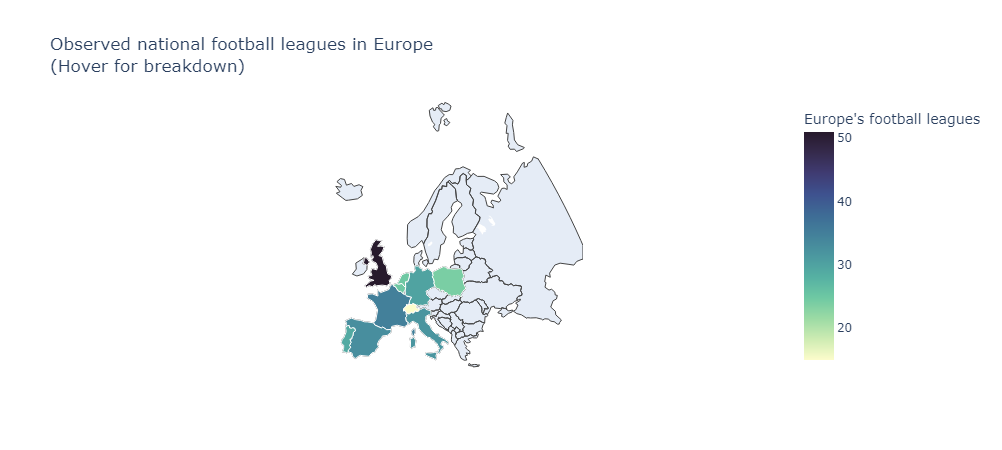

In [65]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\map.png")

Observed seasons from 2008/2009 to 2015/2016. The largest number of different teams played in France Ligue 1  - 35, then - England Premier League with - 34, but you must have in mind that United Kingdom has two leagues: England Premier League and Scotland Premier League (with additional 17 teams), so in total United Kingdom with two separate leagues has 51 team; and Spain LIGA BBVA with 33. This means that in those leagues there are the largest number of playing teams, some teams variate each year(for example 3 bottom teams after the season are eliminated from the league and new comes next year, so there is a rotation). So lets see how many teams play in each of those leagues by every season, is there a difference and which leagues are the largest.	

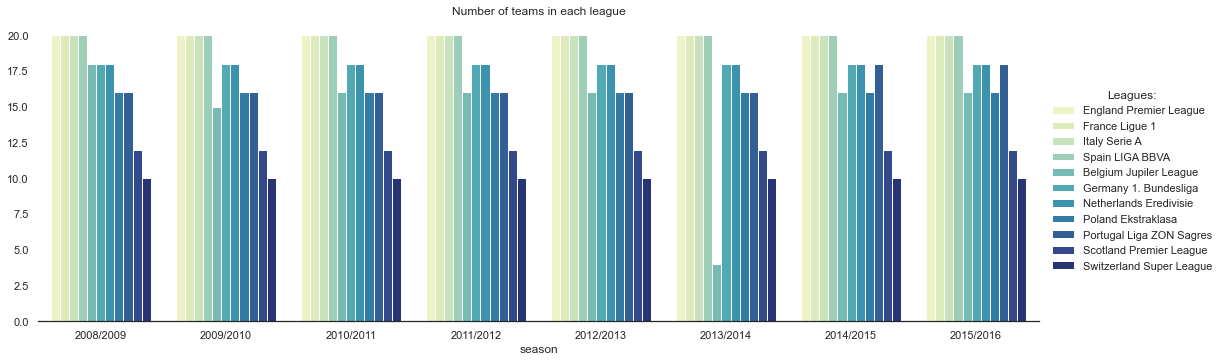

In [235]:
team_number_by_year = pd.read_sql(
    """SELECT l.name league_title, m.season season, COUNT(DISTINCT m.home_team_api_id) number_of_teams
FROM "League" l
INNER JOIN Match m
ON l.id = m.league_id
GROUP BY league_title, season
ORDER BY season, number_of_teams DESC;""",
    football_sql,
)
sns.set_style("white")

ax = sns.catplot(
    data=team_number_by_year,
    kind="bar",
    x="season",
    y="number_of_teams",
    hue="league_title",
    ci="sd",
    palette="YlGnBu",
    height=5,
    aspect=3,
)
ax.set(title="Number of teams in each league")
ax.despine(left=True)
ax.set_axis_labels("season", "")
ax.legend.set_title("Leagues:")

England Premier League, France Ligue 1, Italy Serie A and Spain Liga BBVA has a constant and largest number of playing teams - 20. The number of teams in other leagues is smaller, in some even varies a lot, like in Belgium from 4 (in 2013/2014) to 18 (other seasons). 

So, now, when we know the number of playing teams, lets' see how many scores were scored in each of these observed leagues.

In [237]:
total_goals_per_8_season = pd.read_sql(
    """SELECT l.name league_title, (SUM(m.home_team_goal) + SUM(m.away_team_goal)) as total_goals 
FROM "League" l
INNER JOIN Match m
ON l.id = m.league_id
GROUP BY league_title
ORDER BY total_goals DESC;""",
    football_sql,
)


fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=total_goals_per_8_season.league_title,
        y=total_goals_per_8_season.total_goals,
        marker_color=px.colors.sequential.deep,
    )
)
fig.update_layout(
    title="Total number of goal per all seasons from 2008/2009 to 2015/2016"
)
fig.show()

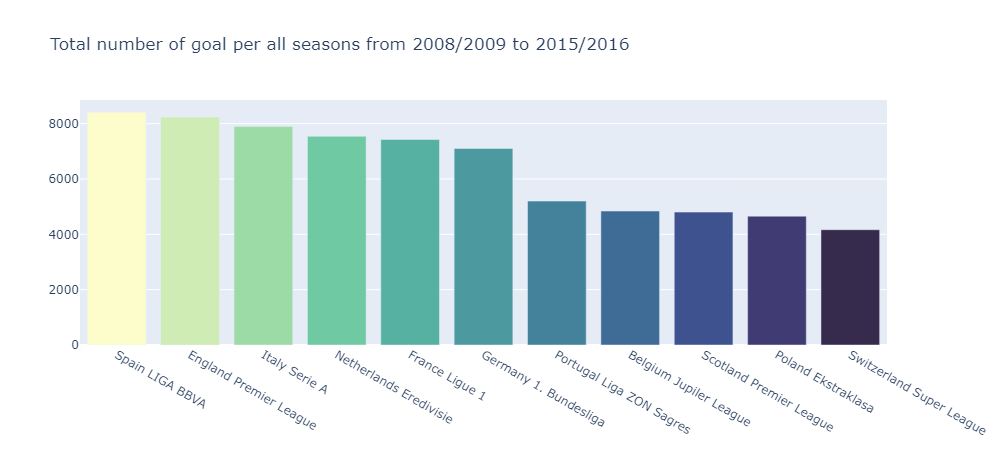

In [68]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\\bar_chart_all_scores_all_leagues.png")

The most productive league by number of goals is Spain LIGA BBVA - 8412 per 8 season, in the second place is England Premier League with 8240, then Italy Serie A with 7895 goals.
Let's check what teams scored the largest number of goals by league and what is the difference between them.

In [239]:
goal_leaders_teams_in_total = pd.read_sql(
    """WITH table_1 AS(SELECT l.name league_title, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
FROM League l
INNER JOIN Match m
ON l.id = m.league_id),

home_table AS (SELECT league_title, home_team_api_id, SUM(home_team_goal) home_goals
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_table AS (SELECT league_title, away_team_api_id, SUM(away_team_goal) away_goals
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

total_table AS(SELECT h.league_title league_title, h.home_team_api_id team_api_id, t.team_long_name team_title, h.home_goals+a.away_goals total_goals
FROM home_table h
INNER JOIN away_table a
ON h.league_title = a.league_title AND h.home_team_api_id = a.away_team_api_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1,2
ORDER BY 1,4),

rank_table AS (SELECT *, rank() over(PARTITION BY league_title ORDER BY total_goals DESC) rank_number
FROM total_table),

last as(SELECT *
FROM rank_table
WHERE rank_number <=2)

SELECT league_title||','|| team_title league_team, total_goals, rank_number
FROM last;""",
    football_sql,
)
goal_leaders_teams_in_total.head()

league_team  total_goals  rank_number
0   Belgium Jupiler League,RSC Anderlecht          427            1
1   Belgium Jupiler League,Club Brugge KV          421            2
2  England Premier League,Manchester City          606            1
3          England Premier League,Chelsea          583            2
4      France Ligue 1,Paris Saint-Germain          568            1

In [241]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=goal_leaders_teams_in_total.league_team,
        y=goal_leaders_teams_in_total.total_goals,
        marker_color="rgb(206, 236, 179)",
    )
)

fig.update_layout(
    title="Best teams by goals in each of observed football leagues in season from 2008 to 2016",
    barmode="group",
    bargap=0.15,  # gap between bars of adjacent location coordinates.
    bargroupgap=0.1,  # gap between bars of the same location coordinate.
)
fig.show()

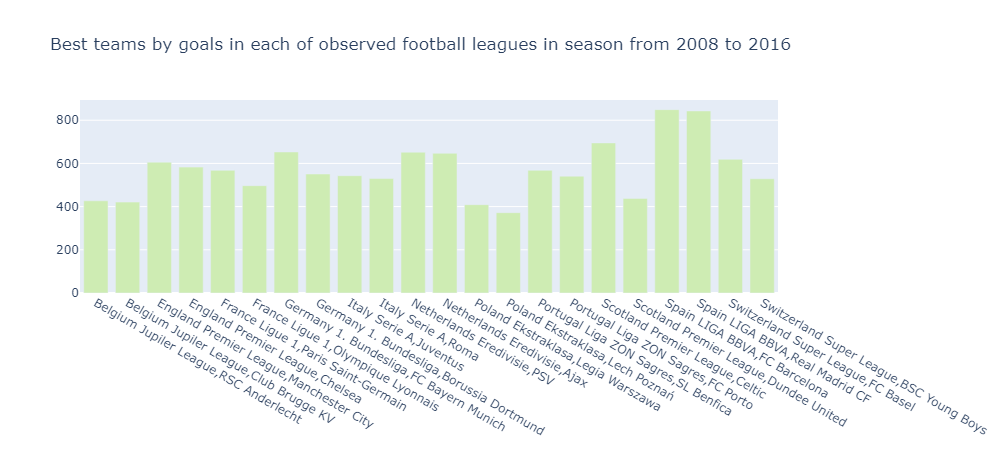

In [71]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\goals_by_leagues.png")

So, as we see here, the best teams by total scored goals in all 8 observed season are in Spain LIGA BBVA FC Barcelona (849) and Real Madrid CF (843). All other football clubs are quite far away from these leaders: Celtic from Scotland Premier League - 695, FC Bayern Munich from Germany 1. Bundesliga - 653.

**Conclusion**

I also want to mention, that spanish clubs have the highest number of victories (19 wins), followed by England (14 wins) and Italy (12 wins) in the UEFA Champions League. England has the largest number of winning teams, with five clubs having won the title. Real Madrid is the most successful club in the tournament's history, having won it 14 times, including the first five seasons and also five of the last nine. Real Madrid is the current European champions, having beaten Liverpool 1–0 in the 2022 final, [more here](https://en.wikipedia.org/wiki/UEFA_Champions_League). Also spanish clubs have the highest number of victories (13 wins), followed by teams from England and Italy (9 wins each) in UEFA Cup, [more here](https://en.wikipedia.org/wiki/UEFA_Europa_League). 

Having all that in mind for further exploratory analysis I chose Spain LIGA BBVA and England Premier League, as these two leagues are strongest by all mentioned factors and can help to bring out and highlight the main important features to set the basis for betting company in predicting game results.

## 2.2. SPAIN LIGA BBVA and ENGLAND Premier League

### 2.2.1. Winners in SPAIN LIGA BBVA and ENGLAND Premier League

First of all let's see who are the winners in each of those leagues by season.

In [244]:
winner_spain_england = pd.read_sql(
    """WITH spain_england_table AS(
    SELECT m.country_id, 
            m.season as season, 
            l.name league_name, 
            m.home_team_api_id, 
            m.away_team_api_id,
            m.home_team_goal, 
            m.away_team_goal,
            CASE WHEN home_team_goal >  away_team_goal THEN 3
            WHEN  home_team_goal = away_team_goal THEN 1
            ELSE 0 END AS home_team_points,
            CASE WHEN  home_team_goal < away_team_goal THEN 3
            WHEN  home_team_goal = away_team_goal THEN 1
            ELSE 0 END AS away_team_points
    FROM Match m
    INNER JOIN League l
    ON l.country_id = m.country_id AND (league_id = 21518 OR league_id = 1729)),

    home_scores AS (SELECT season, league_name, home_team_api_id, SUM(home_team_points) home_scores
    FROM spain_england_table
    GROUP BY 1, 2, 3),

    away_scores AS(SELECT season, league_name, away_team_api_id, SUM(away_team_points) away_scores
    FROM spain_england_table
    GROUP BY 1, 2, 3),

    total_scores AS(SELECT h.season season, h.league_name, h.home_team_api_id team_api_id,  t.team_long_name team_title, t.team_short_name, (h.home_scores+a.away_scores) total_score
    FROM home_scores h
    LEFT JOIN away_scores a
    ON h.season = a.season AND h.league_name = a.league_name AND h.home_team_api_id=a.away_team_api_id
    INNER JOIN Team t
    ON h.home_team_api_id = t.team_api_id
    GROUP BY 1, 2, 3),

    rank_table AS(SELECT *, rank() over(partition by season, league_name order by total_score DESC) as rank
    FROM total_scores)

    SELECT season, league_name, team_title, team_short_name, total_score
    FROM rank_table
    WHERE rank =1;""",
    football_sql,
)
winner_spain_england.head()

season             league_name         team_title team_short_name  \
0  2008/2009  England Premier League  Manchester United             MUN   
1  2008/2009         Spain LIGA BBVA       FC Barcelona             BAR   
2  2009/2010  England Premier League            Chelsea             CHE   
3  2009/2010         Spain LIGA BBVA       FC Barcelona             BAR   
4  2010/2011  England Premier League  Manchester United             MUN   

   total_score  
0           90  
1           87  
2           86  
3           99  
4           80

In [250]:
fig = px.line(
    winner_spain_england,
    x="season",
    y="total_score",
    color="league_name",
    text="team_short_name",
)
fig.update_traces(textposition="top left")
fig.show()

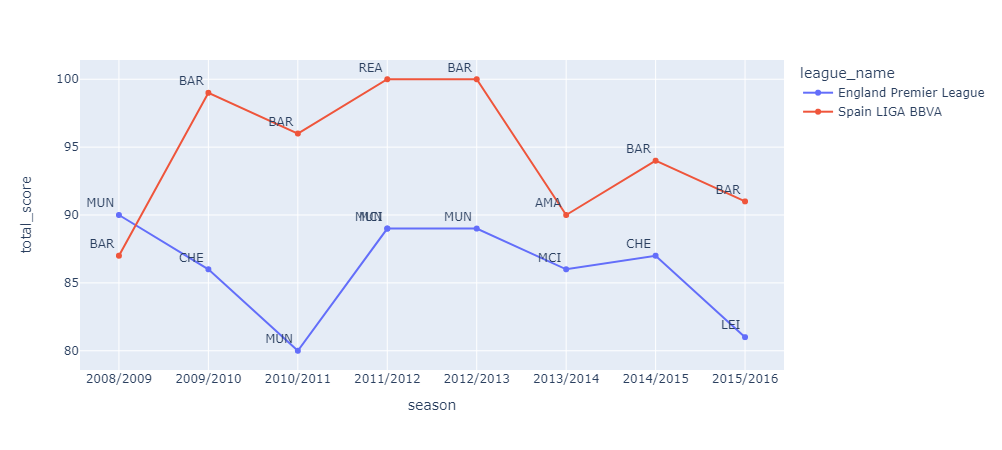

In [74]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\winner_linechart.png")

In [75]:
winner_spain_england['team_title'].value_counts()

FC Barcelona         6
Manchester United    4
Chelsea              2
Manchester City      2
Real Madrid CF       1
Atlético Madrid      1
Leicester City       1
Name: team_title, dtype: int64

So as we see, In Spain LIGA BBVA from the observed 8 seasons, FB Barcelona had won 6 times,  Real Madrid, Atletico Madrid - one time per each. In England Premier League Manchester United had won 4 times, Chelsea and Manchester City - 2 times, Leicester city - 1 time. 

Spain LIGA BBVA has stronger favorite team (FC Barcelona) and in this league winner each year earns more points (having in mind that in both leagues each team plays 38 games per season and has possibility to earn the same amount of points in total). So probably the first place winner in Spain LIGA BBVA has more wins, than the winner in England Premier league. We will check that.

### 2.2.2. W(in),L(oss),D(raw) in SPAIN LIGA BBVA and ENGLAND Premier League (home/away games)

* Home win, loss and draw or in the other words: home win/away win/draw (for both) in 8 season.

In [252]:
spain_england_w_l_d = pd.read_sql(
    """WITH table1 AS(SELECT league_id, name,
match_api_id, home_team_api_id, away_team_api_id,
home_team_goal, away_team_goal,
CASE WHEN  home_team_goal >  away_team_goal THEN 1
ELSE 0 END AS home_win,
CASE WHEN  away_team_goal > home_team_goal THEN 1
ELSE 0 END AS away_win,
CASE WHEN home_team_goal = away_team_goal THEN 1
ELSE 0 END AS draw
FROM Match
INNER JOIN League
ON League.id = match.league_id AND (league_id = 21518 OR league_id=1729))


SELECT name, SUM(home_win) home_win, (SUM(home_win)*100/3040) home_win_perc, 
SUM(away_win) away_win, (SUM(away_win)*100/3040) away_win_perc, 
SUM(draw) draw, (SUM(draw)*100/3040) draw_perc, COUNT(DISTINCT(match_api_id)) total_number_of_games
FROM table1
GROUP BY name;""",
    football_sql,
)
spain_england_w_l_d

name  home_win  home_win_perc  away_win  away_win_perc  \
0  England Premier League      1390             45       867             28   
1         Spain LIGA BBVA      1485             48       851             27   

   draw  draw_perc  total_number_of_games  
0   783         25                   3040  
1   704         23                   3040

[]

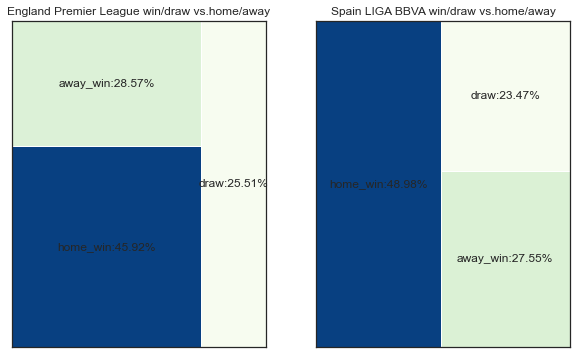

In [254]:
# Setting the needed data from df.
eng_spain = spain_england_w_l_d.drop(
    columns=["home_win", "away_win", "draw", "total_number_of_games"], axis=1
)
eng_spain = eng_spain.T
eng_spain.drop("name", axis=0, inplace=True)
eng_spain.rename(
    {0: "england_premier_league", 1: "spain_liga_bbva"}, axis=1, inplace=True
)
eng_spain.rename(
    {"home_win_perc": "home_win", "away_win_perc": "away_win", "draw_perc": "draw"},
    axis=0,
    inplace=True,
)

# Setting the color scales.
cmap = mpl.cm.GnBu
mini1, maxi1 = (
    eng_spain["england_premier_league"].min(),
    eng_spain["england_premier_league"].max(),
)
norm1 = mpl.colors.Normalize(vmin=mini1, vmax=maxi1)
colors1 = [cmap(norm1(value)) for value in eng_spain["england_premier_league"]]

mini2, maxi2 = eng_spain["spain_liga_bbva"].min(), eng_spain["spain_liga_bbva"].max()
norm2 = mpl.colors.Normalize(vmin=mini2, vmax=maxi2)
colors2 = [cmap(norm2(value)) for value in eng_spain["spain_liga_bbva"]]

# # Setting labels.
perc1 = [
    str("{:5.2f}".format(i / eng_spain["england_premier_league"].sum() * 100)) + "%"
    for i in eng_spain["england_premier_league"]
]
lbl1 = [f"{el1}:{el2}" for el1, el2 in zip(eng_spain.index, perc1)]

perc2 = [
    str("{:5.2f}".format(i / eng_spain["spain_liga_bbva"].sum() * 100)) + "%"
    for i in eng_spain["spain_liga_bbva"]
]
lbl2 = [f"{el1}:{el2}" for el1, el2 in zip(eng_spain.index, perc2)]

# # Setting the figure.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1 = squarify.plot(
    eng_spain["england_premier_league"], label=lbl1, color=colors1, ax=ax1
)
ax1.set_title("England Premier League win/draw vs.home/away")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = squarify.plot(eng_spain["spain_liga_bbva"], label=lbl2, color=colors2, ax=ax2)
ax2.set_title("Spain LIGA BBVA win/draw vs.home/away")
ax2.set_xticks([])
ax2.set_yticks([])

In total 8 years of observations, mostly teams win at home (from 45 to 48 percent), the other part divides almost in halves of away (quest team) win and draw. Let's see does it differ by season or the proportion of home/away wins is almost the same.

* **Inferential statistical analysis of two proportions: home win vs. away win in Spain LIGA BBVA and England Premier League**

I selected games (in all 8 seasons) from the first round (stage: 1-19) and checked, how many home teams had won in the first round. Then I selected the second round of the games (stage 20-38) and checked how many away teams had won there. In this way I got two independent  samples and could check if the difference in home and away wins is significant.

In [256]:
first_round_home_wins = pd.read_sql(
    """WITH table_1 AS(SELECT league_id, name, stage,
match_api_id, home_team_api_id, away_team_api_id,
home_team_goal, away_team_goal,
CASE WHEN  home_team_goal >  away_team_goal THEN 1
ELSE 0 END AS home_win,
CASE WHEN  away_team_goal > home_team_goal THEN 1
ELSE 0 END AS away_win,
CASE WHEN home_team_goal = away_team_goal THEN 1
ELSE 0 END AS draw
FROM Match
INNER JOIN League
ON League.id = match.league_id AND (league_id = 21518 OR league_id=1729))


SELECT name, SUM(home_win) home_win, COUNT(DISTINCT(match_api_id)) total_number_of_games
FROM table_1
WHERE stage BETWEEN 1 and 19
GROUP BY name;""",
    football_sql,
)
first_round_home_wins

name  home_win  total_number_of_games
0  England Premier League       666                   1520
1         Spain LIGA BBVA       731                   1520

In [258]:
second_round_away_wins = pd.read_sql(
    """WITH table_1 AS(SELECT league_id, name, stage,
match_api_id, home_team_api_id, away_team_api_id,
home_team_goal, away_team_goal,
CASE WHEN  home_team_goal >  away_team_goal THEN 1
ELSE 0 END AS home_win,
CASE WHEN  away_team_goal > home_team_goal THEN 1
ELSE 0 END AS away_win,
CASE WHEN home_team_goal = away_team_goal THEN 1
ELSE 0 END AS draw
FROM Match
INNER JOIN League
ON League.id = match.league_id AND (league_id = 21518 OR league_id=1729))


SELECT name, SUM(away_win) away_win, COUNT(DISTINCT(match_api_id)) total_number_of_games
FROM table_1
WHERE stage BETWEEN 20 and 38
GROUP BY name;""",
    football_sql,
)
second_round_away_wins

name  away_win  total_number_of_games
0  England Premier League       425                   1520
1         Spain LIGA BBVA       408                   1520

In [260]:
spain_table = pd.DataFrame(
    {
        "win_proportions": [731 / 1520, 408 / 1520],
        "number_of_all_games": [1520, 1520],
        "number of wins": [731, 408],
    },
    index=["home_win", "away_win"],
)
spain_table

win_proportions  number_of_all_games  number of wins
home_win             0.48                 1520             731
away_win             0.27                 1520             408

In [81]:
england_table = pd.DataFrame(
    {
        "win_proportions": [666/1520, 425/1520],
        "number_of_all_games": [1520, 1520],
        "number of wins": [666, 425]
    },
    index=["home_win", "away_win"],
)
england_table

win_proportions  number_of_all_games  number of wins
home_win             0.44                 1520             666
away_win             0.28                 1520             425

**Research question**

Is the difference in Spain League BBVA and in England Premier League in observed 8 seasons of football games wins playing at home (in the first round of the games) and football games wins playing in the quest field (away) (in the second round of the games) statistically significant?

**Population** All football games, played in Spain LIGA BBVA from season 2009 to season 2016: 3040.

Football games, played in the home field - first round of both leagues = 1520 

Football games played at away field - second round of both leagues = 1520

**Parameter of interest** 
Difference in population proportions: Spain: (p(1) - p(2)) -> 0.48 - 0.27 = 0.21
                                      England (p(1) - p(2)) -> 0.44-0.28 = 0.16

**Power of the test** ($1 - \beta$) - 0.8 

**Significance level**: 0.05

**Null Hypothesis:** p1 - p2 = 0  (there is no difference)

**Alternative Hypothesis:** p1 - p2 > 0

One tail testing, home wins are larger so the difference is >0

**Assumptions**:
1. Our samples are independent from each other (taken in different rounds of the games, different dates, different play fields).

* Preliminary power test analysis, to get the needed sample size to avoid p-hacking.

In [262]:
spain_effect_size = sms.proportion_effectsize(
    0.48, 0.27
)  # Calculating effect size based on our expected rates
england_effect_size = sms.proportion_effectsize(0.44, 0.28)

spain_required_n = sms.NormalIndPower().solve_power(
    spain_effect_size, power=0.8, alpha=0.05, ratio=1
)  # Calculating sample size needed
england_required_n = sms.NormalIndPower().solve_power(
    england_effect_size, power=0.8, alpha=0.05, ratio=1
)
spain_required_n = ceil(spain_required_n)  # Rounding up to next whole number
england_required_n = ceil(spain_required_n)
print(
    f"Spain required sample size:{spain_required_n} \n England required sample size: {england_required_n}"
)

Spain required sample size:82 
 England required sample size: 82


The needed samples sizes to avoid p-hacking - 82 in both cases, I got 1520 per each, so its ok. P-hacking should be avoided.

**Calculations**

In [263]:
# Spain.
p_comb = (731+408)/3040 # the mean of all wins
va = p_comb * (1 - p_comb)
se = np.sqrt(va * (1 / 1520 + 1 / 1520))

# Calculate the test statistic and its p-value
test_stat = (0.48 - 0.27) / se
pvalue = 2 * dist.norm.cdf(-np.abs(test_stat))
print(f"Spain home win vs. away win: T-statistics: {test_stat}, p-value: {pvalue}")

Spain home win vs. away win: T-statistics: 11.960428908665094, p-value: 5.726536780123008e-33


In [264]:
# England

p_comb = (666+425)/3040 # the mean of all wins
va = p_comb * (1 - p_comb)
se = np.sqrt(va * (1 / 1520 + 1 / 1520))

# Calculate the test statistic and its p-value
test_stat = (0.44 - 0.28) / se
pvalue = 2 * dist.norm.cdf(-np.abs(test_stat))
print(f"England home win vs. away win: T-statistics: {test_stat}, p-value: {pvalue}")

England home win vs. away win: T-statistics: 9.19564226159981, p-value: 3.727610266855476e-20


**Conclusion**

The difference of the proportions of home wins vs. away wins was quite large in both investigated leagues: Spain - 0.21, England - 0.16. The aim was to check is this difference statistically significant, or maybe made by a chance. 
From this observed data we got, that the T -statistics in SPAIN LIGA BBVA in the difference of two proportions is very large 11.96, so our observed difference in sample proportions is 11.96 estimated standard errors above our hypothesized mean (0) of equal population proportions. Based on our sample and our p-value in SPAIN 5.726536780123008e-33, that is almost equal to 0 and is smaller than our set alpha value of 0.05, we have enough evidence to reject the null hypothesis. 
The same situation is in England Premier League, where T-statistics: 9.199, that means, that our observed difference in sample proportions is 9.19 estimated standard errors above our hypothesized mean (0) of equal population proportions (of home/away wins). The p-value in England is also almost equal to 0, smaller than alpha of 0.05, so we have enough evidence to reject the null hypothesis.

In this case, we conclude that there is significant difference between the population proportions of home and away wins in football games, played in England Premier League and Spain LIGA BBVA in 8 seasons. 
Let's check the Confidence interval.

**Confidence intervals**

1. Confidence level of 95%.
2. Significant level alpha = 0.05

In [266]:
# SPAIN Standard error
spain_p = 0.48  # Home win proportion
england_p = 0.44
spain_n = 1520  # Total number of game home field
england_n = 1520
spain_se_home_win = np.sqrt(spain_p * (1 - spain_p) / spain_n)
england_se_home_win = np.sqrt(england_p * (1 - england_p) / england_n)

print(f"Spain {spain_se_home_win}")
print(f"England {england_se_home_win}")

spain_p = 0.27  # Away win proportion
england_p = 0.28
spain_n = 1520  # Total number of away field
england_n = 1520
spain_se_away_win = np.sqrt(spain_p * (1 - spain_p) / spain_n)
england_se_away_win = np.sqrt(england_p * (1 - england_p) / england_n)

print(f"Spain {spain_se_away_win}")
print(f"England {england_se_away_win}")

Spain 0.012814465510343749
England 0.012732056517228266
Spain 0.011387319817743723
England 0.011516578439248717


In [267]:
spain_se_diff = np.sqrt(spain_se_home_win**2 + spain_se_away_win**2)
england_se_diff = np.sqrt(england_se_home_win**2 + england_se_away_win**2)

print(f'Spain standard error diff: {spain_se_diff} \n England standard error diff: {england_se_diff}')

Spain standard error diff: 0.0171429746236576 
 England standard error diff: 0.017167901505579043


In [268]:
spain_d = 0.21
england_d = 0.16
spain_lcb = spain_d - 2*spain_se_diff
spain_ucb = spain_d + 2*spain_se_diff
england_lcb = england_d - 2*england_se_diff
england_ucb = england_d + 2*england_se_diff
print(f'Spain CI in difference home/away wins: {spain_lcb, spain_ucb}')
print(f'England CI in difference home/away wins: {england_lcb, england_ucb}')

Spain CI in difference home/away wins: (0.1757140507526848, 0.2442859492473152)
England CI in difference home/away wins: (0.1256641969888419, 0.1943358030111581)


The 95% confidence interval above shows us that any value for the difference of population proportions (between home and away wins) in SPAIN LIGA BBVA is lying between 0.1757 and 0.2442, in England Premier League between: 0.1256 and 0.1943, this is consistent with the observed data, and our estimated differences were 0.21 in Spain and 0.16 in England (home wins advantage), which is in that range. 0 in not in these ranges, so the null hypothesis, that the difference between proportions of home and away wins could be 0 was rejected correctly.

* Now, when we are convinced that  there is a home advantage in total period of 8 season, let's see the home/away wins by season. Maybe they were different?

In [270]:
home_away_win_season = pd.read_sql(
    """WITH table_1 AS (
SELECT season, name, 
match_api_id, home_team_api_id, away_team_api_id,
home_team_goal, away_team_goal,
CASE WHEN  home_team_goal >  away_team_goal THEN 1
ELSE 0 END AS home_win,
CASE WHEN  away_team_goal > home_team_goal THEN 1
ELSE 0 END AS away_win,
CASE WHEN home_team_goal = away_team_goal THEN 1
ELSE 0 END AS draw
FROM Match
INNER JOIN League
ON League.id = match.league_id AND (league_id = 21518 OR league_id=1729)
ORDER BY season)

SELECT season, name, SUM(home_win) home_win, (SUM(home_win)*100/380) home_win_percentage, SUM(away_win) away_win, (SUM(away_win)*100/380) away_win_percentage, SUM(draw) draw, (SUM(draw)*100/380) draw_percentage, COUNT(*) total_number_of_games
FROM table_1
GROUP BY season, name;""",
    football_sql,
)
home_away_win_season.head()

season                    name  home_win  home_win_percentage  away_win  \
0  2008/2009  England Premier League       173                   45       110   
1  2008/2009         Spain LIGA BBVA       184                   48       113   
2  2009/2010  England Premier League       193                   50        91   
3  2009/2010         Spain LIGA BBVA       194                   51        91   
4  2010/2011  England Premier League       179                   47        90   

   away_win_percentage  draw  draw_percentage  total_number_of_games  
0                   28    97               25                    380  
1                   29    83               21                    380  
2                   23    96               25                    380  
3                   23    95               25                    380  
4                   23   111               29                    380

In [272]:
fig = px.line(
    home_away_win_season,
    x="season",
    y=["home_win", "away_win", "draw"],
    markers=True,
    facet_col="name",
)
fig.update_yaxes(title="Number of games")
fig.update_xaxes(title="")
fig.update_layout(legend_title="", title="W/D by league, season, home/away")
fig.show()

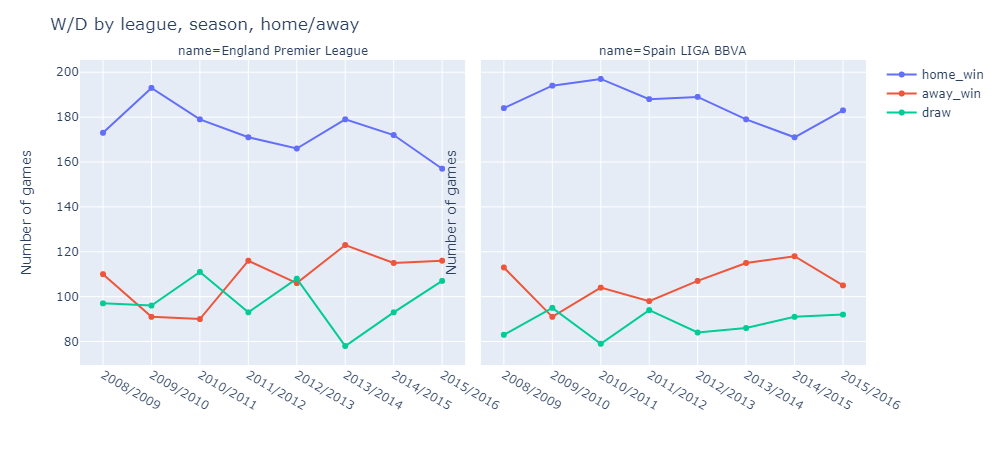

In [90]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\win_loss_draw_season.png")

In both leagues, we see that more games had been won by the home team each season. But in England Premier league that number was dropping from the season 2009/2010 (when almost 200 games out of 380 were won by the home team), it had one peak in 2013/2014 (179 games won by home team), but is seems that this number is getting closer with the away team win (home loss). So the advantage of home field to play is getting smaller and it seems that teams are more competetive and doesn't care so much where they play.
Almost the same situation was in Spain (just with higher number of home wins), but in 2015/2016 it seems that home team wins got higher while away team win got lower and the difference arose. So it seems that we can count on home field advantage more thant in England Premier League.

And in percentages it looks like this.

In [274]:
spain_home_away_win_season = home_away_win_season.where(
    home_away_win_season["name"] == "Spain LIGA BBVA"
)
spain_home_away_win_season.dropna(inplace=True)
spain_home_away_win_season

england_home_away_win_season = home_away_win_season.where(
    home_away_win_season["name"] == "England Premier League"
)
england_home_away_win_season.dropna(inplace=True)
england_home_away_win_season

fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Spain LIGA BBVA", "England Premier League"),
    shared_xaxes=True,
)

fig.add_trace(
    go.Bar(
        x=spain_home_away_win_season.season,
        y=spain_home_away_win_season.home_win_percentage,
        name="Home wins %",
        marker_color="rgb(206, 236, 179)",
        legendgroup="1",
    ),
    1,
    1,
)
fig.add_trace(
    go.Bar(
        x=spain_home_away_win_season.season,
        y=spain_home_away_win_season.away_win_percentage,
        name="Away win %",
        marker_color="rgb(156, 219, 165)",
        legendgroup="1",
    ),
    1,
    1,
)
fig.add_trace(
    go.Bar(
        x=spain_home_away_win_season.season,
        y=spain_home_away_win_season.draw_percentage,
        name="Draw %",
        marker_color="rgb(111, 201, 163)",
        legendgroup="1",
    ),
    1,
    1,
)

fig.add_trace(
    go.Bar(
        x=england_home_away_win_season.season,
        y=england_home_away_win_season.home_win_percentage,
        name="Home wins %",
        marker_color="rgb(206, 236, 179)",
        legendgroup="2",
    ),
    2,
    1,
)
fig.add_trace(
    go.Bar(
        x=england_home_away_win_season.season,
        y=england_home_away_win_season.away_win_percentage,
        name="Away win %",
        marker_color="rgb(156, 219, 165)",
        legendgroup="2",
    ),
    2,
    1,
)
fig.add_trace(
    go.Bar(
        x=england_home_away_win_season.season,
        y=england_home_away_win_season.draw_percentage,
        name="Draw %",
        marker_color="rgb(111, 201, 163)",
        legendgroup="2",
    ),
    2,
    1,
)

fig.update_layout(
    title="Percentage of football game W/D by home, away",
    barmode="group",
    bargap=0.15,  # gap between bars of adjacent location coordinates.
    bargroupgap=0.1,  # gap between bars of the same location coordinate.
    legend_tracegroupgap=180,
)
fig.show()

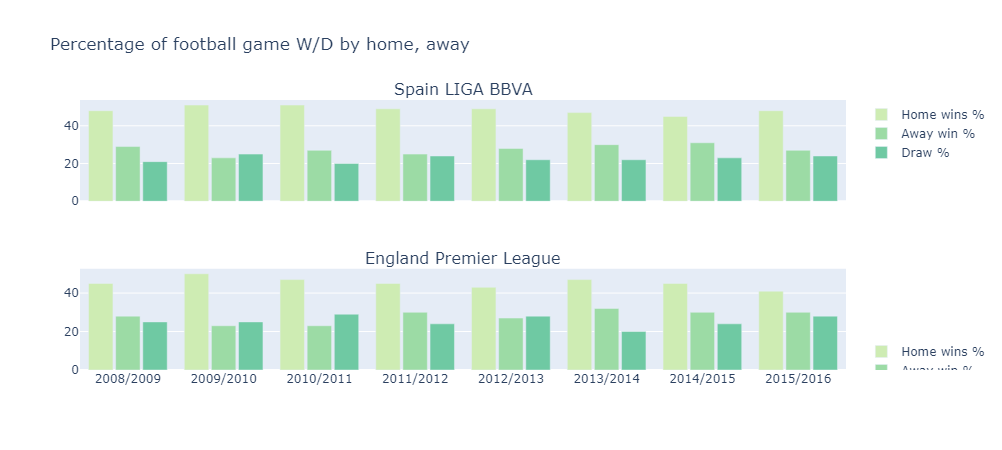

In [92]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\percentage_win_loss_draw.png")

In each of the observed football seasons teams, that played in Spain LIGA BBVA, were quite consistent and from 45 to 51 % of the games had won the home team, from 25 to 31 % had won the quest team (so home team loss) and the rest games finished with draw.So observing by season, we can say that there's home advantage.

* The last point, I would like to check, how many w/l/d had in each season the best three teams from Spain and England Leagues, that had won these leagues the most times or scores most goals: Spain LIGA BBVA - Barcelona, Real Madrid and Atletico Madrid, England - Manchester United, Chelsea and Manchester City. Maybe that could help in predicting results, using older season number of wins/loss/draw like a feature.

In [275]:
win_loss_draw_best_teams = pd.read_sql("""WITH table_1 AS(SELECT m.country_id, 
m.season as season, 
l.name league_name, 
m.home_team_api_id, 
m.away_team_api_id,
m.home_team_goal, 
m.away_team_goal,
CASE WHEN home_team_goal >  away_team_goal THEN 1
ELSE 0 END AS home_win,
CASE WHEN  home_team_goal < away_team_goal THEN 1
ELSE 0 END AS home_loss,
CASE WHEN  home_team_goal = away_team_goal THEN 1
ELSE 0 END AS home_draw,
CASE WHEN away_team_goal > home_team_goal THEN 1
ELSE 0 END AS away_win,
CASE WHEN   away_team_goal < home_team_goal THEN 1
ELSE 0 END AS away_loss,
CASE WHEN  home_team_goal = away_team_goal THEN 1
ELSE 0 END AS away_draw
FROM Match m
INNER JOIN League l
ON l.country_id = m.country_id AND (league_id = 21518 OR league_id = 1729)
WHERE m.home_team_api_id IN (8633, 8634, 9906, 10260, 8455, 8456) OR m.away_team_api_id IN (8633, 8634, 9906, 10260, 8455, 8456)),

home_table AS(SELECT season, league_name, home_team_api_id, SUM(home_win) home_wins, SUM(home_loss) home_losses, SUM(home_draw) home_draws
FROM table_1
WHERE home_team_api_id IN (8633, 8634, 9906, 10260, 8455, 8456)
GROUP BY 1,2,3),

away_table AS(SELECT season, league_name, away_team_api_id, SUM(away_win) away_wins, SUM(away_loss) away_losses, SUM(away_draw) away_draws
FROM table_1
WHERE away_team_api_id IN (8633, 8634, 9906, 10260, 8455, 8456)
GROUP BY 1,2,3)

SELECT ht.season, ht.league_name, t.team_long_name team_title, (ht.home_wins+at.away_wins) win, (ht.home_losses+at.away_losses) loss, (ht.home_draws+at.away_draws) draws
FROM home_table ht
INNER JOIN away_table at 
ON ht.season = at.season AND ht.league_name=at.league_name AND ht.home_team_api_id = at.away_team_api_id
INNER JOIN Team t
ON ht.home_team_api_id=t.team_api_id;""", football_sql)
win_loss_draw_best_teams.head()

season             league_name         team_title  win  loss  draws
0  2008/2009  England Premier League            Chelsea   25     5      8
1  2008/2009  England Premier League    Manchester City   15    18      5
2  2008/2009  England Premier League  Manchester United   28     4      6
3  2008/2009         Spain LIGA BBVA     Real Madrid CF   25    10      3
4  2008/2009         Spain LIGA BBVA       FC Barcelona   27     5      6

In [277]:
fig = px.line(
    win_loss_draw_best_teams,
    x="season",
    y=["win", "loss", "draws"],
    markers=True,
    facet_col="team_title",
    facet_col_wrap=2,
)
fig.update_yaxes(title="")
fig.update_xaxes(title="")
fig.update_layout(legend_title="", title="W/D by league, season, home/away")
fig.show()

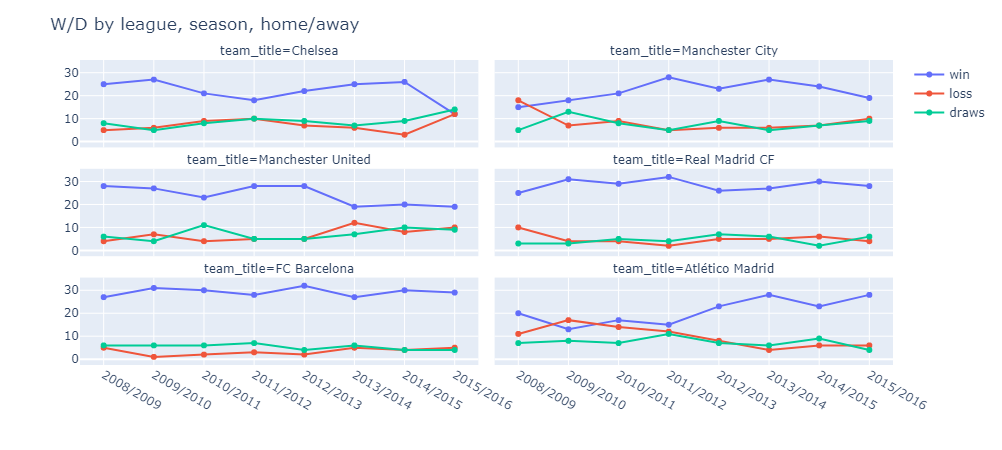

In [95]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\\best_teams_win_loss.png")

From the first glance seems that Real Madrid CF and FC Barcelona are very consistent and each year delivers almost the same number of wins/loss/draws. Atletico Madrid was very inconsistent and had some downs from 2008 to 2011/2012, but then the number of wins started to grow and exactly in the season of 2013/2014 it won the Spain LIGA BBVA. In England the situation is quite mixed, Manchester United is having some decrease in winning from 2013 and we see that in the winners table, as this team doesn't deliver win in the league from the season of 2012/2013. Chelsea and Manchester city is also decreasing in the last year. So especially in the England Premier League we may see some patterns of decrease and increase in wins, that last for more than one season, some up's and down's.

### 2.2.3. Goals in SPAIN LIGA BBVA and ENGLAND Premier League

#### 2.2.3.1. Number of goals by each league by season.

In [279]:
goals_by_season_spain_england = pd.read_sql(
    """SELECT l.name league_title, m.season season, 
(SUM(m.home_team_goal) + SUM(m.away_team_goal)) as total_goals 
FROM "League" l
INNER JOIN Match m
ON l.id = m.league_id AND (m.league_id = 1729 OR m.league_id = 21518)
GROUP BY league_title, season
ORDER BY league_title, season;""",
    football_sql,
)
goals_by_season_spain_england.head()

league_title     season  total_goals
0  England Premier League  2008/2009          942
1  England Premier League  2009/2010         1053
2  England Premier League  2010/2011         1063
3  England Premier League  2011/2012         1066
4  England Premier League  2012/2013         1063

In [281]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=goals_by_season_spain_england.season[:8],
        y=goals_by_season_spain_england.total_goals[:8],
        name="England Premier League",
        marker_color="rgb(111, 201, 163)",
    )
)
fig.add_trace(
    go.Bar(
        x=goals_by_season_spain_england.season[8:],
        y=goals_by_season_spain_england.total_goals[8:],
        name="Spain LIGA BBVA",
        marker_color="rgb(62, 82, 143)",
    )
)
fig.update_layout(
    barmode="group", xaxis_tickangle=-45, title="Total number of goals by season"
)
fig.show()

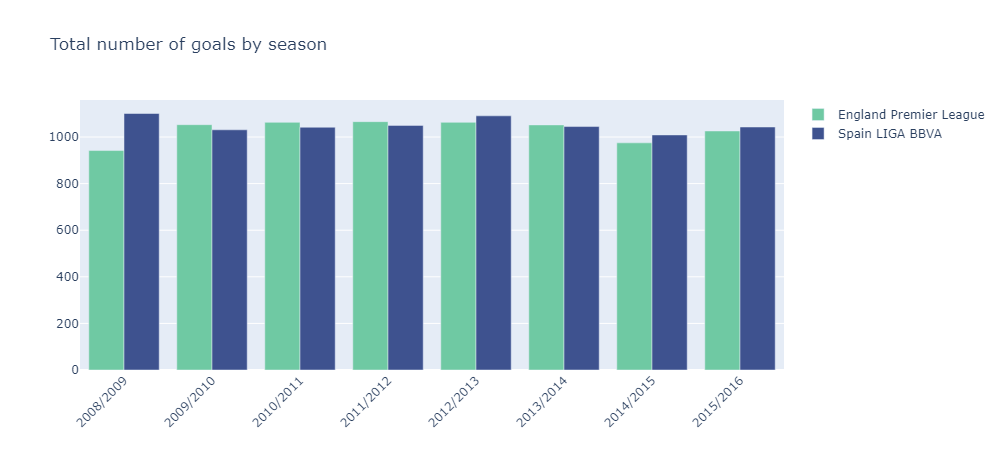

In [98]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\goals_by_season_league.png")

As we may see both leagues in number of goals by season goes very close to each other and scores about 1000 goals per season. In England Premier League the worst season in number of total goals was 2008/2009 (with 942 goals and 2014/2015 with 975), best season 2011/2012 - 1066 goals. In Spain LIGA BBVA the worst season was 2014/2015 with 1009 goals in total per this season, best - 2008/2009 season - 1101. Lets see what teams scores most goals.

#### 2.2.3.2. Number of goals by teams in leagues and season.

**Spain LIGA BBVA**

Goals for and gainst.

In [284]:
best_worst_spain_teams_goals_for = pd.read_sql(
    """WITH table_1 AS(SELECT season season, 
home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
FROM Match 
WHERE league_id = 21518
ORDER BY season),

home_score_table AS (SELECT season, home_team_api_id, SUM(home_team_goal) home_goals_for
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

home_against_table AS (SELECT season, home_team_api_id, SUM(away_team_goal) home_goals_against
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_score_table AS (SELECT season, away_team_api_id, SUM(away_team_goal) away_goals_for
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_against_table AS (SELECT season, away_team_api_id, SUM(home_team_goal) away_goals_against
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

total_table AS(SELECT h.season, h.home_team_api_id team_api_id,  
t.team_long_name team_long_name, h.home_goals_for, a.away_goals_for, h.home_goals_for+a.away_goals_for total_goals_for, ha.home_goals_against, aa.away_goals_against, ha.home_goals_against+aa.away_goals_against total_goals_against
FROM home_score_table h
LEFT JOIN away_score_table a
ON h.season = a.season AND h.home_team_api_id = a.away_team_api_id
INNER JOIN home_against_table ha 
ON h.season = ha.season AND h.home_team_api_id = ha.home_team_api_id
INNER JOIN away_against_table aa 
ON h.season = aa.season AND h.home_team_api_id = aa.away_team_api_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1,2
ORDER BY 1,4),

rank_table AS (SELECT *, rank() over(PARTITION BY season ORDER BY total_goals_for DESC) rank_number_goals_for
FROM total_table)

SELECT season, team_long_name team_title, total_goals_for,  total_goals_against, rank_number_goals_for
FROM rank_table
WHERE rank_number_goals_for <= 3 OR rank_number_goals_for = 20
""",
    football_sql,
)
best_worst_spain_teams_goals_for.head()

season       team_title  total_goals_for  total_goals_against  \
0  2008/2009     FC Barcelona              105                   35   
1  2008/2009   Real Madrid CF               83                   52   
2  2008/2009  Atlético Madrid               80                   57   
3  2008/2009    RC Recreativo               34                   57   
4  2009/2010   Real Madrid CF              102                   35   

   rank_number_goals_for  
0                      1  
1                      2  
2                      3  
3                     20  
4                      1

In [286]:
fig = px.scatter(
    best_worst_spain_teams_goals_for,
    x="season",
    y="total_goals_for",
    color="team_title",
    size="total_goals_for",
    symbol="team_title",
    hover_data=["rank_number_goals_for"],
    color_discrete_sequence=[
        "rgb(253, 253, 204)",
        "rgb(206, 236, 179)",
        "rgb(156, 219, 165)",
        "rgb(111, 201, 163)",
        "rgb(86, 177, 163)",
        "rgb(76, 153, 160)",
        "rgb(68, 130, 155)",
        "rgb(62, 108, 150)",
        "rgb(62, 82, 143)",
        "rgb(64, 60, 115)",
        "rgb(54, 43, 77)",
        "rgb(39, 26, 44)",
    ],
    labels={"team_title": "Team title:"},
)
fig.update_layout(
    title="Best and worst teams by total number of scored goals in SPAIN LIGA BBVA"
)
fig.show()

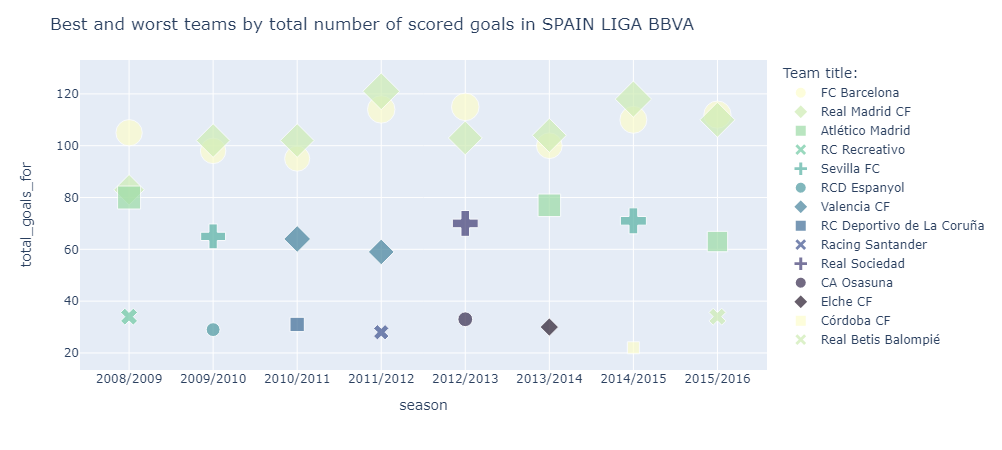

In [101]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\spain_goals_for_against.png")

In [288]:
best_worst_spain_teams_goals_against = pd.read_sql(
    """WITH table_1 AS(SELECT season season, 
home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
FROM Match 
WHERE league_id = 21518
ORDER BY season),

home_score_table AS (SELECT season, home_team_api_id, SUM(home_team_goal) home_goals_for
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

home_against_table AS (SELECT season, home_team_api_id, SUM(away_team_goal) home_goals_against
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_score_table AS (SELECT season, away_team_api_id, SUM(away_team_goal) away_goals_for
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_against_table AS (SELECT season, away_team_api_id, SUM(home_team_goal) away_goals_against
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

total_table AS(SELECT h.season, h.home_team_api_id team_api_id,  
t.team_long_name team_long_name, h.home_goals_for, a.away_goals_for, h.home_goals_for+a.away_goals_for total_goals_for, ha.home_goals_against, aa.away_goals_against, ha.home_goals_against+aa.away_goals_against total_goals_against
FROM home_score_table h
LEFT JOIN away_score_table a
ON h.season = a.season AND h.home_team_api_id = a.away_team_api_id
INNER JOIN home_against_table ha 
ON h.season = ha.season AND h.home_team_api_id = ha.home_team_api_id
INNER JOIN away_against_table aa 
ON h.season = aa.season AND h.home_team_api_id = aa.away_team_api_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1,2
ORDER BY 1,4),

rank_table AS (SELECT *, rank() over(PARTITION BY season ORDER BY total_goals_against ASC) rank_number_goals_against
FROM total_table)

SELECT season, team_long_name team_title, total_goals_for,  total_goals_against, rank_number_goals_against
FROM rank_table
WHERE rank_number_goals_against <= 3 OR rank_number_goals_against = 20;""",
    football_sql,
)
best_worst_spain_teams_goals_against.head()

season                 team_title  total_goals_for  total_goals_against  \
0  2008/2009               FC Barcelona              105                   35   
1  2008/2009                 Sevilla FC               54                   39   
2  2008/2009                 CA Osasuna               41                   47   
3  2008/2009  RC Deportivo de La Coruña               48                   47   
4  2008/2009     Real Sporting de Gijón               47                   79   

   rank_number_goals_against  
0                          1  
1                          2  
2                          3  
3                          3  
4                         20

In [290]:
fig = px.scatter(
    best_worst_spain_teams_goals_against,
    x="season",
    y="total_goals_against",
    color="team_title",
    size="total_goals_against",
    hover_data=["rank_number_goals_against"],
    color_discrete_sequence=[
        "rgb(253, 253, 204)",
        "rgb(206, 236, 179)",
        "rgb(156, 219, 165)",
        "rgb(111, 201, 163)",
        "rgb(86, 177, 163)",
        "rgb(76, 153, 160)",
        "rgb(68, 130, 155)",
        "rgb(62, 108, 150)",
        "rgb(62, 82, 143)",
        "rgb(64, 60, 115)",
        "rgb(54, 43, 77)",
        "rgb(39, 26, 44)",
    ],
    labels={"team_title": "Team title:"},
)
fig.update_layout(
    title="Best and worst teams by total number of goals against each other in SPAIN LIGA BBVA"
)
fig.show()

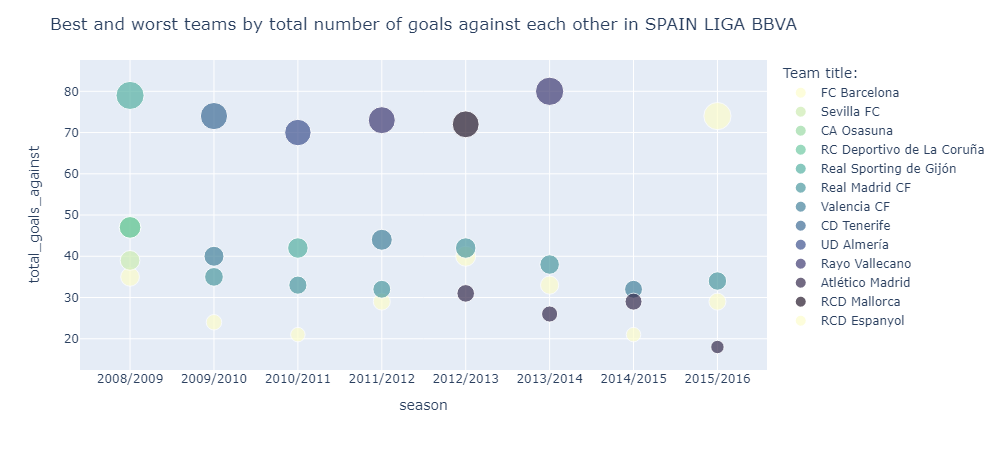

In [104]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\goals_against_spain.png")

As we see FC Barcelona and Real Madrid CF are the top two scorers in each season. I took the third and the last places, just to show, how big is the difference in goals from first two teams and all the others, and it doesn't even get closer year by year, for example, not depending on which team is in the third place by total goals.
From the second scatter plot we see, that Barcelona is the team with lowest number of goals scored against it every season. Then by season we see some changes in it, for example in 2008/2009 Sevilla FC showed good results in defense and got into the top 3 by lowest number of goals against it. Then from 2009 to 2014 Real Madrid also was one of the three teams with the lowest scored goals against. But we obviously see that Atletico Madrid from 2012 has improved a lot in this sphere and is in the first-second place by scored goals against it. Also Atletico Madrid is the team, that in 2015/2016 got the lowest scored goals against it - only 18. So it seems, that Atletico Madrid did some great work in defense and stops opponents from scoring against it very well. 
So, to conclude it seems that in Spain league the same Barcelona, Real Madrid and in past years Atletico Madrid (which had won Spain LIGA BBVA in 2013/2014) had improved itself in attack and defense a lot, especially in defense.

The worst teams in Spain LIGA BBVA hardy even reach 30 goals per season. To conclude, the number of goals by FC Barcelona and Real Madrid CF  each season is impressive and far away from all other competitors in this league.

* Let's see how many goals in spain each team scored per 8 seasons, how many goals on average were scored playing at home and how many playing away.

In [292]:
spain_teams_goals = pd.read_sql(
    """WITH table_1 AS(SELECT 
home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
FROM Match 
WHERE league_id = 21518),

home_table AS (SELECT home_team_api_id, SUM(home_team_goal) home_goals
FROM table_1
GROUP BY 1),

away_table AS (SELECT away_team_api_id, SUM(away_team_goal) away_goals
FROM table_1
GROUP BY 1),

total AS (SELECT h.home_team_api_id team_api_id,  
t.team_long_name team_title, h.home_goals, a.away_goals, h.home_goals+a.away_goals total_goals
FROM home_table h
LEFT JOIN away_table a
ON h.home_team_api_id = a.away_team_api_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1)

SELECT team_title, home_goals, home_goals*100/total_goals perc_home_goals, 
away_goals, away_goals*100/total_goals perc_avg_away_goals, 
total_goals 
FROM total
GROUP BY 1
ORDER BY 6 DESC;""",
    football_sql,
)
spain_teams_goals.head()

team_title  home_goals  perc_home_goals  away_goals  \
0     FC Barcelona         495               58         354   
1   Real Madrid CF         505               59         338   
2  Atlético Madrid         321               61         203   
3      Valencia CF         299               61         185   
4       Sevilla FC         285               59         193   

   perc_avg_away_goals  total_goals  
0                   41          849  
1                   40          843  
2                   38          524  
3                   38          484  
4                   40          478

In [294]:
fig = px.bar(
    spain_teams_goals,
    x="team_title",
    y=["perc_home_goals", "perc_avg_away_goals"],
    hover_data=["team_title", "home_goals", "away_goals", "total_goals"],
    text_auto=True,
    color_discrete_map={
        "perc_home_goals": "rgb(111, 201, 163)",
        "perc_avg_away_goals": "rgb(62, 82, 143)",
    },
    title="Spain LIGA BBVA percentage of home/away goals per 8 season",
)
fig.update_yaxes(title="")
fig.update_xaxes(title="")
fig.update_layout(legend_title="")
fig.show()

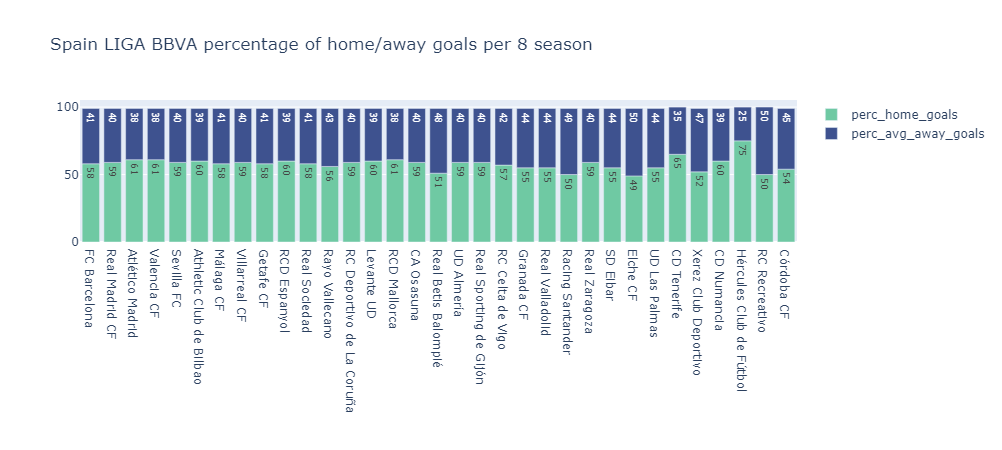

In [107]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\percentage_home_away_goals_spain.png")

AS we see from the bar chart, where teams are ordered by the number of total goals per 8 seasons (so best teams are in the beginning), mostly teams in Spain LIGA BBVA score more goals playing at home (from 51 to 75 percent), only three teams score equally at home and away (those are in the lower part of the bar chart). 

So it can be concluded, that teams on average score more goals playing at home in Spain, we'll check the situation in England too.

**England Premier League**

In [296]:
best_worst_england_teams_goals_for = pd.read_sql(
    """WITH table_1 AS(SELECT season season, 
home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
FROM Match 
WHERE league_id = 1729
ORDER BY season),

home_score_table AS (SELECT season, home_team_api_id, SUM(home_team_goal) home_goals_for
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

home_against_table AS (SELECT season, home_team_api_id, SUM(away_team_goal) home_goals_against
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_score_table AS (SELECT season, away_team_api_id, SUM(away_team_goal) away_goals_for
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_against_table AS (SELECT season, away_team_api_id, SUM(home_team_goal) away_goals_against
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

total_table AS(SELECT h.season, h.home_team_api_id team_api_id,  
t.team_long_name team_long_name, h.home_goals_for, a.away_goals_for, h.home_goals_for+a.away_goals_for total_goals_for, ha.home_goals_against, aa.away_goals_against, ha.home_goals_against+aa.away_goals_against total_goals_against
FROM home_score_table h
LEFT JOIN away_score_table a
ON h.season = a.season AND h.home_team_api_id = a.away_team_api_id
INNER JOIN home_against_table ha 
ON h.season = ha.season AND h.home_team_api_id = ha.home_team_api_id
INNER JOIN away_against_table aa 
ON h.season = aa.season AND h.home_team_api_id = aa.away_team_api_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1,2
ORDER BY 1,4),

rank_table AS (SELECT *, rank() over(PARTITION BY season ORDER BY total_goals_for DESC) rank_number_goals_for
FROM total_table)

SELECT season, team_long_name team_title, total_goals_for,  total_goals_against, rank_number_goals_for
FROM rank_table
WHERE rank_number_goals_for <= 3 OR rank_number_goals_for = 20
""",
    football_sql,
)
best_worst_england_teams_goals_for.head()

season         team_title  total_goals_for  total_goals_against  \
0  2008/2009          Liverpool               77                   27   
1  2008/2009            Arsenal               68                   37   
2  2008/2009            Chelsea               68                   24   
3  2008/2009  Manchester United               68                   24   
4  2008/2009      Middlesbrough               28                   57   

   rank_number_goals_for  
0                      1  
1                      2  
2                      2  
3                      2  
4                     20

In [298]:
fig = px.scatter(
    best_worst_england_teams_goals_for,
    x="season",
    y="total_goals_for",
    color="team_title",
    size="total_goals_for",
    symbol="team_title",
    hover_data=["rank_number_goals_for"],
    color_discrete_sequence=[
        "rgb(243, 231, 155)",
        "rgb(250, 196, 132)",
        "rgb(248, 160, 126)",
        "rgb(235, 127, 134)",
        "rgb(206, 102, 147)",
        "rgb(160, 89, 160)",
        "rgb(92, 83, 165)",
    ],
    labels={"team_title": "Team title:"},
)
fig.update_layout(
    title="Best and worst teams by total scored goals in ENGLAND Premier League"
)
fig.show()

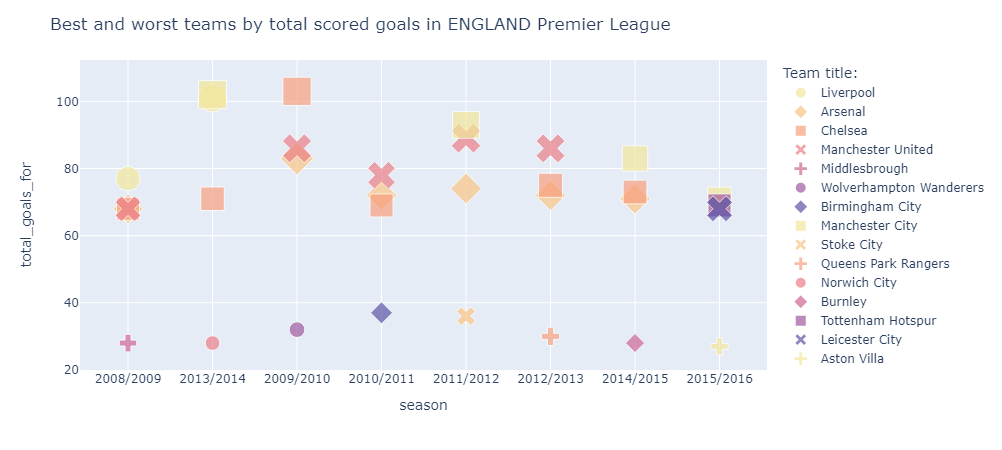

In [110]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\england_goals_for.png")

In England Premier League best scoring teams score less goals, that number varies from 71 to 103. Spain LIGA BBVA best two teams are much more productive in scored goals and also probably in attack factor too, so more aggressive. Also in England the difference between first three teams (by goals scored for) is less obvious, they are quite close. The worst scorers in England Premier league also reaches about 30 goals per season, that's similar to Spain. The best scorer in England Premier league was Chelsea  in 2009/2010. 

In [300]:
best_worst_england_teams_goals_against = pd.read_sql(
    """WITH table_1 AS(SELECT season season, 
home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
FROM Match 
WHERE league_id = 1729
ORDER BY season),

home_score_table AS (SELECT season, home_team_api_id, SUM(home_team_goal) home_goals_for
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

home_against_table AS (SELECT season, home_team_api_id, SUM(away_team_goal) home_goals_against
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_score_table AS (SELECT season, away_team_api_id, SUM(away_team_goal) away_goals_for
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

away_against_table AS (SELECT season, away_team_api_id, SUM(home_team_goal) away_goals_against
FROM table_1
GROUP BY 1,2
ORDER BY 1,3),

total_table AS(SELECT h.season, h.home_team_api_id team_api_id,  
t.team_long_name team_long_name, h.home_goals_for, a.away_goals_for, h.home_goals_for+a.away_goals_for total_goals_for, ha.home_goals_against, aa.away_goals_against, ha.home_goals_against+aa.away_goals_against total_goals_against
FROM home_score_table h
LEFT JOIN away_score_table a
ON h.season = a.season AND h.home_team_api_id = a.away_team_api_id
INNER JOIN home_against_table ha 
ON h.season = ha.season AND h.home_team_api_id = ha.home_team_api_id
INNER JOIN away_against_table aa 
ON h.season = aa.season AND h.home_team_api_id = aa.away_team_api_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1,2
ORDER BY 1,4),

rank_table AS (SELECT *, rank() over(PARTITION BY season ORDER BY total_goals_against ASC) rank_number_goals_against
FROM total_table)

SELECT season, team_long_name team_title, total_goals_for,  total_goals_against, rank_number_goals_against
FROM rank_table
WHERE rank_number_goals_against <= 3 OR rank_number_goals_against = 20;""",
    football_sql,
)
best_worst_england_teams_goals_against.head(10)

season            team_title  total_goals_for  total_goals_against  \
0  2008/2009               Chelsea               68                   24   
1  2008/2009     Manchester United               68                   24   
2  2008/2009             Liverpool               77                   27   
3  2008/2009  West Bromwich Albion               36                   67   
4  2009/2010     Manchester United               86                   28   
5  2009/2010               Chelsea              103                   32   
6  2009/2010             Liverpool               61                   35   
7  2009/2010               Burnley               42                   82   
8  2010/2011       Manchester City               60                   33   
9  2010/2011               Chelsea               69                   33   

   rank_number_goals_against  
0                          1  
1                          1  
2                          3  
3                         20  
4                          1  
5                          2  
6                          3  
7                         20  
8                          1  
9                          1

In [302]:
fig = px.scatter(
    best_worst_england_teams_goals_against,
    x="season",
    y="total_goals_against",
    color="team_title",
    size="total_goals_against",
    hover_data=["rank_number_goals_against"],
    color_discrete_sequence=[
        "rgb(243, 231, 155)",
        "rgb(250, 196, 132)",
        "rgb(248, 160, 126)",
        "rgb(235, 127, 134)",
        "rgb(206, 102, 147)",
        "rgb(160, 89, 160)",
        "rgb(92, 83, 165)",
    ],
    labels={"team_title": "Team title:"},
)
fig.update_layout(
    title="Best and worst teams by total number of goals against each other in England Premier League"
)
fig.show()

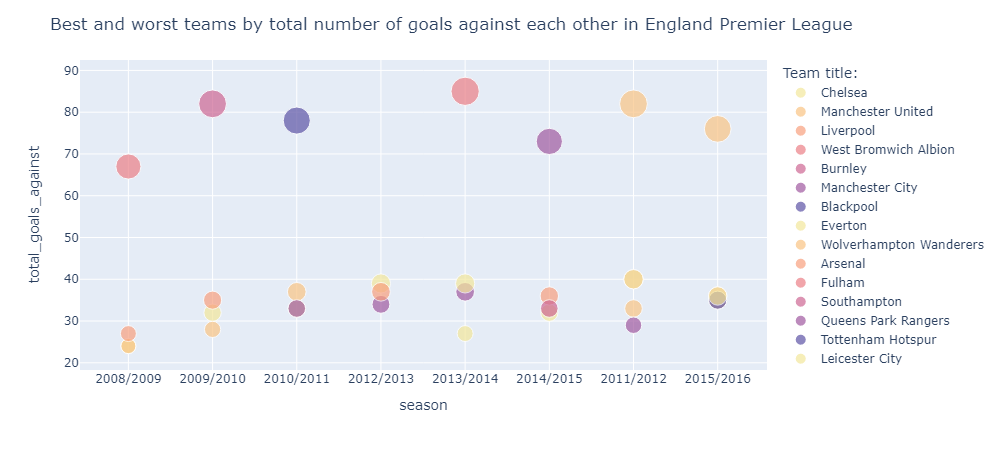

In [113]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\England_goals_against.png")

Chelsea is most consistent through those seasons and is always in the top 3 by lowest number of goals against it, also has the totally lowest number of goals against it in 2008/2009 - 24. Very similar situation is with Manchester United and Manchester City. So the same teams, which were champions in some seasons of England Premier League, had the best defense and does't let other teams to score them a lot. But we see that there is no team which would had gotten lower than 20 goals against is the observed seasons and in Spain we saw that.

* Let's see how many goals on average were scored playing at home and how many playing away In England Premier League.

In [304]:
england_teams_goals = pd.read_sql(
    """WITH table_1 AS(SELECT 
home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
FROM Match 
WHERE league_id = 1729),

home_table AS (SELECT home_team_api_id, SUM(home_team_goal) home_goals
FROM table_1
GROUP BY 1),

away_table AS (SELECT away_team_api_id, SUM(away_team_goal) away_goals
FROM table_1
GROUP BY 1),

total AS (SELECT h.home_team_api_id team_api_id,  
t.team_long_name team_title, h.home_goals, a.away_goals, h.home_goals+a.away_goals total_goals
FROM home_table h
LEFT JOIN away_table a
ON h.home_team_api_id = a.away_team_api_id
INNER JOIN Team t
ON h.home_team_api_id = t.team_api_id
GROUP BY 1)

SELECT team_title, home_goals, home_goals*100/total_goals perc_home_goals, 
away_goals, away_goals*100/total_goals perc_away_goals, 
total_goals 
FROM total
GROUP BY 1
ORDER BY 6 DESC;""",
    football_sql,
)
england_teams_goals.head()

team_title  home_goals  perc_home_goals  away_goals  \
0    Manchester City         365               60         241   
1            Chelsea         333               57         250   
2  Manchester United         338               58         244   
3            Arsenal         306               53         267   
4          Liverpool         294               55         237   

   perc_away_goals  total_goals  
0               39          606  
1               42          583  
2               41          582  
3               46          573  
4               44          531

In [307]:
fig = px.bar(
    england_teams_goals,
    x="team_title",
    y=["perc_home_goals", "perc_away_goals"],
    hover_data=["team_title", "home_goals", "away_goals", "total_goals"],
    text_auto=True,
    color_discrete_map={
        "perc_home_goals": "rgb(253, 253, 204)",
        "perc_away_goals": "rgb(156, 219, 165)",
    },
    title="England Premier League percentage of home/away goals per 8 season",
)
fig.update_yaxes(title="")
fig.update_xaxes(title="")
fig.update_layout(legend_title="")
fig.show()

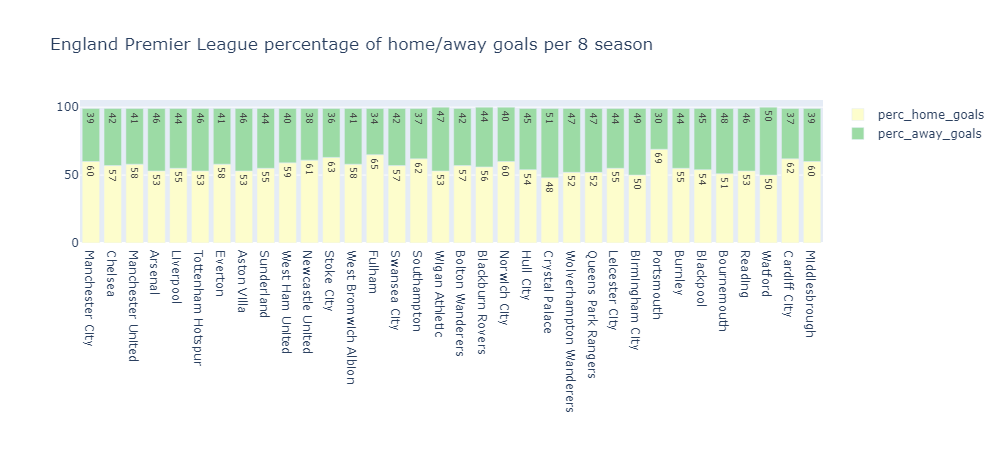

In [116]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\home_away_goals_England.png")

In [309]:
england_teams_goals["difference_in_percent"] = (
    england_teams_goals.perc_home_goals - england_teams_goals.perc_away_goals
)
diff_df = england_teams_goals[["team_title", "difference_in_percent"]]
diff_df.head()

team_title  difference_in_percent
0    Manchester City                     21
1            Chelsea                     15
2  Manchester United                     17
3            Arsenal                      7
4          Liverpool                     11

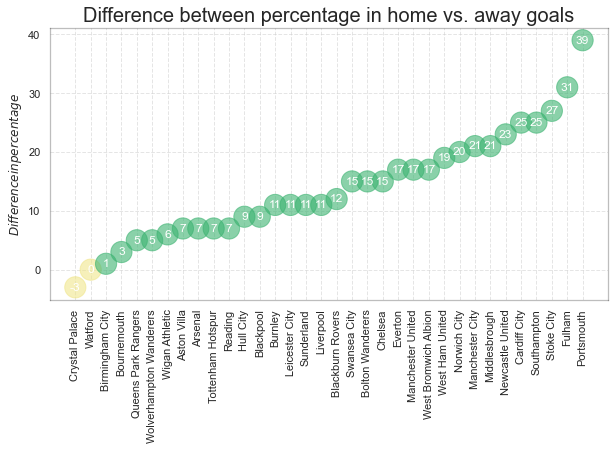

In [311]:
x = diff_df.loc[:, ["difference_in_percent"]]
diff_df["colors"] = [
    "khaki" if x <= 0 else "mediumseagreen" for x in diff_df["difference_in_percent"]
]
diff_df.sort_values("difference_in_percent", inplace=True)
diff_df.reset_index(inplace=True)
diff_df.drop("index", axis=1, inplace=True)

# Draw plot
plt.figure(figsize=(10, 5))
plt.scatter(
    y=diff_df.difference_in_percent, x=diff_df.index, s=450, alpha=0.6, c=diff_df.colors
)
for x, y, tex in zip(
    diff_df.index,
    diff_df.difference_in_percent,
    diff_df.difference_in_percent,
):
    t = plt.text(
        x,
        y,
        round(tex, 1),
        horizontalalignment="center",
        verticalalignment="center",
        fontdict={"color": "white"},
    )

# Decorations
# Lighten borders
plt.gca().spines["top"].set_alpha(0.3)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)
plt.gca().spines["left"].set_alpha(0.3)
plt.gca().tick_params(axis="x", labelrotation=90)

plt.xticks(diff_df.index, diff_df.team_title)
plt.title("Difference between percentage in home vs. away goals", fontdict={"size": 20})
plt.ylabel("$Difference in percentage$")
plt.grid(linestyle="--", alpha=0.5)
# plt.xlim(-2.5, 2.5)
plt.show()

English Premier League teams in the observed period of 8 years also scored more goals playing at home, but this difference is a lit bit smaller than in Spain. From the scatter plot above it may be seen that, mostly from 7 to even 39 percent is this difference of scoring goals in the home field.

### 2.2.4. Attack/defense features

#### 2.2.4.1. Shots on and shots off
2.2.4.1. Shots on and shots off
- *shot on* - a shot on target is defined as any goal attempt that: goes into the net regardless of intent – For Goals only; is a clear attempt to score that would have gone into the net but for being saved by the goalkeeper or is stopped by a player who is the last-man with the goalkeeper having no chance of preventing the goal (last line block). Shots directly hitting the frame of the goal are not counted as shots on target, unless the ball goes in and is awarded as a goal. Shots blocked by another player, who is not the last-man, are not counted as shots on target.

- *shot off* - a shot off target is defined as any clear attempt to score that: goes over or wide of the goal without making contact with another player; would have gone over or wide of the goal but for being stopped by a goalkeeper’s save or by an outfield player; directly hits the frame of the goal and a goal is not scored.
Blocked shots are not counted as shots off target.
Information taken from: [here](https://www.statsperform.com/opta-event-definitions/).


**England Premier League** shots on and shots of.

In [314]:
shot_on_shot_off_england = shot_on_shot_off.merge(
    list_of_all_england_teams, on="team_api_id"
)
shot_on_shot_off_england.head()

league_id     season  match_api_id  team_api_id  shot_on  shot_off  \
0       1729  2008/2009        489042        10260       11        10   
1       1729  2008/2009        489059        10260        7         5   
2       1729  2008/2009        489062        10260        8        10   
3       1729  2008/2009        489072        10260        4         3   
4       1729  2008/2009        489091        10260        8         6   

      team_long_name  
0  Manchester United  
1  Manchester United  
2  Manchester United  
3  Manchester United  
4  Manchester United

* Shots on and shot of by teams in England Premier League per 8 seasons.

In [316]:
shot_on_shot_of_england_grouped = shot_on_shot_off_england.groupby("team_long_name")[
    "shot_on", "shot_off"
].sum()
shot_on_shot_of_england_grouped.sort_values("shot_on", ascending=False, inplace=True)
shot_on_shot_of_england_grouped.reset_index(inplace=True)
shot_on_shot_of_england_grouped.head()

team_long_name  shot_on  shot_off
0            Chelsea     2394      2315
1          Liverpool     2332      2182
2  Tottenham Hotspur     2315      2066
3            Arsenal     2248      1978
4    Manchester City     2181      2059

In [318]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=shot_on_shot_of_england_grouped.team_long_name,
        y=shot_on_shot_of_england_grouped.shot_on,
        name="Shots on",
        marker_color="rgb(253, 253, 204)",
    )
)
fig.add_trace(
    go.Bar(
        x=shot_on_shot_of_england_grouped.team_long_name,
        y=shot_on_shot_of_england_grouped.shot_off,
        name="Shots off",
        marker_color="rgb(156, 219, 165)",
    )
)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(
    barmode="group",
    xaxis_tickangle=-45,
    title="England Premier League shots on/shots off by teams total in 8 season",
)
fig.show()

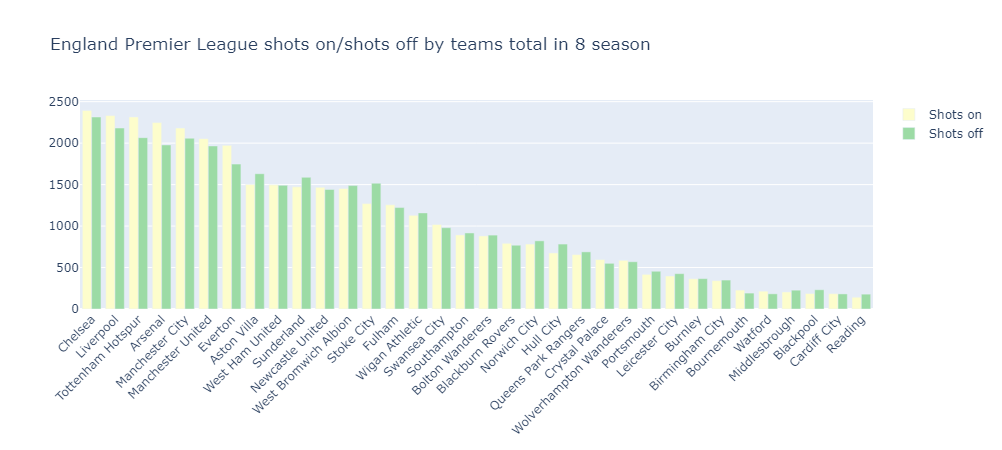

In [122]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\shotson_shots_off_england.png")

So, the largest number of total shot's on belong to the: Chelsea, Liverpool and Tottenham Hotspur. And we know, that Chelsea had won England Premier League only twice, Liverpool and Tottenham Hotspur in the observed seasons hadn't. So it seems that big number of shots on and shots off doesn't indicate possibilities to win more games. But Manchester United and Manchester city also is with more than  2000 shots on and shots off per 8 season. Lets see what is the min, max and average of shots on and shots off in the best 3 and worst 3 teams. Bets: Chelsea, Manchester United and Manchester City, worst: Blackpool, Cardiff City and Reading.

In [321]:
# Here you can find all statistics about all teams in England Premier league on shots on and shots off.
averages_per_teams = (
    shot_on_shot_off_england.groupby(["season", "team_long_name"])
    .agg(
        {
            "shot_on": ["min", "max", "mean", "sum"],
            "shot_off": ["min", "max", "mean", "sum"],
        }
    )
    .reset_index()
)
averages_per_teams.head()

season    team_long_name shot_on               shot_off              
                                   min max mean  sum      min max mean  sum
0  2008/2009           Arsenal       1  12 7.00  259        2  13 7.89  292
1  2008/2009       Aston Villa       1  14 5.36  193        2  12 5.94  214
2  2008/2009  Blackburn Rovers       1  12 5.61  213        2   9 5.34  203
3  2008/2009  Bolton Wanderers       1  13 5.44  196        2  11 5.92  213
4  2008/2009           Chelsea       3  19 9.29  353        3  20 8.74  332

In [322]:
# Preparing data for plotting.
chelsea = averages_per_teams.where(
    averages_per_teams["team_long_name"] == "Chelsea"
).dropna()
man_united = averages_per_teams.where(
    averages_per_teams["team_long_name"] == "Manchester United"
).dropna()
man_city = averages_per_teams.where(
    averages_per_teams["team_long_name"] == "Manchester City"
).dropna()
blackpool = averages_per_teams.where(
    averages_per_teams["team_long_name"] == "Blackpool"
).dropna()
cardiff = averages_per_teams.where(
    averages_per_teams["team_long_name"] == "Cardiff City"
).dropna()
reading = averages_per_teams.where(
    averages_per_teams["team_long_name"] == "Reading"
).dropna()
total = pd.concat([chelsea, man_united, man_city, blackpool, cardiff, reading])
total_normal = pd.DataFrame(
    {
        "season": total[("season", "")],
        "team_title": total[("team_long_name", "")],
        "shot_on_min_per_game": total[("shot_on", "min")],
        "shot_on_max_per_game": total[("shot_on", "max")],
        "shot_on_mean_per_game": total[("shot_on", "mean")],
        "shot_off_min_per_game": total[("shot_off", "min")],
        "shot_off_max_per_game": total[("shot_off", "max")],
        "shot_off_mean_per_game": total[("shot_off", "mean")],
    }
)

# plotting
fig = px.line(
    total_normal,
    x="season",
    y=[
        "shot_on_min_per_game",
        "shot_on_max_per_game",
        "shot_on_mean_per_game",
        "shot_off_min_per_game",
        "shot_off_max_per_game",
        "shot_off_mean_per_game",
    ],
    markers=True,
    facet_row="team_title",
    height=1000,
    facet_row_spacing=0.03,
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("team_title=", "")))
fig.update_yaxes(title="")
fig.update_xaxes(title="")
fig.update_layout(
    legend_title="", title="Best/worst England Premier League  teams shot on/shot off"
)
fig.show()

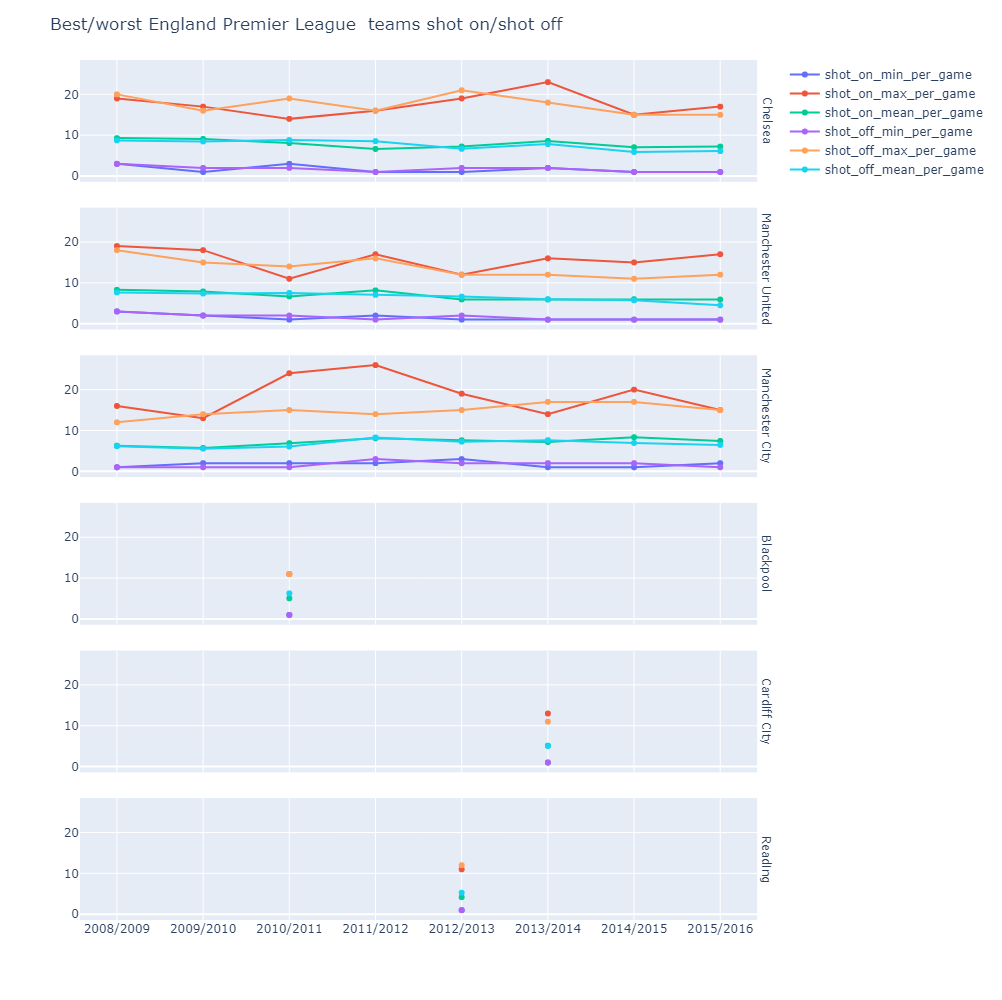

In [323]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\shotson_shotsoff_statistics.png")

So from these plots we can clearly investigate best and worst teams on shots on and shots off min, max and mean per game in each season. Chelsea and Manchester United seems quite stable in these numbers, but for example in 2010/2011 and 2011/2012 had the peaks of max shots off per game and this team was the winner of the England Premier League in 2011/2012. So some patterns can be found. And worst teams, that each in fact had played only once in the League, has a lot lower numbers of statistics in the shots on and shots off results.

#### 2.2.4.2. Attack and defense rating by teams attributes

**SPAIN LIGA BBVA**

In [324]:
spain_teams_with_attributes.head(2)

team_long_name  team_api_id                 date  chanceCreationPassing  \
0     UD Almería         9865  2010-02-22 00:00:00                     45   
1     UD Almería         9865  2011-02-22 00:00:00                     57   

   chanceCreationCrossing  chanceCreationShooting  defencePressure  \
0                      45                      70               70   
1                      54                      69               58   

   defenceAggression  defenceTeamWidth  
0                 65                30  
1                 68                67

I chose all teams, that played in SPAIN LIGA BBVA in all 8 season and their attributes, that could show the attacking and defending features of every team. As all teams got ratings in different dates, I decided to get the mean of every rating and see in total, how do these rating change over all teams and compare them, choosing the best teams of Spain LIGA BBVA: Barcelona FC, Real Madrid CF and Atletico Madrid, and other. Will these rating show some kind of pattern.

In [326]:
spain_teams_attack_def_rating = (
    spain_teams_with_attributes.groupby(["team_long_name", "team_api_id"])[
        [
            "chanceCreationPassing",
            "chanceCreationCrossing",
            "chanceCreationShooting",
            "defencePressure",
            "defenceAggression",
            "defenceTeamWidth",
        ]
    ]
    .mean()
    .reset_index()
)
spain_teams_attack_def_rating.head()

team_long_name  team_api_id  chanceCreationPassing  \
0  Athletic Club de Bilbao         8315                  46.67   
1          Atlético Madrid         9906                  64.67   
2               CA Osasuna         8371                  53.50   
3              CD Numancia         8388                  50.67   
4              CD Tenerife         9867                  56.25   

   chanceCreationCrossing  chanceCreationShooting  defencePressure  \
0                   70.17                   46.83            39.67   
1                   62.67                   60.00            55.50   
2                   61.67                   56.50            44.33   
3                   45.33                   56.00            45.00   
4                   46.00                   58.25            52.75   

   defenceAggression  defenceTeamWidth  
0              62.33             56.83  
1              39.17             54.33  
2              55.67             65.83  
3              48.00             59.67  
4              45.00             61.50

In [328]:
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Attack features", "Defense features"),
    shared_xaxes=True,
)

fig.add_trace(
    go.Scatter(
        x=spain_teams_attack_def_rating.team_long_name,
        y=spain_teams_attack_def_rating.chanceCreationPassing,
        mode="lines+markers",
        name="chanceCreationPassing",
    ),
    1,
    1,
)
fig.add_trace(
    go.Scatter(
        x=spain_teams_attack_def_rating.team_long_name,
        y=spain_teams_attack_def_rating.chanceCreationCrossing,
        mode="lines+markers",
        name="chanceCreationCrossing",
    ),
    1,
    1,
)
fig.add_trace(
    go.Scatter(
        x=spain_teams_attack_def_rating.team_long_name,
        y=spain_teams_attack_def_rating.chanceCreationShooting,
        mode="lines+markers",
        name="chanceCreationShooting",
    ),
    1,
    1,
)
fig.add_trace(
    go.Scatter(
        x=spain_teams_attack_def_rating.team_long_name,
        y=spain_teams_attack_def_rating.defencePressure,
        mode="lines+markers",
        name="defencePressure",
    ),
    2,
    1,
)

fig.add_trace(
    go.Scatter(
        x=spain_teams_attack_def_rating.team_long_name,
        y=spain_teams_attack_def_rating.defenceAggression,
        mode="lines+markers",
        name="defenceAggression",
    ),
    2,
    1,
)

fig.add_trace(
    go.Scatter(
        x=spain_teams_attack_def_rating.team_long_name,
        y=spain_teams_attack_def_rating.defenceTeamWidth,
        mode="lines+markers",
        name="defenceTeamWidth",
    ),
    2,
    1,
)
fig.update_layout(autosize=False, width=1000, height=600)
fig.show()

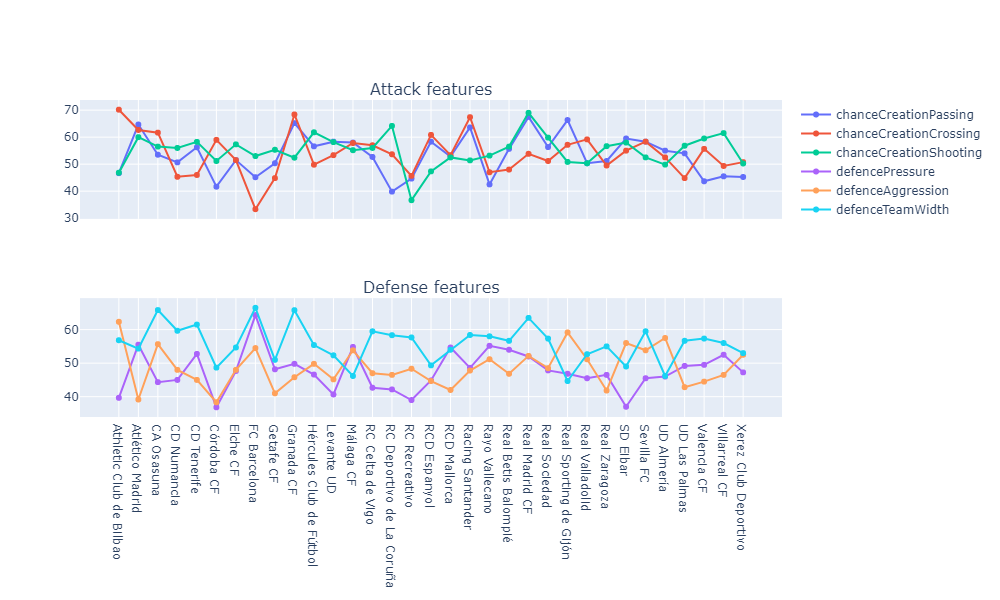

In [129]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\\atack_defense.png")

Results are a little bit surprising as Barcelona is quite low in all attacking features of chance creation: chanceCreationCrossing rating is the lowest - 33.33, chanceCreationShooting - 45.16 - is also quite low, but the defense ratings are in the tops. So it seems that FC Barcelona players play more by themselves and doesn't support assistance to each other to create possibilities for scoring, but the defense is quite strong. Real Madrid is in the tops of both measures, Atletico Madrid is better in chance creation than in defense ratings, but on the other hand Atletico Madrid was in the top3 by the lowest number of goals scored against it, to this teams shows quite good in attacking and in defending too. 

**England Premier League**

In [330]:
england_teams_attack_def_rating = (
    england_teams_with_attributes.groupby(["team_long_name", "team_api_id"])[
        [
            "chanceCreationPassing",
            "chanceCreationCrossing",
            "chanceCreationShooting",
            "defencePressure",
            "defenceAggression",
            "defenceTeamWidth",
        ]
    ]
    .mean()
    .reset_index()
)
england_teams_attack_def_rating.head()

team_long_name  team_api_id  chanceCreationPassing  \
0           Arsenal         9825                  34.67   
1       Aston Villa        10252                  54.83   
2   Birmingham City         8658                  57.50   
3  Blackburn Rovers         8655                  57.00   
4         Blackpool         8483                  64.00   

   chanceCreationCrossing  chanceCreationShooting  defencePressure  \
0                   46.33                   46.50            50.50   
1                   56.00                   47.33            36.83   
2                   64.33                   54.50            44.67   
3                   56.00                   42.00            45.67   
4                   51.17                   61.33            48.50   

   defenceAggression  defenceTeamWidth  
0              46.50             50.50  
1              48.67             51.17  
2              52.83             55.17  
3              55.00             46.67  
4              50.00             55.17

In [331]:
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Attack features", "Defense features"),
    shared_xaxes=True,
)

fig.add_trace(
    go.Scatter(
        x=england_teams_attack_def_rating.team_long_name,
        y=england_teams_attack_def_rating.chanceCreationPassing,
        mode="lines+markers",
        name="chanceCreationPassing",
    ),
    1,
    1,
)
fig.add_trace(
    go.Scatter(
        x=england_teams_attack_def_rating.team_long_name,
        y=england_teams_attack_def_rating.chanceCreationCrossing,
        mode="lines+markers",
        name="chanceCreationCrossing",
    ),
    1,
    1,
)
fig.add_trace(
    go.Scatter(
        x=england_teams_attack_def_rating.team_long_name,
        y=england_teams_attack_def_rating.chanceCreationShooting,
        mode="lines+markers",
        name="chanceCreationShooting",
    ),
    1,
    1,
)
fig.add_trace(
    go.Scatter(
        x=england_teams_attack_def_rating.team_long_name,
        y=england_teams_attack_def_rating.defencePressure,
        mode="lines+markers",
        name="defencePressure",
    ),
    2,
    1,
)

fig.add_trace(
    go.Scatter(
        x=england_teams_attack_def_rating.team_long_name,
        y=england_teams_attack_def_rating.defenceAggression,
        mode="lines+markers",
        name="defenceAggression",
    ),
    2,
    1,
)

fig.add_trace(
    go.Scatter(
        x=england_teams_attack_def_rating.team_long_name,
        y=england_teams_attack_def_rating.defenceTeamWidth,
        mode="lines+markers",
        name="defenceTeamWidth",
    ),
    2,
    1,
)
fig.update_layout(autosize=False, width=1000, height=600)
fig.show()

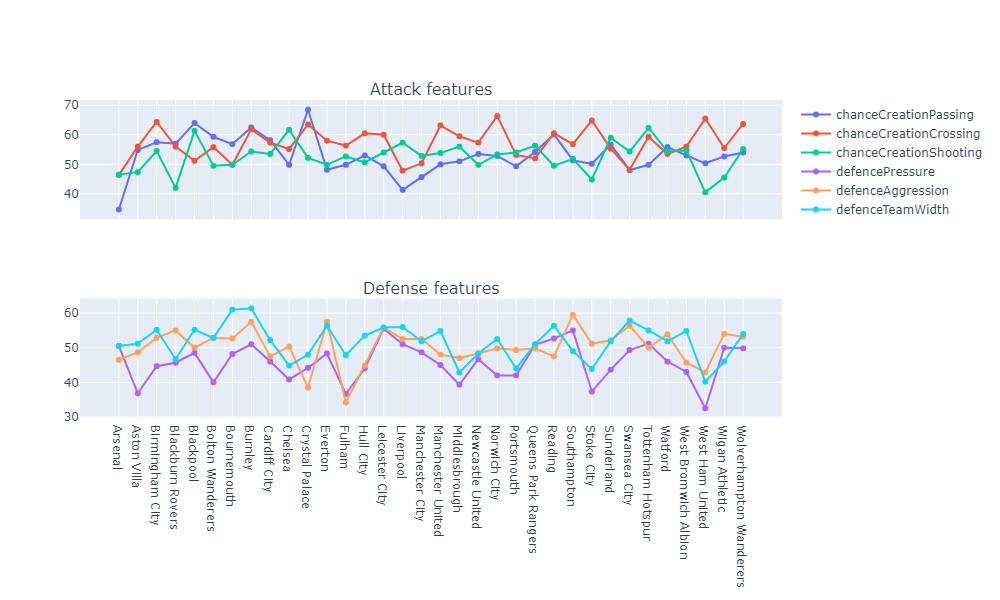

In [132]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\\attack_defense_England.png")

Also, I don't see strong patterns, Chelsea is quite low in all features, stays in the middle by them. Manchester City is better in defense features, but lower in attack. Manchester United leads in chanceCreationCrossing and defenseTeamWidth, aut all in all, the best teams of England Premier League aren't best in these features.

#### 2.2.4.3. Cards

**SPAIN LIGA BBVA**

In [133]:
cards_spain = cards_df.merge(list_of_all_spain_teams, on='team_api_id')
cards_spain.head()

league_id     season  match_api_id card_type  team_api_id team_long_name
0      21518  2008/2009        530023         y        10267    Valencia CF
1      21518  2008/2009        530023         y        10267    Valencia CF
2      21518  2008/2009        530023         y        10267    Valencia CF
3      21518  2008/2009        530023         y        10267    Valencia CF
4      21518  2008/2009        530241         y        10267    Valencia CF

In [134]:
total_spain_cards = cards_spain.groupby(['team_long_name'])['card_type'].value_counts().reset_index(name='number_of_cards')
total_spain_cards.head()

team_long_name card_type  number_of_cards
0  Athletic Club de Bilbao         y              783
1  Athletic Club de Bilbao        y2               35
2  Athletic Club de Bilbao         r               23
3          Atlético Madrid         y              831
4          Atlético Madrid        y2               23

In [332]:
fig = px.line(total_spain_cards, x='team_long_name', y='number_of_cards', markers=True, facet_row = 'card_type', height=500,
          facet_row_spacing = 0.03)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("card_type=", "")))
fig.update_yaxes(matches=None)
fig.update_yaxes(title='')
fig.update_xaxes(title='')
fig.update_layout(legend_title='', title='Cards by teams in total 8 season Spain LIGA BBVA')
fig.show()

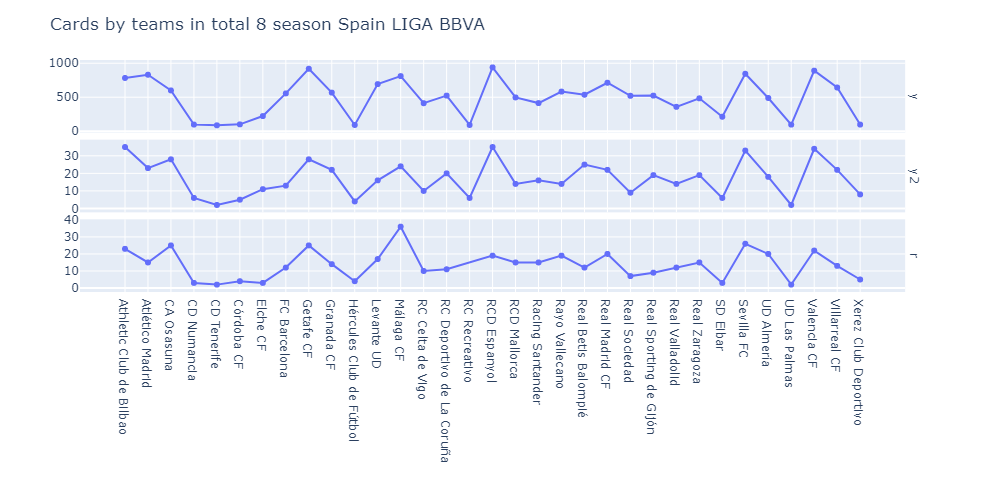

In [136]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\cards_spain.png")

It seems that FC Barcelona, Real Madrid CF have lower numbers of all these cards. So best teams plays with more attention to the rules and more respect for the opponent. We see that leaders in yellow and red cards per all season are Athletic Club de Bilbao, Getafe CF, RCD Espanyol, Sevilla FC and Valencia CF. Let's remember what places did those teams take.

In [334]:
card_teams_results = scores_spain_england[
    (scores_spain_england["team_title"] == "Athletic Club de Bilbao")
    | (scores_spain_england["team_title"] == "Getafe CF")
    | (scores_spain_england["team_title"] == "RCD Espanyol")
    | (scores_spain_england["team_title"] == "Sevilla FC")
    | (scores_spain_england["team_title"] == "Valencia CF")
].sort_values("rank", ascending=True)
card_teams_results.head()

season      league_name  team_api_id   team_title team_short_name  \
22   2008/2009  Spain LIGA BBVA         8302   Sevilla FC             SEV   
62   2009/2010  Spain LIGA BBVA        10267  Valencia CF             VAL   
142  2011/2012  Spain LIGA BBVA        10267  Valencia CF             VAL   
102  2010/2011  Spain LIGA BBVA        10267  Valencia CF             VAL   
263  2014/2015  Spain LIGA BBVA        10267  Valencia CF             VAL   

     total_score  rank  
22            70     3  
62            71     3  
142           61     3  
102           71     3  
263           77     4

In [335]:
card_teams_results.tail()

season      league_name  team_api_id    team_title team_short_name  \
153  2011/2012  Spain LIGA BBVA         8558  RCD Espanyol             ESP   
273  2014/2015  Spain LIGA BBVA         8305     Getafe CF             GET   
115  2010/2011  Spain LIGA BBVA         8305     Getafe CF             GET   
36   2008/2009  Spain LIGA BBVA         8305     Getafe CF             GET   
318  2015/2016  Spain LIGA BBVA         8305     Getafe CF             GET   

     total_score  rank  
153           46    14  
273           37    14  
115           44    16  
36            42    17  
318           36    19

So we see, that teams with largest number of cards gotten, in the league had won from 3rd to 19'th place, but no champions as obvious.

**England Premier League**

In [337]:
cards_england = cards_df.merge(list_of_all_england_teams, on="team_api_id")
cards_england.head()

league_id     season  match_api_id card_type  team_api_id  \
0       1729  2008/2009        489042         y        10260   
1       1729  2008/2009        489042         y        10260   
2       1729  2008/2009        489042         y        10260   
3       1729  2008/2009        489132         y        10260   
4       1729  2008/2009        489142         y        10260   

      team_long_name  
0  Manchester United  
1  Manchester United  
2  Manchester United  
3  Manchester United  
4  Manchester United

In [339]:
total_england_cards = (
    cards_england.groupby(["team_long_name"])["card_type"]
    .value_counts()
    .reset_index(name="number_of_cards")
)
total_england_cards.head()

team_long_name card_type  number_of_cards
0        Arsenal         y              453
1        Arsenal         r               16
2        Arsenal        y2               13
3    Aston Villa         y              552
4    Aston Villa         r               11

In [341]:
fig = px.line(
    total_england_cards,
    x="team_long_name",
    y="number_of_cards",
    markers=True,
    facet_row="card_type",
    height=500,
    facet_row_spacing=0.03,
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("card_type=", "")))
fig.update_yaxes(matches=None)
fig.update_yaxes(title="")
fig.update_xaxes(title="")
fig.update_layout(
    legend_title="", title="Cards by teams in total 8 season ENGLAND PREMIER LEAGUE"
)
fig.show()

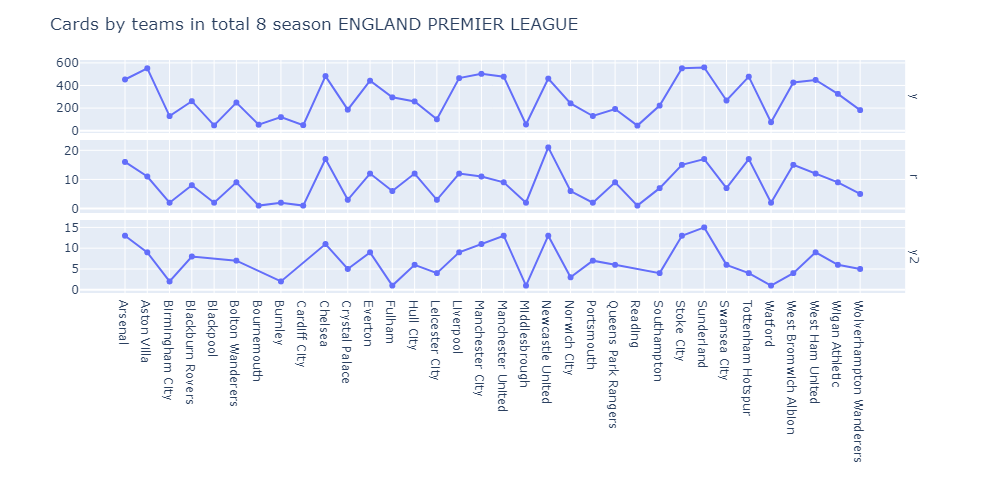

In [142]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\cards_england.png")

And here we see the different situation, where Chelsea, Manchester United, Manchester City (multiple winner of England Premier League) is in the lead of all types of cards too.
Let's see what was the situation by season.

In [344]:
season_england_cards = (
    cards_england.groupby(["season", "team_long_name"])["card_type"]
    .value_counts()
    .reset_index(name="number_of_cards")
)
season_england_cards.head()

season team_long_name card_type  number_of_cards
0  2008/2009        Arsenal         y               60
1  2008/2009        Arsenal        y2                2
2  2008/2009        Arsenal         r                1
3  2008/2009    Aston Villa         y               53
4  2008/2009    Aston Villa         r                1

In [346]:
mask = (
    (season_england_cards["team_long_name"] == "Chelsea")
    | (season_england_cards["team_long_name"] == "Manchester United")
    | (season_england_cards["team_long_name"] == "Manchester City")
)
chelsea_man_man = season_england_cards[mask]
# plotting

fig = px.line(
    chelsea_man_man,
    x="season",
    y="number_of_cards",
    markers=True,
    facet_row="team_long_name",
    facet_col="card_type",
    height=500,
    facet_row_spacing=0.03,
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("team_long_name=", "")))
fig.update_yaxes(title="")
fig.update_xaxes(title="")
fig.update_layout(legend_title="", title="Cards by season")
fig.show()

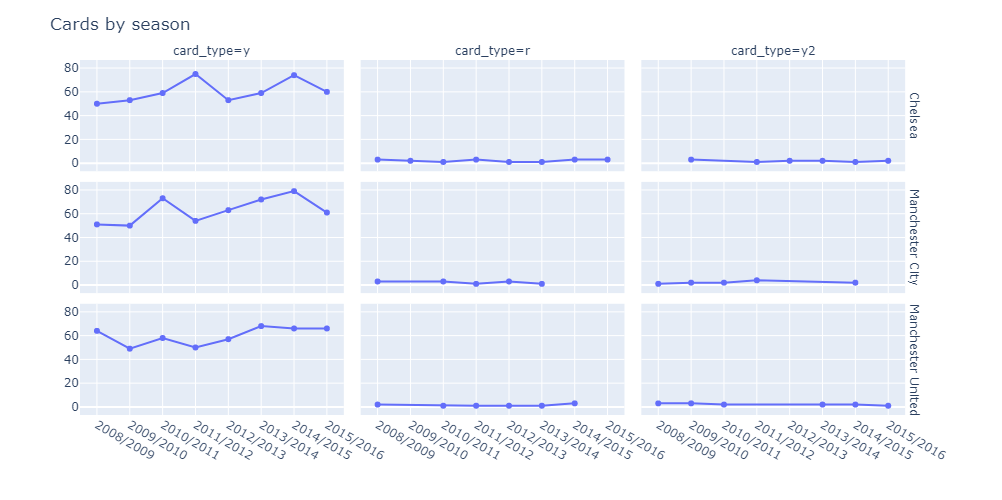

In [145]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\cards_by_season_eng.png")

By season the best teams in England Premier League differ in yellow cards quite a lot, but red cards and second yellow cards (which mean player elimination from the field) doesn't change a lot and is quite consistent from 0 to max 3, the leader is Chelsea.

To conclude, i think that this search showed that in Spain and England the top favorite teams play quite different football, in Spain best teams are in the lower part by the number of cards, gotten per all seasons, and in England the top three teams are also the leaders in number of cards.

### 2.2.5. Best scorers (players) in SPAIN LIGA BBVA and ENGLAND Premier League

In [348]:
# Getting the best ones.
best_by_season = (
    spain_eng_scorers.groupby(["league_id", "season"])["goals"]
    .max()
    .reset_index()
    .merge(spain_eng_scorers, on=["league_id", "season", "goals"])
)
best_by_season.drop(columns=["team_api_id", "player_api_id"])

league_id     season  goals     team_long_name        player_name
0        1729  2008/2009     20  Manchester United  Cristiano Ronaldo
1        1729  2009/2010     29            Chelsea      Didier Drogba
2        1729  2010/2011     21    Manchester City       Carlos Tevez
3        1729  2011/2012     31            Arsenal   Robin van Persie
4        1729  2012/2013     28  Manchester United   Robin van Persie
5        1729  2013/2014     32          Liverpool        Luis Suarez
6        1729  2014/2015     27    Manchester City      Sergio Aguero
7        1729  2015/2016     26  Tottenham Hotspur         Harry Kane
8       21518  2008/2009     33       FC Barcelona       Samuel Eto'o
9       21518  2009/2010     35       FC Barcelona       Lionel Messi
10      21518  2010/2011     40     Real Madrid CF  Cristiano Ronaldo
11      21518  2011/2012     52       FC Barcelona       Lionel Messi
12      21518  2012/2013     46       FC Barcelona       Lionel Messi
13      21518  2013/2014     31     Real Madrid CF  Cristiano Ronaldo
14      21518  2013/2014     31    Atlético Madrid        Diego Costa
15      21518  2014/2015     51     Real Madrid CF  Cristiano Ronaldo
16      21518  2015/2016     42       FC Barcelona        Luis Suarez

In [351]:
fig = px.scatter(
    best_by_season,
    x="season",
    y="goals",
    color="player_name",
    size="goals",
    hover_data=["team_long_name"],
    color_discrete_sequence=[
        "rgb(253, 253, 204)",
        "rgb(206, 236, 179)",
        "rgb(156, 219, 165)",
        "rgb(111, 201, 163)",
        "rgb(86, 177, 163)",
        "rgb(76, 153, 160)",
        "rgb(68, 130, 155)",
        "rgb(62, 108, 150)",
        "rgb(62, 82, 143)",
        "rgb(64, 60, 115)",
        "rgb(54, 43, 77)",
        "rgb(39, 26, 44)",
    ],
    labels={"team_title": "Team title:"},
)
fig.update_layout(title="Best goalers by season in both leagues")
fig.show()

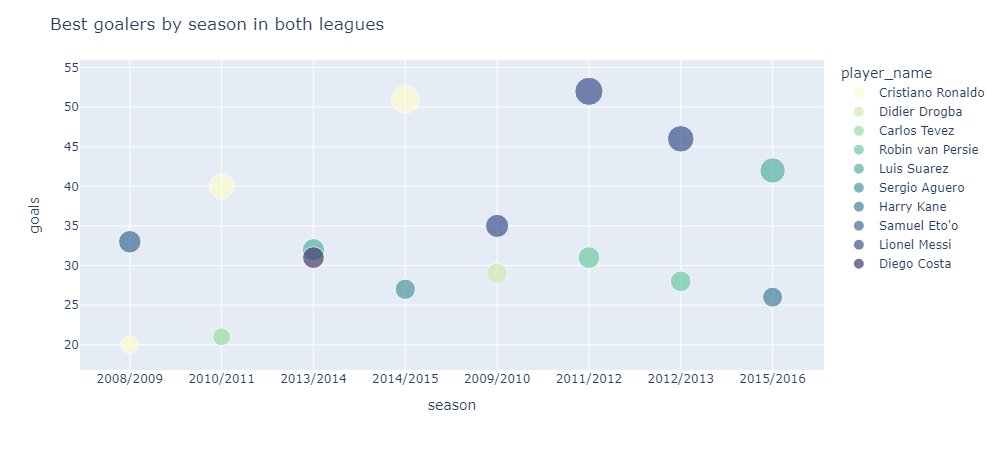

In [148]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\\best_goalers.png")

In [352]:
best_by_season[best_by_season['player_name'] == 'Cristiano Ronaldo']

league_id     season  goals  team_api_id  player_api_id  \
0        1729  2008/2009     20        10260          30893   
10      21518  2010/2011     40         8633          30893   
13      21518  2013/2014     31         8633          30893   
15      21518  2014/2015     51         8633          30893   

       team_long_name        player_name  
0   Manchester United  Cristiano Ronaldo  
10     Real Madrid CF  Cristiano Ronaldo  
13     Real Madrid CF  Cristiano Ronaldo  
15     Real Madrid CF  Cristiano Ronaldo

In [353]:
best_by_season[best_by_season['player_name'] == 'Lionel Messi']

league_id     season  goals  team_api_id  player_api_id team_long_name  \
9       21518  2009/2010     35         8634          30981   FC Barcelona   
11      21518  2011/2012     52         8634          30981   FC Barcelona   
12      21518  2012/2013     46         8634          30981   FC Barcelona   

     player_name  
9   Lionel Messi  
11  Lionel Messi  
12  Lionel Messi

So we clearly see, that best 'goalers' are Cristiano Ronaldo (who had been playing in both leagues) and Lionel Messi (with the highest number of goals per season in 2011/2012). So having them in team automatically indicates better possibilities to win and score more goals :) 
Let's see what is their income in the total number of goals in these teams by season.

In [355]:
best_by_season_per = best_by_season.merge(
    spain_eng_goals, on=["league_id", "season", "team_long_name"]
)
best_by_season_per.drop(
    columns=["league_id", "team_api_id_x", "player_api_id", "team_api_id_y"],
    axis=1,
    inplace=True,
)
best_by_season_per.columns = [
    "season",
    "player_goals",
    "team_long_name",
    "player_name",
    "league_name",
    "total_goals_by_team",
]
best_by_season_per["percent_in_total"] = (
    best_by_season_per.player_goals * 100 / best_by_season_per.total_goals_by_team
)
best_by_season_per.head()

season  player_goals     team_long_name        player_name  \
0  2008/2009            20  Manchester United  Cristiano Ronaldo   
1  2009/2010            29            Chelsea      Didier Drogba   
2  2010/2011            21    Manchester City       Carlos Tevez   
3  2011/2012            31            Arsenal   Robin van Persie   
4  2012/2013            28  Manchester United   Robin van Persie   

              league_name  total_goals_by_team  percent_in_total  
0  England Premier League                   68             29.41  
1  England Premier League                  103             28.16  
2  England Premier League                   60             35.00  
3  England Premier League                   74             41.89  
4  England Premier League                   86             32.56

In [358]:
fig = px.line(
    best_by_season_per,
    x="season",
    y="percent_in_total",
    markers=True,
    facet_row="league_name",
    hover_data=["player_name", "team_long_name"],
    height=500,
    facet_row_spacing=0.03,
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("league_name=", "")))
fig.update_yaxes(matches=None)
fig.update_yaxes(title="")
fig.update_xaxes(title="")
fig.update_layout(
    legend_title="", title="Percentage of best goalers in total team goals by season"
)
fig.show()

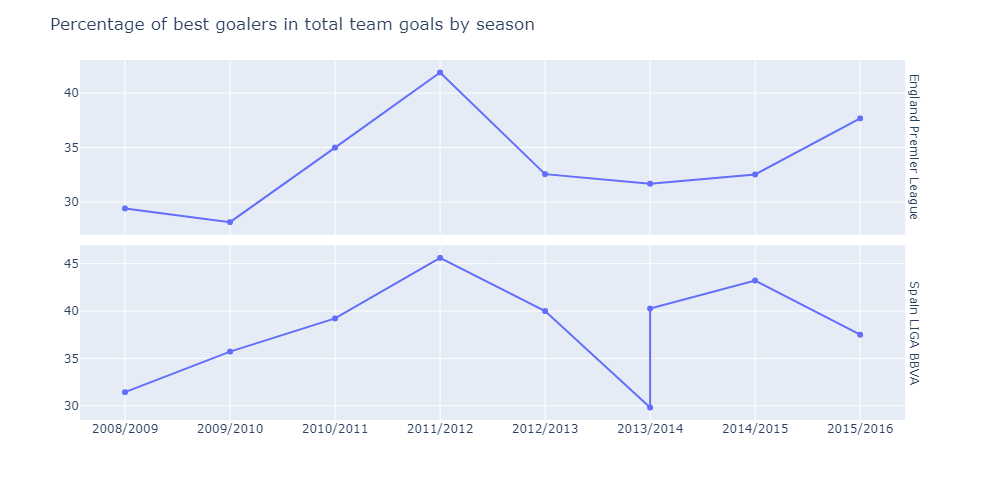

In [153]:
# If plotly doesn't show a chart, here it is.
Image(filename="png_folder\\best_goalers_income.png")

So we see that best player (by scored goals) can make difference, as their income in total basket of team goals is from about 30 to 40 percent.

* Let's see the best scorers rating points from Player_Attributes.

In [360]:
total_player_attributes = pd.concat(
    [spain_player_with_avg_attr, england_premier_league_player_with_avg_attr]
)
lst_player_api_id = best_by_season["player_api_id"].drop_duplicates().to_list()
needed_player_attr = total_player_attributes[
    total_player_attributes["player_api_id"].isin(lst_player_api_id)
]
needed_player_attr.drop_duplicates()

player_api_id        player_name  height  weight  overall_rating  \
53            19243        Diego Costa  187.96  187.00           80.56   
194           30893  Cristiano Ronaldo  185.42  176.00           91.28   
207           30981       Lionel Messi  170.18  159.00           92.19   
265           33639       Samuel Eto'o  177.80  165.00           83.78   
384           37412      Sergio Aguero  172.72  163.00           86.11   
579           40636        Luis Suarez  182.88  187.00           85.28   
440           30822      Didier Drogba  187.96  176.00           83.41   
450           30843   Robin van Persie  187.96  157.00           86.47   
735           38817       Carlos Tevez  172.72  157.00           85.79   
1212         194165         Harry Kane  187.96  143.00           72.41   

      potential  
53        83.72  
194       93.48  
207       95.23  
265       84.85  
384       88.97  
579       87.53  
440       84.24  
450       87.13  
735       86.50  
1212      80.91

I would say they have a very high overall ratings and potential, close to 100. So nothing to be surprised about them being the goal machines :)

## 2.3. Main conclusions from Spain LIGA BBVA and England Premier League investigation

* Spain Liga BBVA and it's teams, play style  is quite different from England Premier League. 

* Spain Liga BBVA is more predictable in winners, as from the observed 8 seasons, FB Barcelona had won 6 times,  Real Madrid, Atletico Madrid - one time each. England Premier League winners are more unpredictable, as Manchester United had won 4 times, Chelsea and Manchester City - 2 times, Leicester city - 1 time. 

* Spain LIGA BBVA has stronger favorite team (FC Barcelona) and in this league winner each year earns more points (having in mind that in both leagues each team plays 38 games per season and has possibility to earn the same amount of points in total) than in England Premier League. This also can indicate, that England Premier League in total has stronger teams, playing in it, where more teams can compete in the highest level.

* Spain LIGA BBVA has two teams: FC Barcelona and CF Real Madrid, which hits the peaks with the number of goals, all other teams are quite far away from these two numbers. A little bit different situation is with the goals against, where still FC Barcelona leads, but Atletico Madrid from 2012 has improved a lot in this sphere and is in the first-second place by smallest number  of scored goals against it. In England we have more different teams, which score largest number of goals per season, but the number of goals is lower than in Spain.

* There is a home advantage in football games. Teams in Spain and England score more goals, playing at home. The difference varies through seasons. Seasons are important and you can see some patterns, when couple better seasons lead to the win of the league. So averages of the past season can be important. 

* The difference between the population proportions of home and away wins in football games, played in England Premier League and Spain LIGA BBVA in 8 seasons, is statistically significant. Teams win more times, playing at home, than away. But in England Premier League number of home wins was dropping from the season 2009/2010 and is getting closer to the away team win (home loss).

* The largest number of total shot's on belong to the: Chelsea, Liverpool and Tottenham Hotspur. Chelsea had won England Premier League only twice, Liverpool and Tottenham Hotspur in the observed seasons hadn't. So it seems that big number of shots on and shots off doesn't indicate possibilities to win more games.

* In Spain LIGA BBVA FC Barcelona, Real Madrid CF have lower numbers of all these cards. So best teams plays with more attention to the rules and more respect for the opponent. In England Premier League we see the different situation, where Chelsea, Manchester United, Manchester City (multiple winner of England Premier League) is in the lead of all types of cards too.

* Best 'goalers' are Cristiano Ronaldo (who had been playing in England Premier League and Spain LIGA BBVA) and Lionel Messi (with the highest number of goals per season in 2011/2012). So having them in team automatically indicates better possibilities to win and score more goals. The income of best 'goalers' into the total basket of goals varies from 28 to 40 percent depending on a observed season.

# 3. Data set with needed features for modeling

## 3.1. Gathering the final data set.

According to the EDA, I decided to choose England Premier League for predicting game result, number of goals, as this league seems to be more unpredictable, has more strong teams that compete between and also more data were provided in the dataset. 

While the home advantage was obvious, I divided all data into home and away and all scores, that will be counted and selected for the final data set, are taken having in mind, where team had played that game (home or away).

Also as it’s impossible to have the statistic of the games before the result of the match, it’s necessary to create some new variables that would be available before the games.

In [362]:
england_table = pd.read_sql(
    """WITH eng_table AS (
    SELECT
        m.country_id,
        l.name league_name,
        m.season as season,
        date(m.date) game_date,
        m.match_api_id,
        m.home_team_api_id,
        t.team_long_name home_team,
        m.away_team_api_id,
        m.home_team_goal,
        m.away_team_goal,
        CASE
            WHEN home_team_goal > away_team_goal THEN 3
            WHEN home_team_goal = away_team_goal THEN 1
            ELSE 0
        END AS home_team_points,
        CASE
            WHEN home_team_goal < away_team_goal THEN 3
            WHEN home_team_goal = away_team_goal THEN 1
            ELSE 0
        END AS away_team_points,
        CASE
            WHEN home_team_goal > away_team_goal THEN 3
            WHEN home_team_goal = away_team_goal THEN 1
            ELSE 0
        END AS result_by_home_team
    FROM
        Match m
        INNER JOIN League l ON l.country_id = m.country_id
        AND league_id = 1729
        INNER JOIN Team t ON t.team_api_id = m.home_team_api_id
),
ordered_eng AS (
    Select
        e.country_id,
        e.league_name,
        e.season,
        e.game_date,
        e.match_api_id,
        e.home_team_api_id,
        e.home_team,
        e.away_team_api_id,
        t.team_long_name away_team,
        e.home_team_goal,
        e.away_team_goal,
        e.home_team_points,
        e.away_team_points,
        e.result_by_home_team
    FROM
        eng_table e
        INNER JOIN Team t ON e.away_team_api_id = t.team_api_id
    ORDER BY
        e.game_date
),
table_2 AS(
    SELECT
        *,
        CASE
            WHEN LAG(home_team_goal) OVER (PARTITION BY home_team_api_id) IS NULL THEN 0
            ELSE LAG(home_team_goal) OVER (PARTITION BY home_team_api_id)
        END home_team_goals_last_game
    FROM
        ordered_eng
    ORDER BY
        game_date
),
table_3 AS(
    SELECT
        *,
        CASE
            WHEN LAG(away_team_goal) OVER (PARTITION BY home_team_api_id) IS NULL THEN 0
            ELSE LAG(away_team_goal) OVER (PARTITION BY home_team_api_id)
        END home_team_conceded_goals_last_game
    FROM
        table_2
    ORDER BY
        game_date
),
table_4 AS(
    SELECT
        *,
        CASE
            WHEN LAG(away_team_goal) OVER (PARTITION BY away_team_api_id) IS NULL THEN 0
            ELSE LAG(away_team_goal) OVER (PARTITION BY away_team_api_id)
        END away_team_goal_last_game
    FROM
        table_3
    ORDER BY
        game_date
),
table_5 AS(
    SELECT
        *,
        CASE
            WHEN LAG(home_team_goal) OVER (PARTITION BY away_team_api_id) IS NULL THEN 0
            ELSE LAG(home_team_goal) OVER (PARTITION BY away_team_api_id)
        END away_team_conceded_goals_last_game
    FROM
        table_4
    ORDER BY
        game_date
),
table_6 AS(
    SELECT
        *,
        CASE
            WHEN LAG(home_team_points) OVER (PARTITION BY home_team_api_id) IS NULL THEN 0
            ELSE LAG(home_team_points) OVER (PARTITION BY home_team_api_id)
        END home_team_points_last_game
    FROM
        table_5
    ORDER BY
        game_date
),
table_7 AS(
    SELECT
        *,
        CASE
            WHEN LAG(away_team_points) OVER (PARTITION BY away_team_api_id) IS NULL THEN 0
            ELSE LAG(away_team_points) OVER (PARTITION BY away_team_api_id)
        END away_team_points_last_game
    FROM
        table_6
    ORDER BY
        game_date
),
table_8 AS(
    SELECT
        *,
        CASE
            WHEN AVG(home_team_goal) OVER (
                PARTITION BY season,
                home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(home_team_goal) OVER (
                PARTITION BY season,
                home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_home_team_goals_by_season_per_game
    FROM
        table_7
    ORDER BY
        game_date
),
table_9 AS (
    SELECT
        *,
        CASE
            WHEN AVG(home_team_goal) OVER (
                PARTITION BY home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(home_team_goal) OVER (
                PARTITION BY home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_home_team_goals_in_total_per_game
    FROM
        table_8
    ORDER BY
        game_date
),
table_10 AS(
    SELECT
        *,
        CASE
            WHEN AVG(away_team_goal) OVER (
                PARTITION BY season,
                home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(away_team_goal) OVER (
                PARTITION BY season,
                home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_home_team_conceded_goals_by_season_per_game
    FROM
        table_9
    ORDER BY
        game_date
),
table_11 AS (
    SELECT
        *,
        CASE
            WHEN AVG(away_team_goal) OVER (
                PARTITION BY home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(away_team_goal) OVER (
                PARTITION BY home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_home_team_conceded_goals_in_total_per_game
    FROM
        table_10
    ORDER BY
        game_date
),
table_12 AS (
    SELECT
        *,
        CASE
            WHEN AVG(home_team_goal) OVER (
                PARTITION BY home_team_api_id ROWS BETWEEN 3 PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(home_team_goal) OVER (
                PARTITION BY home_team_api_id ROWS BETWEEN 3 PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_home_team_goals_per_last_3_games
    FROM
        table_11
    ORDER BY
        game_date
),
table_13 AS(
    SELECT
        *,
        CASE
            WHEN AVG(away_team_goal) OVER (
                PARTITION BY home_team_api_id ROWS BETWEEN 3 PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(away_team_goal) OVER (
                PARTITION BY home_team_api_id ROWS BETWEEN 3 PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_home_team_conceded_goals_per_last_3_games
    FROM
        table_12
    ORDER BY
        game_date
),
table_14 AS(
    SELECT
        *,
        CASE
            WHEN AVG(away_team_goal) OVER (
                PARTITION BY season,
                away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(away_team_goal) OVER (
                PARTITION BY season,
                away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_away_team_goals_by_season_per_game
    FROM
        table_13
    ORDER BY
        game_date
),
table_15 AS(
    SELECT
        *,
        CASE
            WHEN AVG(away_team_goal) OVER (
                PARTITION BY away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(away_team_goal) OVER (
                PARTITION BY away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_away_team_goals_in_total_per_game
    FROM
        table_14
    ORDER BY
        game_date
),
table_16 AS(
    SELECT
        *,
        CASE
            WHEN AVG(home_team_goal) OVER (
                PARTITION BY season,
                away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(home_team_goal) OVER (
                PARTITION BY season,
                away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_away_team_conceded_goals_by_season_per_game
    FROM
        table_15
    ORDER BY
        game_date
),
table_17 AS(
    SELECT
        *,
        CASE
            WHEN AVG(home_team_goal) OVER (
                PARTITION BY away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(home_team_goal) OVER (
                PARTITION BY away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_away_team_conceded_goals_in_total_per_game
    FROM
        table_16
    ORDER BY
        game_date
),
table_18 AS(
    SELECT
        *,
        CASE
            WHEN AVG(away_team_goal) OVER (
                PARTITION BY away_team_api_id ROWS BETWEEN 3 PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(away_team_goal) OVER (
                PARTITION BY away_team_api_id ROWS BETWEEN 3 PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_away_team_goals_per_last_3_games
    FROM
        table_17
    ORDER BY
        game_date
),
table_19 AS(
    SELECT
        *,
        CASE
            WHEN AVG(home_team_goal) OVER (
                PARTITION BY away_team_api_id ROWS BETWEEN 3 PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE AVG(home_team_goal) OVER (
                PARTITION BY away_team_api_id ROWS BETWEEN 3 PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END avg_away_team_conceded_goals_per_last_3_games
    FROM
        table_18
    ORDER BY
        game_date
),
table_20 AS(
    SELECT
        *,
        CASE
            WHEN SUM(home_team_points) OVER (
                PARTITION BY season,
                home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            ) IS NULL THEN 0
            ELSE SUM(home_team_points) OVER (
                PARTITION BY season,
                home_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
                AND CURRENT ROW EXCLUDE CURRENT ROW
            )
        END sum_home_points_by_season_until_this_game
    FROM
        table_19
    ORDER BY
        game_date
)
SELECT
    *,
    CASE
        WHEN SUM(away_team_points) OVER (
            PARTITION BY season,
            away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
            AND CURRENT ROW EXCLUDE CURRENT ROW
        ) IS NULL THEN 0
        ELSE SUM(away_team_points) OVER (
            PARTITION BY season,
            away_team_api_id ROWS BETWEEN UNBOUNDED PRECEDING
            AND CURRENT ROW EXCLUDE CURRENT ROW
        )
    END sum_away_points_by_season_until_this_game
FROM
    table_20
ORDER BY
    game_date;""",
    football_sql,
)

england_table.head()

country_id             league_name     season   game_date  match_api_id  \
0        1729  England Premier League  2008/2009  2008-08-16        489045   
1        1729  England Premier League  2008/2009  2008-08-16        489048   
2        1729  England Premier League  2008/2009  2008-08-16        489044   
3        1729  England Premier League  2008/2009  2008-08-16        489047   
4        1729  England Premier League  2008/2009  2008-08-16        489043   

   home_team_api_id        home_team  away_team_api_id             away_team  \
0              8654  West Ham United              8528        Wigan Athletic   
1              8549    Middlesbrough              8586     Tottenham Hotspur   
2              8472       Sunderland              8650             Liverpool   
3              8668          Everton              8655      Blackburn Rovers   
4              9825          Arsenal              8659  West Bromwich Albion   

   home_team_goal  away_team_goal  home_team_points  away_team_points  \
0               2               1                 3                 0   
1               2               1                 3                 0   
2               0               1                 0                 3   
3               2               3                 0                 3   
4               1               0                 3                 0   

   result_by_home_team  home_team_goals_last_game  \
0                    3                          0   
1                    3                          0   
2                    0                          0   
3                    0                          0   
4                    3                          0   

   home_team_conceded_goals_last_game  away_team_goal_last_game  \
0                                   0                         0   
1                                   0                         0   
2                                   0                         0   
3                                   0                         0   
4                                   0                         0   

   away_team_conceded_goals_last_game  home_team_points_last_game  \
0                                   0                           0   
1                                   0                           0   
2                                   0                           0   
3                                   0                           0   
4                                   0                           0   

   away_team_points_last_game  avg_home_team_goals_by_season_per_game  \
0                           0                                    0.00   
1                           0                                    0.00   
2                           0                                    0.00   
3                           0                                    0.00   
4                           0                                    0.00   

   avg_home_team_goals_in_total_per_game  \
0                                   0.00   
1                                   0.00   
2                                   0.00   
3                                   0.00   
4                                   0.00   

   avg_home_team_conceded_goals_by_season_per_game  \
0                                             0.00   
1                                             0.00   
2                                             0.00   
3                                             0.00   
4                                             0.00   

   avg_home_team_conceded_goals_in_total_per_game  \
0                                            0.00   
1                                            0.00   
2                                            0.00   
3                                            0.00   
4                                            0.00   

   avg_home_team_goals_per_last_3_games  \
0                                  0.00   
1                                  0.00   


In [363]:
len(england_table)

3040

* I decided to add the average number of shots on, shots off per team  and avg rating of the team, that I got from the Team_Attributes table. I did not include the yellow and red cards, as in England Premier League best teams had also the highest statistics of those cards and the average number of cards was to small to count on it.

* Adding avg numbers of shot on shot of per team per game.

In [364]:
shots_england = shot_on_shot_off[shot_on_shot_off['league_id'] == 1729].copy()
len(shots_england)

5947

In [365]:
mean_by_team_per_game = shots_england.groupby(['team_api_id']).agg({'shot_on':'mean', 'shot_off':'mean'}).reset_index()
mean_by_team_per_game.head()

team_api_id  shot_on  shot_off
0         8191     4.92      4.95
1         8197     5.45      5.84
2         8344     5.14      5.06
3         8455     7.90      7.64
4         8456     7.20      6.80

In [367]:
england_table_1 = england_table.merge(
    mean_by_team_per_game, left_on="home_team_api_id", right_on="team_api_id"
)
england_table_1.drop("team_api_id", axis=1, inplace=True)
england_table_1.columns = [
    "country_id",
    "league_name",
    "season",
    "game_date",
    "match_api_id",
    "home_team_api_id",
    "home_team",
    "away_team_api_id",
    "away_team",
    "home_team_goal",
    "away_team_goal",
    "home_team_points",
    "away_team_points",
    "result_by_home_team",
    "home_team_goals_last_game",
    "home_team_conceded_goals_last_game",
    "away_team_goal_last_game",
    "away_team_conceded_goals_last_game",
    "home_team_points_last_game",
    "away_team_points_last_game",
    "avg_home_team_goals_by_season_per_game",
    "avg_home_team_goals_in_total_per_game",
    "avg_home_team_conceded_goals_by_season_per_game",
    "avg_home_team_conceded_goals_in_total_per_game",
    "avg_home_team_goals_per_last_3_games",
    "avg_home_team_conceded_goals_per_last_3_games",
    "avg_away_team_goals_by_season_per_game",
    "avg_away_team_goals_in_total_per_game",
    "avg_away_team_conceded_goals_by_season_per_game",
    "avg_away_team_conceded_goals_in_total_per_game",
    "avg_away_team_goals_per_last_3_games",
    "avg_away_team_conceded_goals_per_last_3_games",
    "sum_home_points_by_season_until_this_game",
    "sum_away_points_by_season_until_this_game",
    "avg_home_shot_on",
    "avg_home_shot_off",
]
england_table_1.head()

country_id             league_name     season   game_date  match_api_id  \
0        1729  England Premier League  2008/2009  2008-08-16        489045   
1        1729  England Premier League  2008/2009  2008-08-30        489065   
2        1729  England Premier League  2008/2009  2008-09-20        489085   
3        1729  England Premier League  2008/2009  2008-10-05        489104   
4        1729  England Premier League  2008/2009  2008-10-26        489124   

   home_team_api_id        home_team  away_team_api_id         away_team  \
0              8654  West Ham United              8528    Wigan Athletic   
1              8654  West Ham United              8655  Blackburn Rovers   
2              8654  West Ham United             10261  Newcastle United   
3              8654  West Ham United              8559  Bolton Wanderers   
4              8654  West Ham United              9825           Arsenal   

   home_team_goal  away_team_goal  home_team_points  away_team_points  \
0               2               1                 3                 0   
1               4               1                 3                 0   
2               3               1                 3                 0   
3               1               3                 0                 3   
4               0               2                 0                 3   

   result_by_home_team  home_team_goals_last_game  \
0                    3                          0   
1                    3                          2   
2                    3                          4   
3                    0                          3   
4                    0                          1   

   home_team_conceded_goals_last_game  away_team_goal_last_game  \
0                                   0                         0   
1                                   1                         3   
2                                   1                         0   
3                                   1                         0   
4                                   3                         1   

   away_team_conceded_goals_last_game  home_team_points_last_game  \
0                                   0                           0   
1                                   2                           3   
2                                   3                           3   
3                                   2                           3   
4                                   1                           0   

   away_team_points_last_game  avg_home_team_goals_by_season_per_game  \
0                           0                                    0.00   
1                           3                                    2.00   
2                           0                                    3.00   
3                           0                                    3.00   
4                           1                                    2.50   

   avg_home_team_goals_in_total_per_game  \
0                                   0.00   
1                                   2.00   
2                                   3.00   
3                                   3.00   
4                                   2.50   

   avg_home_team_conceded_goals_by_season_per_game  \
0                                             0.00   
1                                             1.00   
2                                             1.00   
3                                             1.00   
4                                             1.50   

   avg_home_team_conceded_goals_in_total_per_game  \
0                                            0.00   
1                                            1.00   
2                                            1.00   
3                                            1.00   
4                                            1.50   

   avg_home_team_goals_per_last_3_games  \
0                                  0.00   
1                                  2.00   
2                       

In [369]:
england_table_2 = england_table_1.merge(
    mean_by_team_per_game, left_on="away_team_api_id", right_on="team_api_id"
)
england_table_2.drop("team_api_id", axis=1, inplace=True)
england_table_2.columns = [
    "country_id",
    "league_name",
    "season",
    "game_date",
    "match_api_id",
    "home_team_api_id",
    "home_team",
    "away_team_api_id",
    "away_team",
    "home_team_goal",
    "away_team_goal",
    "home_team_points",
    "away_team_points",
    "result_by_home_team",
    "home_team_goals_last_game",
    "home_team_conceded_goals_last_game",
    "away_team_goal_last_game",
    "away_team_conceded_goals_last_game",
    "home_team_points_last_game",
    "away_team_points_last_game",
    "avg_home_team_goals_by_season_per_game",
    "avg_home_team_goals_in_total_per_game",
    "avg_home_team_conceded_goals_by_season_per_game",
    "avg_home_team_conceded_goals_in_total_per_game",
    "avg_home_team_goals_per_last_3_games",
    "avg_home_team_conceded_goals_per_last_3_games",
    "avg_away_team_goals_by_season_per_game",
    "avg_away_team_goals_in_total_per_game",
    "avg_away_team_conceded_goals_by_season_per_game",
    "avg_away_team_conceded_goals_in_total_per_game",
    "avg_away_team_goals_per_last_3_games",
    "avg_away_team_conceded_goals_per_last_3_games",
    "sum_home_points_by_season_until_this_game",
    "sum_away_points_by_season_until_this_game",
    "avg_home_shot_on",
    "avg_home_shot_off",
    "avg_away_shot_on",
    "avg_away_shot_off",
]
england_table_2.head()

country_id             league_name     season   game_date  match_api_id  \
0        1729  England Premier League  2008/2009  2008-08-16        489045   
1        1729  England Premier League  2009/2010  2010-04-24        659172   
2        1729  England Premier League  2010/2011  2010-11-27        839956   
3        1729  England Premier League  2012/2013  2013-04-20       1229470   
4        1729  England Premier League  2008/2009  2009-02-21        489297   

   home_team_api_id        home_team  away_team_api_id       away_team  \
0              8654  West Ham United              8528  Wigan Athletic   
1              8654  West Ham United              8528  Wigan Athletic   
2              8654  West Ham United              8528  Wigan Athletic   
3              8654  West Ham United              8528  Wigan Athletic   
4              8549    Middlesbrough              8528  Wigan Athletic   

   home_team_goal  away_team_goal  home_team_points  away_team_points  \
0               2               1                 3                 0   
1               3               2                 3                 0   
2               3               1                 3                 0   
3               2               0                 3                 0   
4               0               0                 1                 1   

   result_by_home_team  home_team_goals_last_game  \
0                    3                          0   
1                    3                          1   
2                    3                          0   
3                    3                          2   
4                    1                          0   

   home_team_conceded_goals_last_game  away_team_goal_last_game  \
0                                   0                         0   
1                                   0                         1   
2                                   0                         0   
3                                   2                         0   
4                                   0                         0   

   away_team_conceded_goals_last_game  home_team_points_last_game  \
0                                   0                           0   
1                                   2                           3   
2                                   2                           1   
3                                   1                           1   
4                                   0                           1   

   away_team_points_last_game  avg_home_team_goals_by_season_per_game  \
0                           0                                    0.00   
1                           0                                    1.53   
2                           0                                    1.00   
3                           0                                    1.75   
4                           1                                    0.83   

   avg_home_team_goals_in_total_per_game  \
0                                   0.00   
1                                   1.36   
2                                   1.33   
3                                   1.44   
4                                   0.83   

   avg_home_team_conceded_goals_by_season_per_game  \
0                                             0.00   
1                                             1.53   
2                                             1.57   
3                                             1.25   
4                                             1.25   

   avg_home_team_conceded_goals_in_total_per_game  \
0                                            0.00   
1                                            1.33   
2                                            1.38   
3                                            1.40   
4                                            1.25   

   avg_home_team_goals_per_last_3_games  \
0                                  0.00   
1                                  0.67   
2                                  1

* Adding attack/defense average rating of the home/away teams.

In [370]:
def_at = england_teams_attack_def_rating.copy()
def_at.drop('team_long_name', axis = 1, inplace=True)
def_at.head()

team_api_id  chanceCreationPassing  chanceCreationCrossing  \
0         9825                  34.67                   46.33   
1        10252                  54.83                   56.00   
2         8658                  57.50                   64.33   
3         8655                  57.00                   56.00   
4         8483                  64.00                   51.17   

   chanceCreationShooting  defencePressure  defenceAggression  \
0                   46.50            50.50              46.50   
1                   47.33            36.83              48.67   
2                   54.50            44.67              52.83   
3                   42.00            45.67              55.00   
4                   61.33            48.50              50.00   

   defenceTeamWidth  
0             50.50  
1             51.17  
2             55.17  
3             46.67  
4             55.17

In [373]:
# Merging the data frames.

england_table_3 = england_table_2.merge(
    def_at, left_on="home_team_api_id", right_on="team_api_id"
)
england_table_3.drop("team_api_id", axis=1, inplace=True)
england_table_3.columns = [
    "country_id",
    "league_name",
    "season",
    "game_date",
    "match_api_id",
    "home_team_api_id",
    "home_team",
    "away_team_api_id",
    "away_team",
    "home_team_goal",
    "away_team_goal",
    "home_team_points",
    "away_team_points",
    "result_by_home_team",
    "home_team_goals_last_game",
    "home_team_conceded_goals_last_game",
    "away_team_goal_last_game",
    "away_team_conceded_goals_last_game",
    "home_team_points_last_game",
    "away_team_points_last_game",
    "avg_home_team_goals_by_season_per_game",
    "avg_home_team_goals_in_total_per_game",
    "avg_home_team_conceded_goals_by_season_per_game",
    "avg_home_team_conceded_goals_in_total_per_game",
    "avg_home_team_goals_per_last_3_games",
    "avg_home_team_conceded_goals_per_last_3_games",
    "avg_away_team_goals_by_season_per_game",
    "avg_away_team_goals_in_total_per_game",
    "avg_away_team_conceded_goals_by_season_per_game",
    "avg_away_team_conceded_goals_in_total_per_game",
    "avg_away_team_goals_per_last_3_games",
    "avg_away_team_conceded_goals_per_last_3_games",
    "sum_home_points_by_season_until_this_game",
    "sum_away_points_by_season_until_this_game",
    "avg_home_shot_on",
    "avg_home_shot_off",
    "avg_away_shot_on",
    "avg_away_shot_off",
    "home_chanceCreationPassing",
    "home_chanceCreationCrossing",
    "home_chanceCreationShooting",
    "home_defencePressure",
    "home_defenceAggression",
    "home_defenceTeamWidth",
]
england_table_3.head()

country_id             league_name     season   game_date  match_api_id  \
0        1729  England Premier League  2008/2009  2008-08-16        489045   
1        1729  England Premier League  2009/2010  2010-04-24        659172   
2        1729  England Premier League  2010/2011  2010-11-27        839956   
3        1729  England Premier League  2012/2013  2013-04-20       1229470   
4        1729  England Premier League  2008/2009  2008-08-30        489065   

   home_team_api_id        home_team  away_team_api_id         away_team  \
0              8654  West Ham United              8528    Wigan Athletic   
1              8654  West Ham United              8528    Wigan Athletic   
2              8654  West Ham United              8528    Wigan Athletic   
3              8654  West Ham United              8528    Wigan Athletic   
4              8654  West Ham United              8655  Blackburn Rovers   

   home_team_goal  away_team_goal  home_team_points  away_team_points  \
0               2               1                 3                 0   
1               3               2                 3                 0   
2               3               1                 3                 0   
3               2               0                 3                 0   
4               4               1                 3                 0   

   result_by_home_team  home_team_goals_last_game  \
0                    3                          0   
1                    3                          1   
2                    3                          0   
3                    3                          2   
4                    3                          2   

   home_team_conceded_goals_last_game  away_team_goal_last_game  \
0                                   0                         0   
1                                   0                         1   
2                                   0                         0   
3                                   2                         0   
4                                   1                         3   

   away_team_conceded_goals_last_game  home_team_points_last_game  \
0                                   0                           0   
1                                   2                           3   
2                                   2                           1   
3                                   1                           1   
4                                   2                           3   

   away_team_points_last_game  avg_home_team_goals_by_season_per_game  \
0                           0                                    0.00   
1                           0                                    1.53   
2                           0                                    1.00   
3                           0                                    1.75   
4                           3                                    2.00   

   avg_home_team_goals_in_total_per_game  \
0                                   0.00   
1                                   1.36   
2                                   1.33   
3                                   1.44   
4                                   2.00   

   avg_home_team_conceded_goals_by_season_per_game  \
0                                             0.00   
1                                             1.53   
2                                             1.57   
3                                             1.25   
4                                             1.00   

   avg_home_team_conceded_goals_in_total_per_game  \
0                                            0.00   
1                                            1.33   
2                                            1.38   
3                                            1.40   
4                                            1.00   

   avg_home_team_goals_per_last_3_games  \
0                                  0.00   
1                                  0.67   
2                       

In [374]:
england_table_4 = england_table_3.merge(def_at, left_on='away_team_api_id', right_on='team_api_id')
england_table_4.drop('team_api_id', axis=1, inplace=True)
england_table_4.columns = ['country_id',
 'league_name',
 'season',
 'game_date',
 'match_api_id',
 'home_team_api_id',
 'home_team',
 'away_team_api_id',
 'away_team',
 'home_team_goal',
 'away_team_goal',
 'home_team_points',
 'away_team_points',
 'result_by_home_team',
 'home_team_goals_last_game',
 'home_team_conceded_goals_last_game',
 'away_team_goal_last_game',
 'away_team_conceded_goals_last_game',
 'home_team_points_last_game',
 'away_team_points_last_game',
 'avg_home_team_goals_by_season_per_game',
 'avg_home_team_goals_in_total_per_game',
 'avg_home_team_conceded_goals_by_season_per_game',
 'avg_home_team_conceded_goals_in_total_per_game',
 'avg_home_team_goals_per_last_3_games',
 'avg_home_team_conceded_goals_per_last_3_games',
 'avg_away_team_goals_by_season_per_game',
 'avg_away_team_goals_in_total_per_game',
 'avg_away_team_conceded_goals_by_season_per_game',
 'avg_away_team_conceded_goals_in_total_per_game',
 'avg_away_team_goals_per_last_3_games',
 'avg_away_team_conceded_goals_per_last_3_games',
 'sum_home_points_by_season_until_this_game',
 'sum_away_points_by_season_until_this_game',
 'avg_home_shot_on',
 'avg_home_shot_off', 
 'avg_away_shot_on', 
 'avg_away_shot_off',
 'home_chanceCreationPassing',
 'home_chanceCreationCrossing',
'home_chanceCreationShooting',
'home_defencePressure',	
'home_defenceAggression',	
'home_defenceTeamWidth',
'away_chanceCreationPassing',
 'away_chanceCreationCrossing',
'away_chanceCreationShooting',
'away_defencePressure',	
'away_defenceAggression',	
'away_defenceTeamWidth']
england_table_4.head()

country_id             league_name     season   game_date  match_api_id  \
0        1729  England Premier League  2008/2009  2008-08-16        489045   
1        1729  England Premier League  2009/2010  2010-04-24        659172   
2        1729  England Premier League  2010/2011  2010-11-27        839956   
3        1729  England Premier League  2012/2013  2013-04-20       1229470   
4        1729  England Premier League  2008/2009  2009-02-21        489297   

   home_team_api_id        home_team  away_team_api_id       away_team  \
0              8654  West Ham United              8528  Wigan Athletic   
1              8654  West Ham United              8528  Wigan Athletic   
2              8654  West Ham United              8528  Wigan Athletic   
3              8654  West Ham United              8528  Wigan Athletic   
4              8549    Middlesbrough              8528  Wigan Athletic   

   home_team_goal  away_team_goal  home_team_points  away_team_points  \
0               2               1                 3                 0   
1               3               2                 3                 0   
2               3               1                 3                 0   
3               2               0                 3                 0   
4               0               0                 1                 1   

   result_by_home_team  home_team_goals_last_game  \
0                    3                          0   
1                    3                          1   
2                    3                          0   
3                    3                          2   
4                    1                          0   

   home_team_conceded_goals_last_game  away_team_goal_last_game  \
0                                   0                         0   
1                                   0                         1   
2                                   0                         0   
3                                   2                         0   
4                                   0                         0   

   away_team_conceded_goals_last_game  home_team_points_last_game  \
0                                   0                           0   
1                                   2                           3   
2                                   2                           1   
3                                   1                           1   
4                                   0                           1   

   away_team_points_last_game  avg_home_team_goals_by_season_per_game  \
0                           0                                    0.00   
1                           0                                    1.53   
2                           0                                    1.00   
3                           0                                    1.75   
4                           1                                    0.83   

   avg_home_team_goals_in_total_per_game  \
0                                   0.00   
1                                   1.36   
2                                   1.33   
3                                   1.44   
4                                   0.83   

   avg_home_team_conceded_goals_by_season_per_game  \
0                                             0.00   
1                                             1.53   
2                                             1.57   
3                                             1.25   
4                                             1.25   

   avg_home_team_conceded_goals_in_total_per_game  \
0                                            0.00   
1                                            1.33   
2                                            1.38   
3                                            1.40   
4                                            1.25   

   avg_home_team_goals_per_last_3_games  \
0                                  0.00   
1                                  0.67   
2                                  1

In [375]:
england_table_4.sort_values(['game_date', 'match_api_id'], ascending=True, inplace=True)
england_table_4.head(10)

country_id             league_name     season   game_date  match_api_id  \
1693        1729  England Premier League  2008/2009  2008-08-16        489043   
2117        1729  England Premier League  2008/2009  2008-08-16        489044   
0           1729  England Premier League  2008/2009  2008-08-16        489045   
103         1729  England Premier League  2008/2009  2008-08-16        489047   
729         1729  England Premier League  2008/2009  2008-08-16        489048   
1062        1729  England Premier League  2008/2009  2008-08-16        489049   
1202        1729  England Premier League  2008/2009  2008-08-16        489050   
219         1729  England Premier League  2008/2009  2008-08-17        489042   
1560        1729  England Premier League  2008/2009  2008-08-17        489046   
699         1729  England Premier League  2008/2009  2008-08-17        489051   

      home_team_api_id          home_team  away_team_api_id  \
1693              9825            Arsenal              8659   
2117              8472         Sunderland              8650   
0                 8654    West Ham United              8528   
103               8668            Everton              8655   
729               8549      Middlesbrough              8586   
1062              8559   Bolton Wanderers             10194   
1202              8667          Hull City              9879   
219              10260  Manchester United             10261   
1560             10252        Aston Villa              8456   
699               8455            Chelsea              8462   

                 away_team  home_team_goal  away_team_goal  home_team_points  \
1693  West Bromwich Albion               1               0                 3   
2117             Liverpool               0               1                 0   
0           Wigan Athletic               2               1                 3   
103       Blackburn Rovers               2               3                 0   
729      Tottenham Hotspur               2               1                 3   
1062            Stoke City               3               1                 3   
1202                Fulham               2               1                 3   
219       Newcastle United               1               1                 1   
1560       Manchester City               4               2                 3   
699             Portsmouth               4               0                 3   

      away_team_points  result_by_home_team  home_team_goals_last_game  \
1693                 0                    3                          0   
2117                 3                    0                          0   
0                    0                    3                          0   
103                  3                    0                          0   
729                  0                    3                          0   
1062                 0                    3                          0   
1202                 0                    3                          0   
219                  1                    1                          0   
1560                 0                    3                          0   
699                  0                    3                          0   

      home_team_conceded_goals_last_game  away_team_goal_last_game  \
1693                                   0                         0   
2117                                   0                         0   
0                                      0                         0   
103                                    0                         0   
729                                    0                         0   
1062                                   0                         0   
1202                                   0                         0   
219                                    0                         0   
1560                                   0                         0   
699                     

In [376]:
england_table_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 1693 to 2875
Data columns (total 50 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   country_id                                       3040 non-null   int64  
 1   league_name                                      3040 non-null   object 
 2   season                                           3040 non-null   object 
 3   game_date                                        3040 non-null   object 
 4   match_api_id                                     3040 non-null   int64  
 5   home_team_api_id                                 3040 non-null   int64  
 6   home_team                                        3040 non-null   object 
 7   away_team_api_id                                 3040 non-null   int64  
 8   away_team                                        3040 non-null   object 
 9   home_team_goal             

## 3.2. Features explanation

**Final data set (england_table_4) has these columns:**
* country_id - same as league_id, shows, that all data is about England Premie league;
* league_name ;
* season - season observed;
* game_date - date of the certain football match;
* match_api_id - unique match id;
* home_team_api_id;
* home_team - title of the home team;
* away_team_api_id;
* away_team - title of the quest team; this team is playing in the away field,
* home_team_goal - home team scored goals per match,
* away_team_goal - away (quest) scored goals per match,
* home_team_points - points, that home team earned after match: win: 3, loss: 0, draw: 1,
* away_team_points - points, that away team earned after match: win: 3, loss: 0, draw: 1,
* result_by_home_team - result of the game: home team win: 3, home team loss: 0, home team draw: 1,
* home_team_goals_last_game - number of goals home team scored in the last match, that it played at home;
* home_team_conceded_goals_last_game - number of goals that home team had conceded in the last match that it played at home;
* away_team_goal_last_game - number of goals away team scored in the last match, that it played also away;,
* away_team_conceded_goals_last_game - number of goals that away team had conceded in the last match that it played also away;
* home_team_points_last_game - points, earned by the home team in the last match, played at home;
* away_team_points_last_game - points, earned by the away team in the last match, played away;
* avg_home_team_goals_by_season_per_game - avg number of goals, scored by the home team, playing at home, counting all previous games in the same season;
* avg_home_team_goals_in_total_per_game - ang number of goals, scored by the home team, playing at home, taken all information until current game;
* avg_home_team_conceded_goals_by_season_per_game - avg number of goals, conceded by the home team, playing at home, counting all previous games in the same season;
* avg_home_team_conceded_goals_in_total_per_game - avg number of goals, conceded by the home team, playing at home, counting all previous games;
* avg_home_team_goals_per_last_3_games - avg number of goals, scored by the home team, per last 3 games, playing at home;
* avg_home_team_conceded_goals_per_last_3_games - avg number of goals, conceded by the home team, per last 3 games, playing at home;
* avg_away_team_goals_by_season_per_game - avg number of goals, scored by the away team, playing away, counting all previous games in the same season;
* avg_away_team_goals_in_total_per_game - avg number of goals, scored by the away team, playing away, counting all previous games;
* avg_away_team_conceded_goals_by_season_per_game - avg number of goals, conceded by the away team, playing away, counting all previous games in the same season;
* avg_away_team_conceded_goals_in_total_per_game - avg number of goals, conceded by the away team, playing away, counting all previous games;
* avg_away_team_goals_per_last_3_games - avg number of goals, scored by the away team, per last 3 games, playing away;
* avg_away_team_conceded_goals_per_last_3_games - avg number of goals, conceded by the away team, per last 3 games, playing away;
* sum_home_points_by_season_until_this_game - total sum of points, earned before this game by the home team in the same season;
* sum_away_points_by_season_until_this_game - total sum of points, earned before this game by the away team in the same season;
* avg_home_shot_on - avg number of shots on per game by the home team;
* avg_home_shot_off - avg number of shots off per game by the home team;
* avg_away_shot_on - avg number of shots on per game by the away team;
* avg_away_shot_off - avg number of shots off per game by the away team;
* home_chanceCreationPassing - home team rating;
* home_chanceCreationCrossing;
* home_chanceCreationShooting;
* home_defencePressure;
* home_defenceAggression;
* home_defenceTeamWidth;
* away_chanceCreationPassing;
* away_chanceCreationCrossing;
* away_chanceCreationShooting;
* away_defencePressure;
* away_defenceAggression;
* away_defenceTeamWidth.

## 3.3. Short EDA of selected features

**Target variables** will be:

1. **result_by_home_team** - for predicting  result of the match:
 - 3 - win;
 - 1 - draw;
 - 0 - loss.
2. **home_team_goal** - for predicting how many goals will score the home team;
3. **away_teal_goal** - for predicting how many goals will score the away team.

* Let's see how looks **distributions** of all the numerical features.

In [377]:
data_for_expl = england_table_4.copy()
data_for_expl.drop(columns = ['country_id',	'league_name',	'season',	'game_date',	'match_api_id',	'home_team_api_id',	'home_team',	'away_team_api_id',	'away_team'], axis = 1, inplace = True)
data_for_expl.head()

home_team_goal  away_team_goal  home_team_points  away_team_points  \
1693               1               0                 3                 0   
2117               0               1                 0                 3   
0                  2               1                 3                 0   
103                2               3                 0                 3   
729                2               1                 3                 0   

      result_by_home_team  home_team_goals_last_game  \
1693                    3                          0   
2117                    0                          0   
0                       3                          0   
103                     0                          0   
729                     3                          0   

      home_team_conceded_goals_last_game  away_team_goal_last_game  \
1693                                   0                         0   
2117                                   0                         0   
0                                      0                         0   
103                                    0                         0   
729                                    0                         0   

      away_team_conceded_goals_last_game  home_team_points_last_game  \
1693                                   0                           0   
2117                                   0                           0   
0                                      0                           0   
103                                    0                           0   
729                                    0                           0   

      away_team_points_last_game  avg_home_team_goals_by_season_per_game  \
1693                           0                                    0.00   
2117                           0                                    0.00   
0                              0                                    0.00   
103                            0                                    0.00   
729                            0                                    0.00   

      avg_home_team_goals_in_total_per_game  \
1693                                   0.00   
2117                                   0.00   
0                                      0.00   
103                                    0.00   
729                                    0.00   

      avg_home_team_conceded_goals_by_season_per_game  \
1693                                             0.00   
2117                                             0.00   
0                                                0.00   
103                                              0.00   
729                                              0.00   

      avg_home_team_conceded_goals_in_total_per_game  \
1693                                            0.00   
2117                                            0.00   
0                                               0.00   
103                                             0.00   
729                                             0.00   

      avg_home_team_goals_per_last_3_games  \
1693                                  0.00   
2117                                  0.00   
0                                     0.00   
103                                   0.00   
729                                   0.00   

      avg_home_team_conceded_goals_per_last_3_games  \
1693                                           0.00   
2117                                           0.00   
0                                              0.00   
103                                            0.00   
729                                            0.00   

      avg_away_team_goals_by_season_per_game  \
1693                                    0.00   
2117                                    0.00   
0                                       0.00   
103                                     0.00   
729                                     0.00   

      avg_away_team_goals_in_total_per_ga

In [167]:
len(data_for_expl.columns)

41

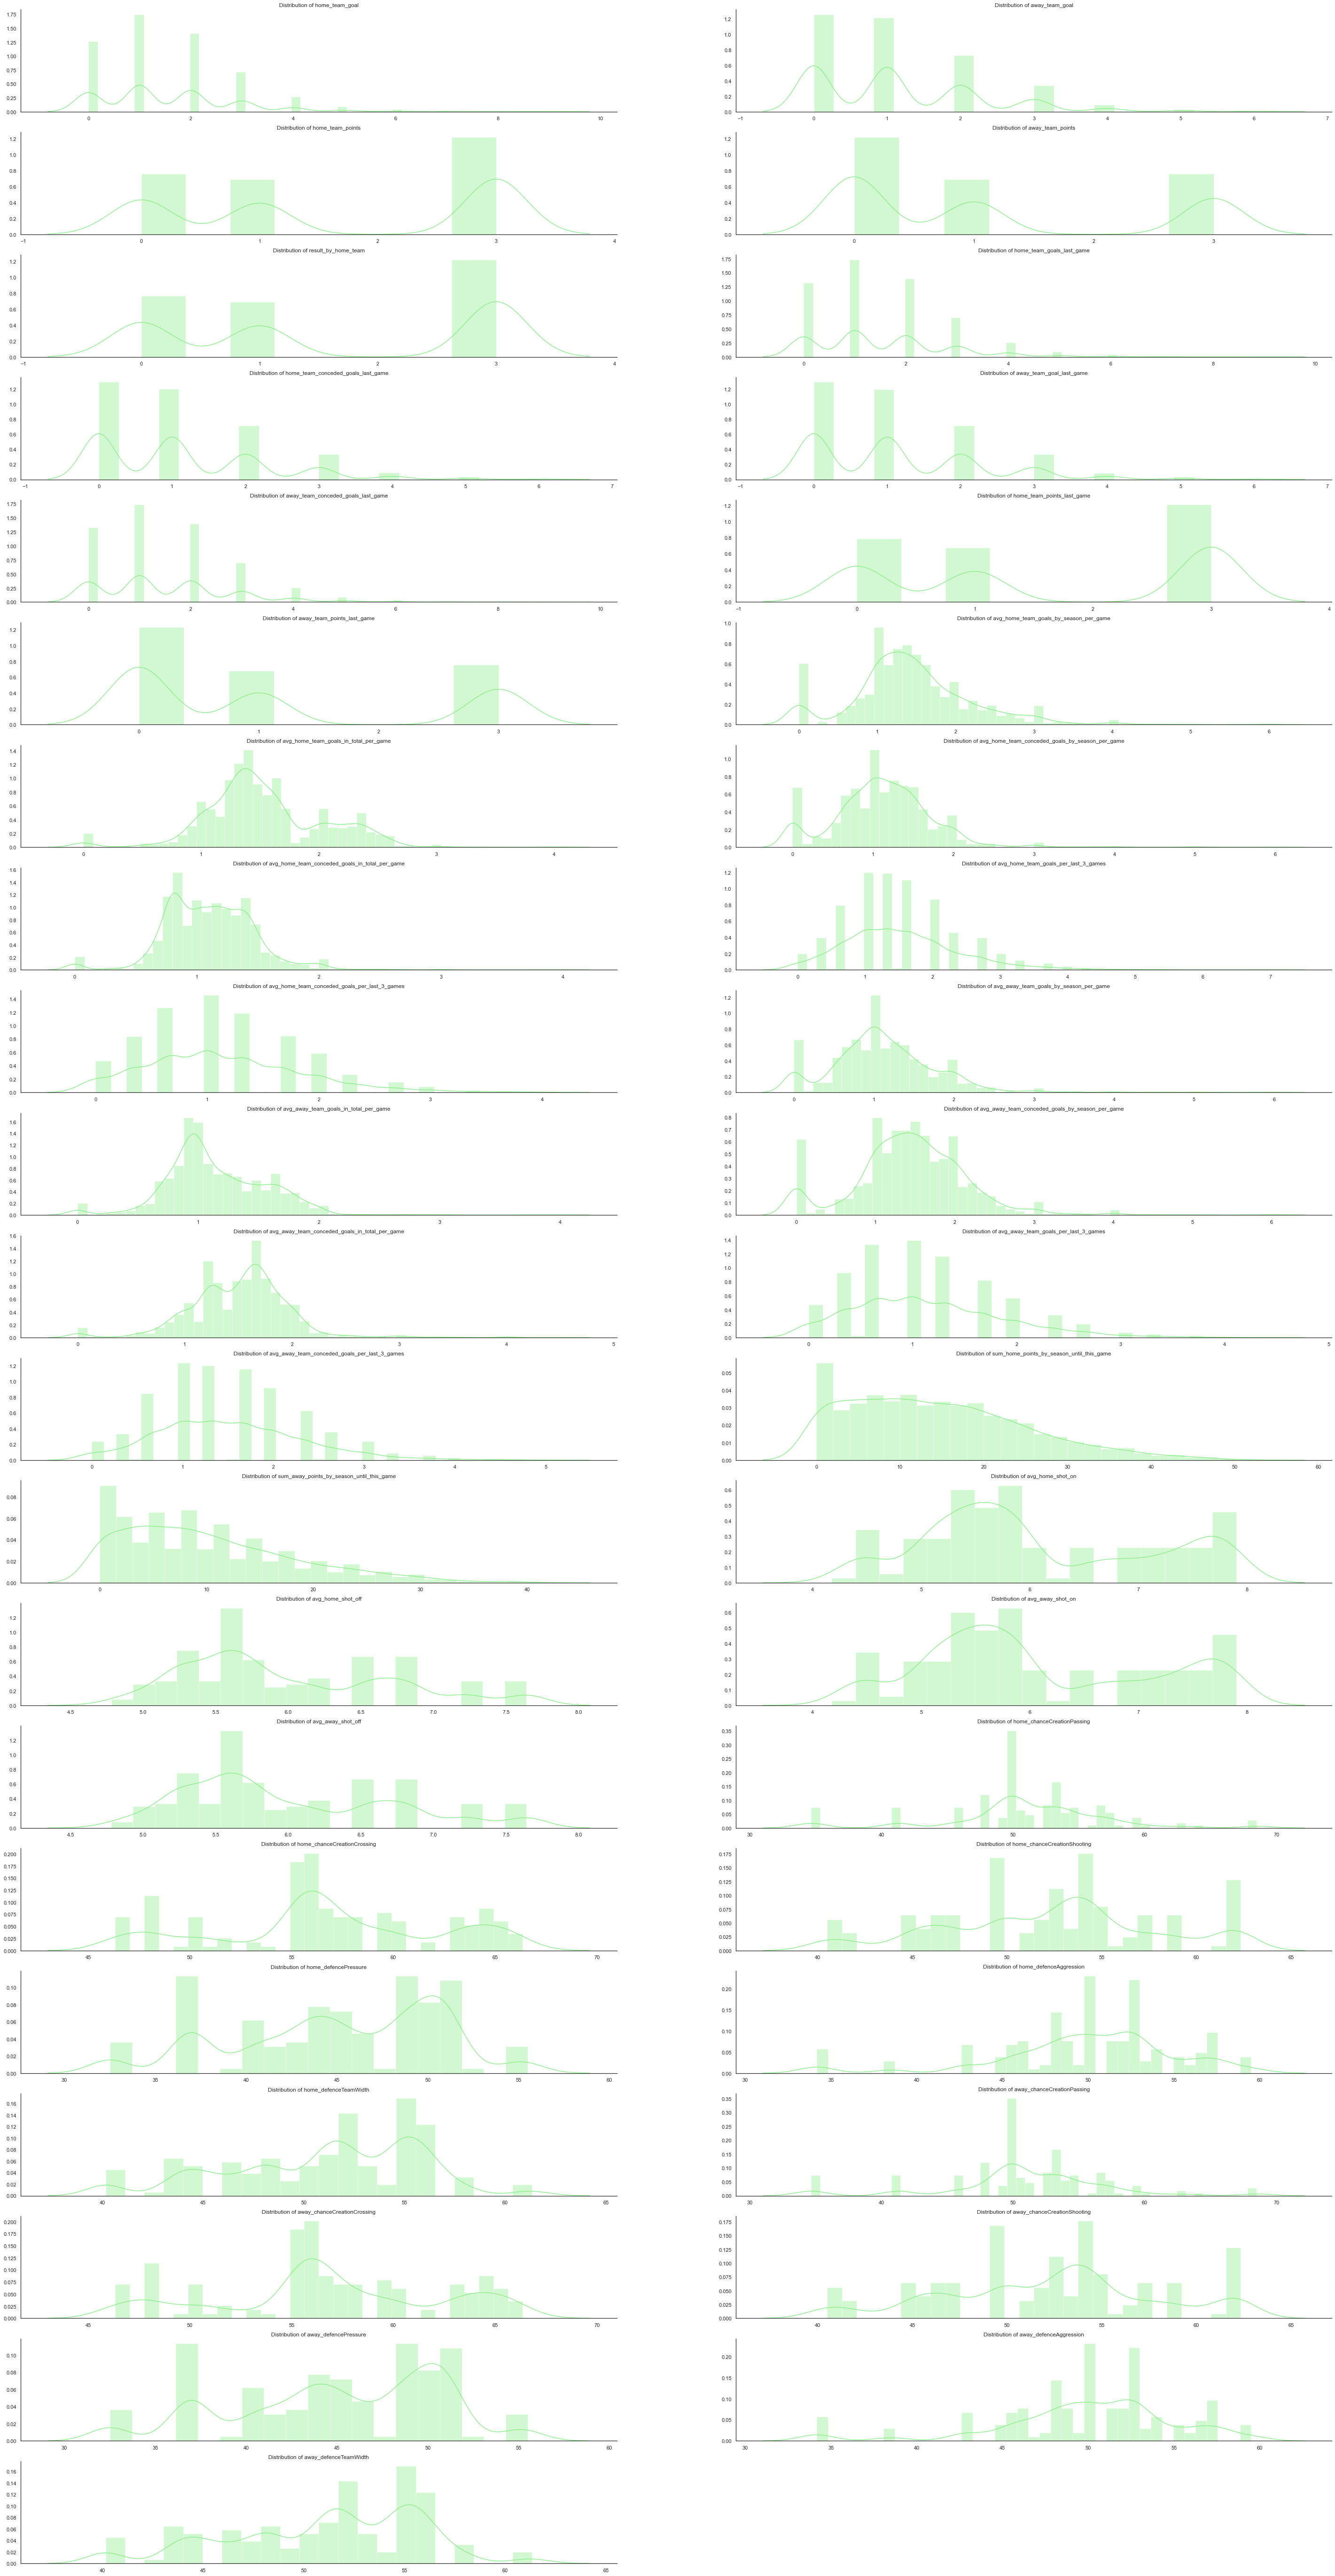

In [379]:
plt.figure(figsize=(50, 100))
cmap = sns.diverging_palette(250, 20, as_cmap=True)

for i in range(1, len(data_for_expl.columns) + 1):
    plt.subplot(21, 2, i)
    ax = sns.distplot(data_for_expl[data_for_expl.columns[i - 1]], color="lightgreen")
    ax.set(ylabel="")
    ax.set(xlabel="")
    ax.set_title(f"Distribution of {data_for_expl.columns[i-1]}")
    sns.despine(right=True, left=False)
plt.show()

Obviously most of our distributions of selected features doesn't look normal. Also, knowing that some features are in different scales(like number of goals and for example rantings about defense and attack of the teams), feature scaling must be applied. Also i will consider log transformation to 

* **Outliers** by every feature.

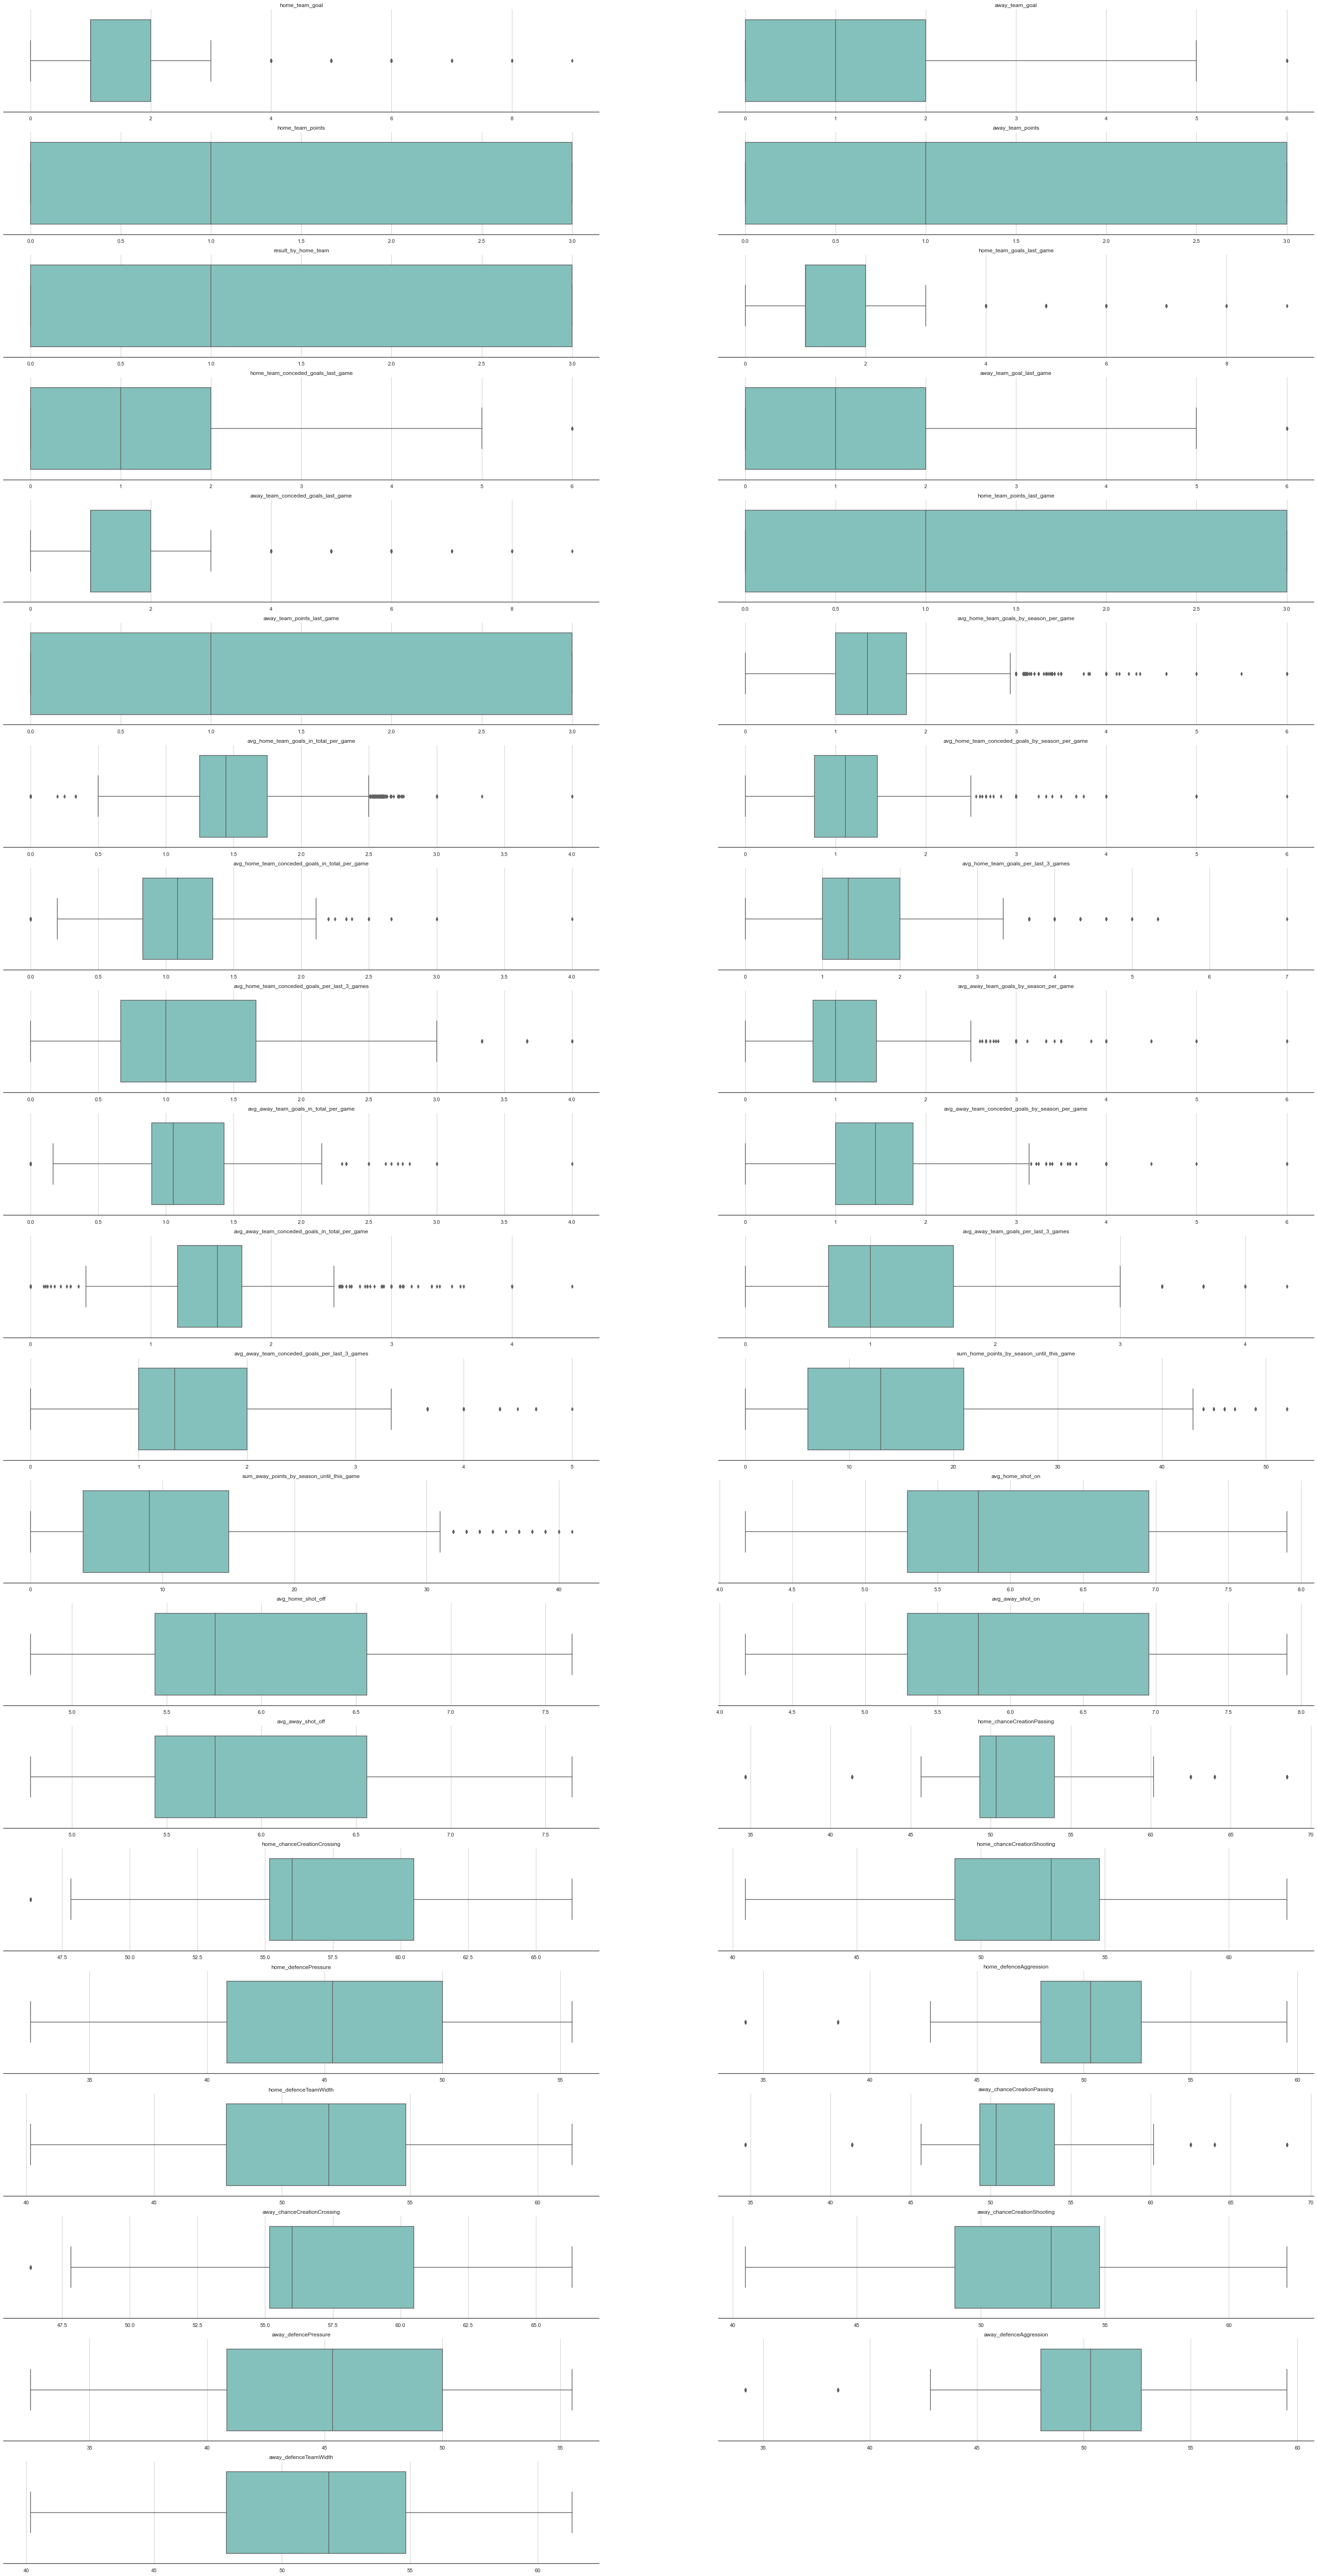

In [380]:
plt.figure(figsize = (50, 100))
for i in range(1, len(data_for_expl.columns)+1):
    plt.subplot(21, 2, i)
    outlier = sns.boxplot(x=data_for_expl.columns[i-1], data=data_for_expl, palette='GnBu')
    outlier.xaxis.grid(True)
    outlier.set(xlabel="")
    outlier.set_title(f'{data_for_expl.columns[i-1]}')
    sns.despine(right=True, left=True)
plt.show()

There are some outliers, but especially in the dta, that was taken from the team scored goals, so all values were norma and possible, some team score or concede more goals than the median, but these outliers can impact the result of the match and are important.

* **target variable - result_by_home_team**

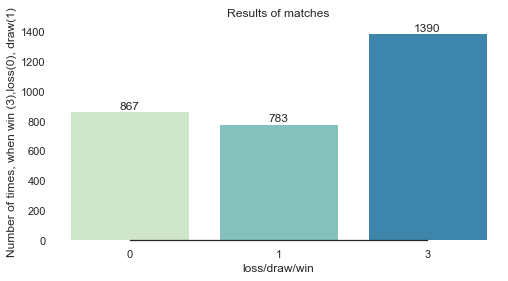

In [381]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(8, 4))

sns.countplot(x='result_by_home_team',
            data=data_for_expl, 
            palette= 'GnBu')

ax.set_title('Results of matches')
ax.set(ylabel="Number of times, when win (3),loss(0), draw(1)")
ax.set(xlabel="loss/draw/win")
ax.bar_label(ax.containers[0])
sns.despine(trim=True, left=True)

As we already know, there are a lot more wins by the home team and draw/loss is divided almost in halves. 

* How varies the distributions of every feature by every win/loss/draw group, you may see above.

In [382]:
correlations = data_for_expl.corr()['result_by_home_team'].sort_values(ascending=False).to_frame()
correlations.rename({'result_by_home_team': 'correlation coeficient'}, axis=1)

correlation coeficient
home_team_points                                                   1.00
result_by_home_team                                                1.00
home_team_goal                                                     0.63
avg_home_shot_on                                                   0.25
avg_home_shot_off                                                  0.24
avg_home_team_goals_in_total_per_game                              0.21
away_chanceCreationPassing                                         0.18
avg_away_team_conceded_goals_in_total_per_game                     0.17
avg_home_team_goals_by_season_per_game                             0.16
sum_home_points_by_season_until_this_game                          0.14
avg_home_team_goals_per_last_3_games                               0.13
avg_away_team_conceded_goals_by_season_per_game                    0.11
avg_away_team_conceded_goals_per_last_3_games                      0.09
away_chanceCreationCrossing                                        0.09
home_team_goals_last_game                                          0.07
home_defencePressure                                               0.07
home_chanceCreationShooting                                        0.07
home_team_points_last_game                                         0.07
away_team_conceded_goals_last_game                                 0.03
home_defenceAggression                                             0.02
home_defenceTeamWidth                                              0.02
away_defenceAggression                                            -0.02
away_defenceTeamWidth                                             -0.05
away_team_points_last_game                                        -0.05
away_team_goal_last_game                                          -0.06
home_team_conceded_goals_last_game                                -0.06
home_chanceCreationCrossing                                       -0.07
away_defencePressure                                              -0.08
away_chanceCreationShooting                                       -0.08
sum_away_points_by_season_until_this_game                         -0.09
avg_home_team_conceded_goals_per_last_3_games                     -0.10
avg_home_team_conceded_goals_by_season_per_game                   -0.11
avg_away_team_goals_per_last_3_games                              -0.12
avg_away_team_goals_by_season_per_game                            -0.12
avg_home_team_conceded_goals_in_total_per_game                    -0.20
home_chanceCreationPassing                                        -0.21
avg_away_team_goals_in_total_per_game                             -0.21
avg_away_shot_off                                                 -0.22
avg_away_shot_on                                                  -0.24
away_team_goal                                                    -0.60
away_team_points                                                  -0.94

As we see, my selected and engineered features doesn't seem to be very correlated with the outcome of the game :) Mostly correlated are actual values from the game, which cannot be included into the model, as this data is unknown until the game end.

* Correlation between all features.

Text(505.6531250000003, 0.5, '')

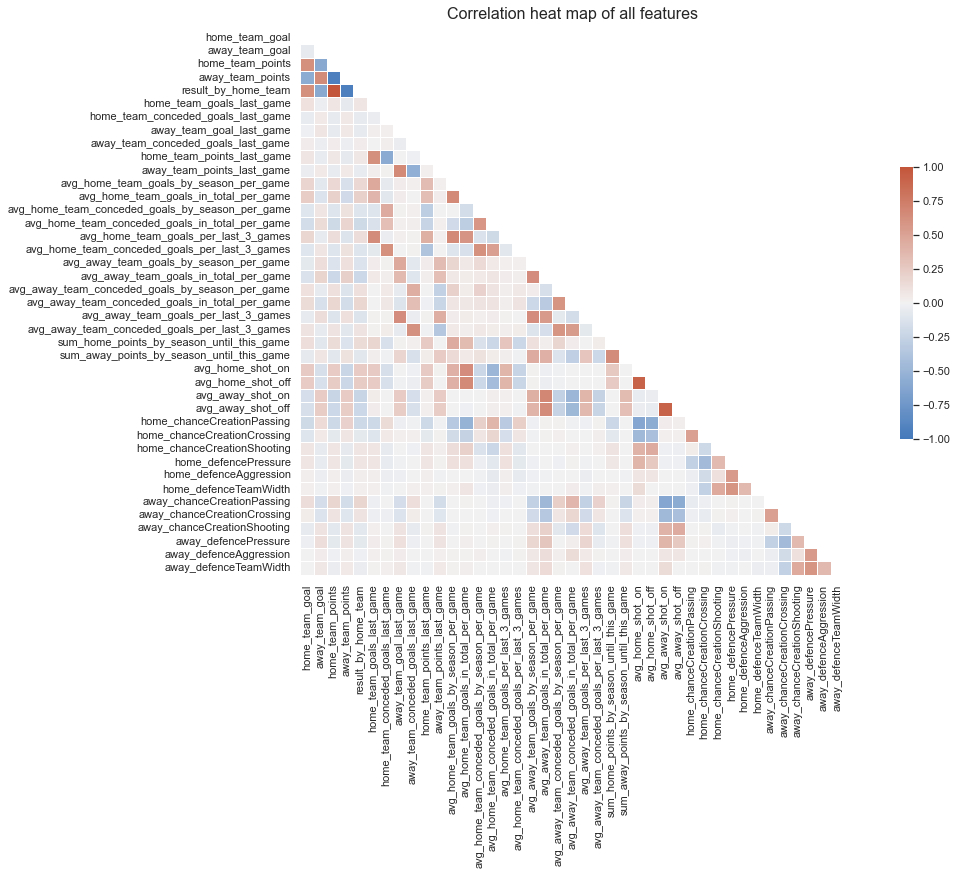

In [385]:
corr = data_for_expl.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 10))

cmap = sns.diverging_palette(250, 20, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=False,
)

heatmap.set_title(
    "Correlation heat map of all features",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("")

As we see, not many features are in total correlated, correlations are very weak. That shouldn't cause Multicollinearity in models

In [173]:
england_table_4.to_csv('final_table.csv', index=False)

So, to conclude, let's try to fit some models.

[Google data studio dashboard](https://datastudio.google.com/s/quST8sxIWpE)